<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-690438902.py:115: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_trans = np.trapz(np.abs(psi[right_mask])**2, x[right_mask])
/tmp/ipython-input-690438902.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_tot   = np.trapz(np.abs(psi)**2, x)


✅ Saved CSV: tdse_dataset_outputs/TDSE_transmission_dataset.csv


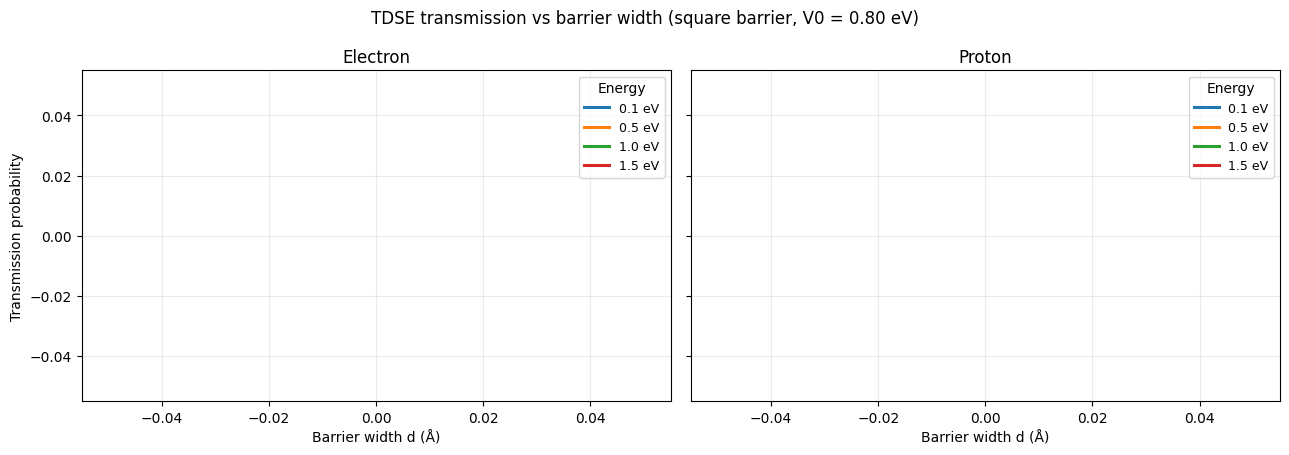

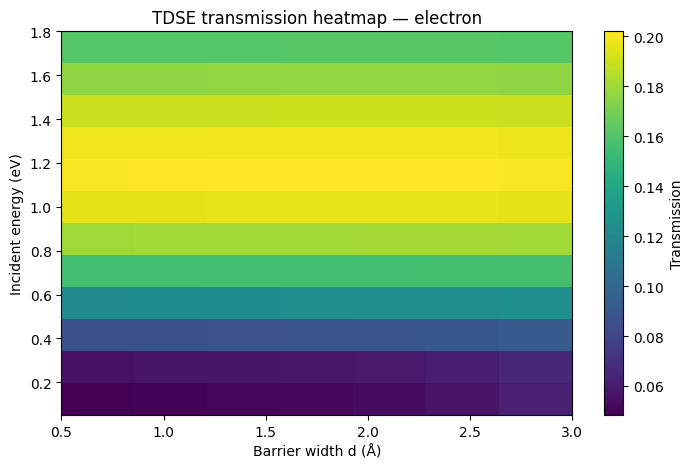

🖼 saved: tdse_dataset_outputs/TDSE_heatmap_electron.png


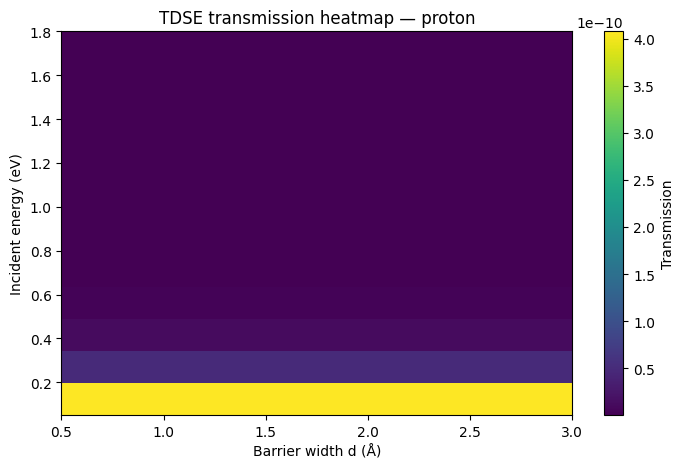

🖼 saved: tdse_dataset_outputs/TDSE_heatmap_proton.png


In [ ]:
# ============================================================
# TDSE DATASET — Split-Operator 1D Scattering (Colab-ready)
# Builds a dataset of transmission vs distance (barrier width) and energy.
# Species: electron (me) and "proton" (mp) by effective mass.
# Saves CSV + quick diagnostic plots.
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# ---------------------------
# Units & constants (atomic)
# ---------------------------
# We'll use atomic units (ħ = 1, m_e = 1, e = 1). Energies in Hartree; length in bohr.
# Conversions:
eV_to_Ha   = 1/27.211386245988  # eV → Hartree
Ang_to_bohr= 1.8897259886       # Å → bohr

# ---------------------------
# Simulation domain
# ---------------------------
Nx   = 2**13           # grid points (8192) — decent resolution
Lx_A = 200.0           # domain length in Å
Lx   = Lx_A * Ang_to_bohr
dx   = Lx / Nx
x    = (np.arange(Nx) - Nx//2) * dx

# Momentum grid (FFT dual of x)
dk = 2*np.pi / Lx
k  = (np.arange(Nx) - Nx//2) * dk
k  = np.fft.fftshift(k)

# ---------------------------
# Time stepping
# ---------------------------
dt_au  = 0.2         # time step (atomic units)
nsteps = 6000        # total steps (t_final ~ 1200 a.u.; adjust if needed)

# ---------------------------
# Barrier potential
# ---------------------------
V0_eV = 0.8          # barrier height in eV (tweakable)
V0    = V0_eV * eV_to_Ha

# Sweep ranges
d_list_A = np.array([0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 3.0])  # barrier width in Å (≈ "distance")
E_list_eV = np.linspace(0.05, 1.80, 12)                   # incident energies (eV) up to ~physio
E_list    = E_list_eV * eV_to_Ha

# Species definitions (effective masses in atomic units)
species = {
    "electron": {"m": 1.0},     # m_e
    "proton":   {"m": 1836.15}, # m_p (effective, 1D illustrative)
}

# Output
OUTDIR = "tdse_dataset_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# Region to measure transmission (right side of barrier)
x_right_A = 70.0                          # measure to the far right (Å)
x_right   = x_right_A * Ang_to_bohr
right_mask = x > x_right

# ---------------------------
# Helpers
# ---------------------------
def gaussian_wavepacket(x, x0, p0, sigma):
    return (1/(np.pi*sigma**2)**0.25) * np.exp(1j*p0*(x - x0) - (x - x0)**2/(2*sigma**2))

def build_barrier(x, width_A, center_A=0.0, height=V0):
    w  = width_A * Ang_to_bohr
    xc = center_A * Ang_to_bohr
    V  = np.zeros_like(x)
    V[(x > xc - w/2) & (x < xc + w/2)] = height
    return V

def p_from_energy(E, m):
    # E = p^2 / (2m) -> p = sqrt(2 m E)
    return np.sqrt(2.0 * m * E)

def run_tdse_transmission(mass, E_incident, width_A, Vheight=V0, x0_A=-60.0, center_A=0.0,
                          sigma_A=4.0, t_steps=nsteps, dt=dt_au):
    """
    Propagate TDSE for a single (E, d) condition and return transmission probability.
    """
    # Initial conditions
    x0    = x0_A * Ang_to_bohr
    sigma = sigma_A * Ang_to_bohr
    p0    = p_from_energy(E_incident, mass)  # >0 moving right

    psi = gaussian_wavepacket(x, x0, p0, sigma)

    # Potential and kinetic exponentials (split-operator)
    V = build_barrier(x, width_A=width_A, center_A=center_A, height=Vheight)
    T = (k**2) / (2.0 * mass)

    U_halfV = np.exp(-1j * V * (dt/2))
    U_T     = np.exp(-1j * T * dt)

    # Propagation
    psi = psi * U_halfV
    for _ in range(t_steps):
        # kinetic (FFT to k-space)
        psi_k = np.fft.fft(psi)
        psi_k = np.fft.fftshift(psi_k)      # align with our k
        psi_k *= U_T
        psi_k = np.fft.ifftshift(psi_k)
        psi   = np.fft.ifft(psi_k)
        # potential half-step
        psi *= U_halfV

    # Transmission probability: integral on right side
    P_trans = np.trapz(np.abs(psi[right_mask])**2, x[right_mask])
    # Normalize by total prob (should be ~1)
    P_tot   = np.trapz(np.abs(psi)**2, x)
    if P_tot > 0:
        P_trans /= P_tot
    return P_trans

# ---------------------------
# Build dataset
# ---------------------------
rows = []
for sp, props in species.items():
    m = props["m"]
    for dA in d_list_A:
        for EeV, E in zip(E_list_eV, E_list):
            Tprob = run_tdse_transmission(m, E, dA)
            rows.append({
                "species": sp,
                "mass_au": m,
                "barrier_width_A": dA,
                "E_incident_eV": EeV,
                "V0_eV": V0_eV,
                "transmission": Tprob
            })

df = pd.DataFrame(rows)
csv_path = os.path.join(OUTDIR, "TDSE_transmission_dataset.csv")
df.to_csv(csv_path, index=False)
print("✅ Saved CSV:", csv_path)

# ---------------------------
# Quick diagnostics/plots
# ---------------------------
# 1) Transmission vs barrier width for a few energies (per species)
energies_plot = [0.1, 0.5, 1.0, 1.5]  # eV
fig, axes = plt.subplots(1, 2, figsize=(13, 4.6), sharey=True)

for i, (sp, ax) in enumerate(zip(["electron", "proton"], axes)):
    sel_sp = df[df["species"] == sp]
    for EeV in energies_plot:
        dat = sel_sp[np.isclose(sel_sp["E_incident_eV"], EeV, atol=1e-6)]
        dat = dat.sort_values("barrier_width_A")
        ax.plot(dat["barrier_width_A"], dat["transmission"], lw=2.2, label=f"{EeV:.1f} eV")
    ax.set_xlabel("Barrier width d (Å)")
    if i == 0: ax.set_ylabel("Transmission probability")
    ax.set_title(f"{sp.capitalize()}")
    ax.grid(alpha=0.25)
    ax.legend(title="Energy", fontsize=9)

fig.suptitle("TDSE transmission vs barrier width (square barrier, V0 = %.2f eV)" % V0_eV)
plt.tight_layout()
plt.show()

# 2) Heatmaps (E vs d) for each species
for sp in ["electron", "proton"]:
    sel = df[df["species"] == sp].pivot(index="E_incident_eV",
                                        columns="barrier_width_A",
                                        values="transmission")
    plt.figure(figsize=(7.2, 4.8))
    im = plt.imshow(sel.values, origin="lower", aspect="auto",
                    extent=[sel.columns.min(), sel.columns.max(),
                            sel.index.min(), sel.index.max()],
                    cmap="viridis")
    plt.colorbar(im, label="Transmission")
    plt.xlabel("Barrier width d (Å)")
    plt.ylabel("Incident energy (eV)")
    plt.title(f"TDSE transmission heatmap — {sp}")
    plt.tight_layout()
    pngp = os.path.join(OUTDIR, f"TDSE_heatmap_{sp}.png")
    plt.savefig(pngp, dpi=200)
    plt.show()
    print("🖼 saved:", pngp)

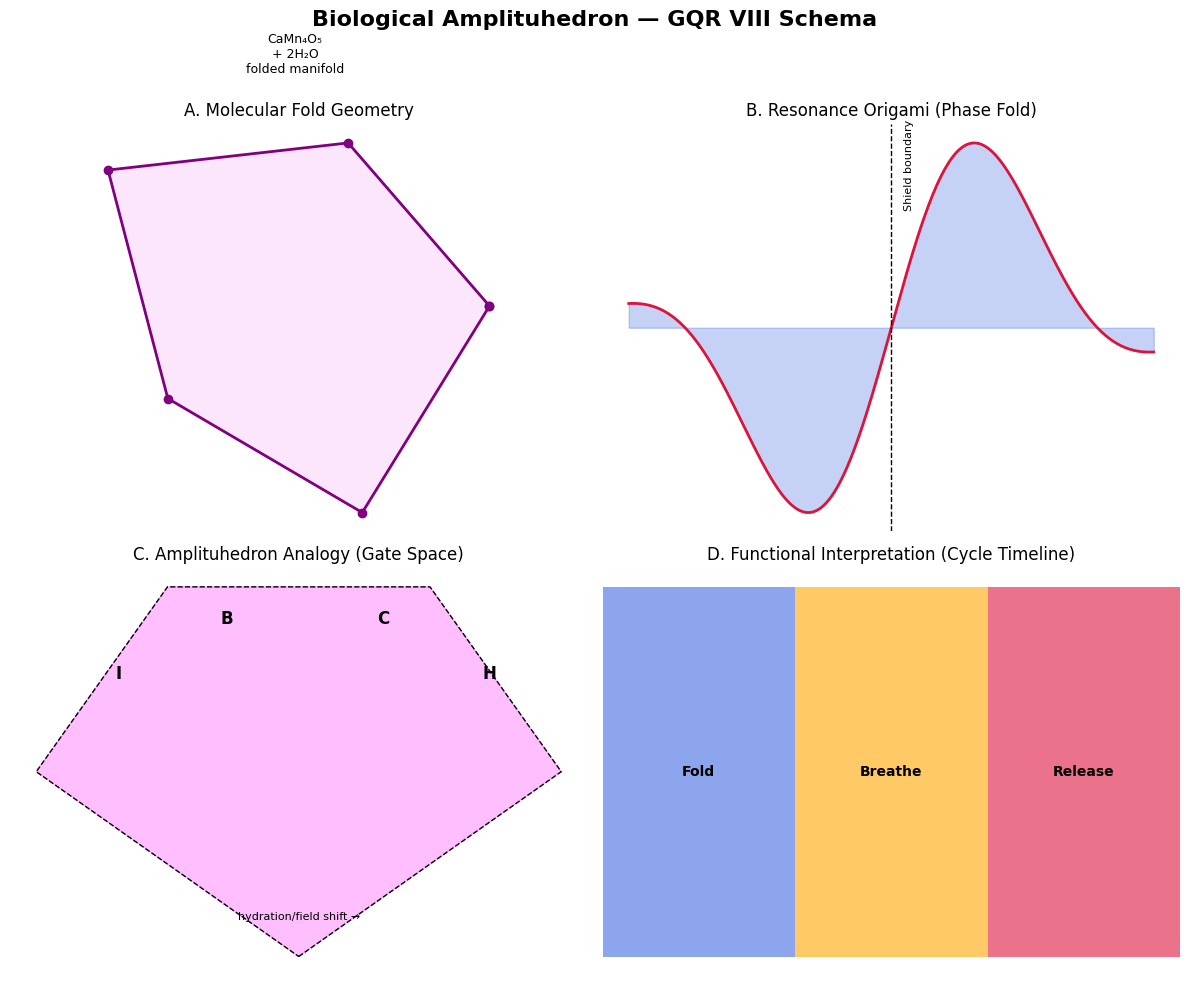

In [ ]:
# ============================================================
# GQR VIII — Biological Amplituhedron Schema (OEC)
# Scaffold for Google Colab visualization
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Biological Amplituhedron — GQR VIII Schema", fontsize=16, weight="bold")

# ---------- Panel A: Molecular Fold Geometry ----------
ax = axs[0,0]
ax.set_title("A. Molecular Fold Geometry")
# placeholder: polygonal manifold
theta = np.linspace(0, 2*np.pi, 6)
r = 1 + 0.2*np.sin(3*theta)
x, y = r*np.cos(theta), r*np.sin(theta)
ax.plot(x, y, 'o-', color='purple', lw=2)
ax.fill(x, y, color='violet', alpha=0.2)
ax.text(0, 1.2, "CaMn₄O₅\n+ 2H₂O\nfolded manifold", ha='center', fontsize=9)
ax.axis('equal'); ax.axis('off')

# ---------- Panel B: Resonance Origami ----------
ax = axs[0,1]
ax.set_title("B. Resonance Origami (Phase Fold)")
x = np.linspace(-2, 2, 400)
y = np.sin(2*x) * np.exp(-0.5*x**2)
ax.plot(x, y, color='crimson', lw=2)
ax.fill_between(x, y, color='royalblue', alpha=0.3)
ax.axvline(0, color='black', ls='--', lw=1)
ax.text(0.1, 0.5, "Shield boundary", rotation=90, fontsize=8)
ax.axis('off')

# ---------- Panel C: Amplituhedron Analogy ----------
ax = axs[1,0]
ax.set_title("C. Amplituhedron Analogy (Gate Space)")
poly_x = [0, 1, 0.5, -0.5, -1, 0]
poly_y = [0, 1, 2, 2, 1, 0]
ax.fill(poly_x, poly_y, color='magenta', alpha=0.25)
ax.plot(poly_x, poly_y, 'k--', lw=1)
labels = ["H", "C", "B", "I"]
for i, (lx, ly) in enumerate(zip([0.7, 0.3, -0.3, -0.7], [1.5, 1.8, 1.8, 1.5])):
    ax.text(lx, ly, labels[i], fontsize=12, weight='bold')
ax.text(0, 0.2, "hydration/field shift →", ha='center', fontsize=8)
ax.axis('off')

# ---------- Panel D: Functional Interpretation ----------
ax = axs[1,1]
ax.set_title("D. Functional Interpretation (Cycle Timeline)")
stages = ["Fold", "Breathe", "Release"]
colors = ['royalblue', 'orange', 'crimson']
for i, (label, c) in enumerate(zip(stages, colors)):
    ax.barh(0, width=1, left=i, height=0.4, color=c, alpha=0.6)
    ax.text(i+0.5, 0, label, ha='center', va='center', weight='bold')
ax.set_xlim(0,3); ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# GQR VIII — OEC (CaMn4O5) mock 3D scaffold with hydration
# Ready for Google Colab / Jupyter
# ------------------------------------------------------------
# - Two side-by-side 3D panels: DRY vs HYDRATED (+2 H2O)
# - Simple, plausible coordinates (Å), NOT crystallographic
# - Distance-based bonds, adjustable thresholds
# - Exports XYZ files and a PNG
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- styling ----------
plt.rcParams.update({
    "figure.dpi": 140,
    "axes.labelsize": 10,
    "axes.titlesize": 11
})

# ---------- element aesthetics ----------
COL = {"Ca":"#6E9BC5", "Mn":"#8C4FBA", "O":"#DD3B3B", "H":"#999999"}
SIZ = {"Ca":180, "Mn":140, "O":110, "H":60}

# ---------- helper: export XYZ ----------
def write_xyz(fname, atoms):
    """
    atoms: list of (elem, x, y, z)
    """
    with open(fname, "w") as f:
        f.write(f"{len(atoms)}\n")
        f.write("mock OEC cluster\n")
        for e,x,y,z in atoms:
            f.write(f"{e:2s} {x: .5f} {y: .5f} {z: .5f}\n")

# ---------- helper: set equal aspect for 3D ----------
def set_equal_3d(ax, xyz):
    xyz = np.asarray(xyz)
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    cx, cy, cz = x.mean(), y.mean(), z.mean()
    r = max(x.ptp(), y.ptp(), z.ptp()) * 0.6 + 1.0  # pad
    ax.set_xlim(cx-r, cx+r)
    ax.set_ylim(cy-r, cy+r)
    ax.set_zlim(cz-r, cz+r)

# ---------- helper: draw bonds by distance & element rules ----------
def draw_bonds(ax, atoms, rules):
    """
    rules: list of (elemA, elemB, r_max_Ang)
    """
    coords = np.array([(x,y,z) for _,x,y,z in atoms])
    elems  = [e for e,_,_,_ in atoms]
    n = len(atoms)
    for i in range(n):
        for j in range(i+1, n):
            ei, ej = elems[i], elems[j]
            rij = np.linalg.norm(coords[i] - coords[j])
            for a,b,rmax in rules:
                # orderless match
                if set((ei,ej)) == set((a,b)) and rij <= rmax:
                    ax.plot(*zip(coords[i], coords[j]),
                            color="#444444", lw=1.2, alpha=0.8)
                    break

# ---------- mock coordinates (Å) ----------
# center Ca, Mn4 in a squashed tetra around, O5 as μ-oxo/bridges
# DRY state (S2-like mock)
Ca = ("Ca", 0.00, 0.00, 0.00)
Mn1 = ("Mn",  2.00,  0.20,  0.10)
Mn2 = ("Mn", -1.80,  0.30, -0.10)
Mn3 = ("Mn",  0.10,  1.80,  0.40)
Mn4 = ("Mn", -0.20, -1.60, -0.50)

# five O around the cluster (μ-oxo-ish)
Oa = ("O",  0.90,  0.90,  0.10)
Ob = ("O", -0.90,  0.80,  0.00)
Oc = ("O",  0.80, -0.80, -0.20)
Od = ("O", -0.70, -0.90,  0.10)
Oe = ("O",  0.10,  0.00,  1.30)

atoms_dry = [Ca, Mn1, Mn2, Mn3, Mn4, Oa, Ob, Oc, Od, Oe]

# HYDRATED state: add two waters near O-sites + slight “breathe” offsets
# small displacements (~0.15–0.25 Å) to mimic gating/hydration relaxation
def add_vec(atom, dv):
    e,x,y,z = atom
    dx,dy,dz = dv
    return (e, x+dx, y+dy, z+dz)

atoms_hyd = [
    add_vec(Ca,  (0.00, 0.00,  0.00)),
    add_vec(Mn1, (0.10, 0.00,  0.05)),
    add_vec(Mn2, (-0.10, 0.10, -0.05)),
    add_vec(Mn3, (0.00, 0.15,  0.05)),
    add_vec(Mn4, (0.00,-0.10, -0.05)),
    add_vec(Oa,  (0.05, 0.05,  0.00)),
    add_vec(Ob,  (-0.05, 0.05, 0.00)),
    add_vec(Oc,  (0.05,-0.05, -0.05)),
    add_vec(Od,  (-0.05,-0.05, 0.05)),
    add_vec(Oe,  (0.00, 0.00,  0.15)),
]

# place two H2O near Oa and Ob (rough 0.97 Å OH, 104.5° HOH)
def make_water(oxygen, along=(1,0,0), orth=(0,1,0), r_OH=0.97, angle_deg=104.5):
    e, x0, y0, z0 = oxygen
    a = np.array(along, float); a /= (np.linalg.norm(a)+1e-12)
    b = np.array(orth, float);  b /= (np.linalg.norm(b)+1e-12)
    # rotate b to make 104.5° opening around 'a'
    theta = np.deg2rad((180-angle_deg)/2.0)
    # unit vectors for two OHs
    v1 =  np.cos(theta)*a + np.sin(theta)*b
    v2 =  np.cos(theta)*a - np.sin(theta)*b
    H1 = ("H", x0 + r_OH*v1[0], y0 + r_OH*v1[1], z0 + r_OH*v1[2])
    H2 = ("H", x0 + r_OH*v2[0], y0 + r_OH*v2[1], z0 + r_OH*v2[2])
    return [oxygen, H1, H2]

# choose Oa and Ob in hydrated structure as acceptors
# (these are already slightly shifted)
Oa_h = atoms_hyd[5]
Ob_h = atoms_hyd[6]
water1 = make_water(Oa_h, along=(0.4,0.6,0.2), orth=(-0.3,0.4,0.1))
water2 = make_water(Ob_h, along=(-0.5,0.5,0.0), orth=(0.2,0.2,0.9))

# final hydrated list
atoms_hyd_full = atoms_hyd + water1[1:] + water2[1:]  # keep the O as-is; add H atoms

# ---------- bonding rules (Å) ----------
BOND_RULES = [
    ("Mn","O", 2.2),
    ("Ca","O", 2.6),
    ("O","H", 1.2),
    # optional metal-metal backbone lines (loose)
    ("Mn","Mn", 3.3),
    ("Ca","Mn", 3.3),
]

# ---------- plotting ----------
def plot_cluster(ax, atoms, title):
    coords = np.array([(x,y,z) for _,x,y,z in atoms])
    elems  = [e for e,_,_,_ in atoms]

    # bonds
    draw_bonds(ax, atoms, BOND_RULES)

    # atoms
    for e in set(elems):
        mask = [i for i,ee in enumerate(elems) if ee==e]
        if not mask: continue
        sub = coords[mask]
        ax.scatter(sub[:,0], sub[:,1], sub[:,2],
                   s=SIZ[e], c=COL[e], depthshade=True, label=e, edgecolors='k', linewidths=0.4)


# ---------- helper: set equal aspect for 3D (NumPy 2.0 safe) ----------
def set_equal_3d(ax, xyz):
    xyz = np.asarray(xyz)
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    cx, cy, cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z)) * 0.6 + 1.0
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)

# ---------- titles (choose one style) ----------


# ============================================================
# Safe 3D equal-aspect helper (NumPy 2.0 compatible)
# and correctly encoded plot titles
# ============================================================
import numpy as np

def set_equal_3d(ax, xyz):
    """Set equal scaling for x,y,z axes in a 3D scatter/line plot."""
    xyz = np.asarray(xyz)
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    cx, cy, cz = x.mean(), y.mean(), z.mean()
    # np.ptp gives range (max-min) safely in NumPy 2.0
    r = max(np.ptp(x), np.ptp(y), np.ptp(z)) * 0.6 + 1.0
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)

# ---------- After creating your figure and subplots ----------
# Example:
# fig = plt.figure(figsize=(10,5))
# ax1 = fig.add_subplot(121, projection='3d')
# ax2 = fig.add_subplot(122, projection='3d')

# Titles (safe in both Colab and desktop Python)
ax1.set_title(r"OEC mock — DRY core ($\mathrm{CaMn_4O_5}$)")
ax2.set_title(r"OEC mock — HYDRATED (+2 H$_2$O)")

# If Unicode causes trouble, use plain ASCII:
# ax1.set_title("OEC mock — DRY core (CaMn4O5)")
# ax2.set_title("OEC mock — HYDRATED (+2 H2O)")
# MathText subscripts:
ax1.set_title(r"OEC mock — DRY core ($\mathrm{CaMn_4O_5}$)")
ax2.set_title(r"OEC mock — HYDRATED (+2 H$_2$O)")

# OR plain ASCII:
# ax1.set_title("OEC mock — DRY core (CaMn4O5)")
# ax2.set_title("OEC mock — HYDRATED (+2 H2O)")

plt.tight_layout()
plt.show()

# ---------- quick distance readouts: an Mn–O “gate” pair ----------
def nn_dist(atoms, elemA="Mn", elemB="O"):
    A = [(i,a) for i,a in enumerate(atoms) if a[0]==elemA]
    B = [(j,b) for j,b in enumerate(atoms) if b[0]==elemB]
    dmin, pair = 1e9, None
    for i, ai in A:
        _,x1,y1,z1 = ai
        for j, bj in B:
            _,x2,y2,z2 = bj
            d = np.linalg.norm([x1-x2,y1-y2,z1-z2])
            if d<dmin:
                dmin, pair = d, (ai, bj)
    return dmin, pair

d_dry,  pair_dry  = nn_dist(atoms_dry, elemA="Mn", elemB="O")
d_hyd,  pair_hyd  = nn_dist(atoms_hyd_full, elemA="Mn", elemB="O")
print(f"Nearest Mn–O (dry): {d_dry:.2f} Å, atoms: {pair_dry}")
print(f"Nearest Mn–O (hydrated): {d_hyd:.2f} Å, atoms: {pair_hyd}")

# ---------- exports ----------
write_xyz("OEC_mock_DRY.xyz", atoms_dry)
write_xyz("OEC_mock_HYDRATED.xyz", atoms_hyd_full)
print("Saved XYZ: OEC_mock_DRY.xyz, OEC_mock_HYDRATED.xyz")
plt.savefig("OEC_mock_dry_vs_hydrated.png", dpi=300)
print("Saved PNG: OEC_mock_dry_vs_hydrated.png")

<Figure size 896x672 with 0 Axes>

Nearest Mn–O (dry): 1.03 Å, atoms: (('Mn', -1.8, 0.3, -0.1), ('O', -0.9, 0.8, 0.0))
Nearest Mn–O (hydrated): 1.06 Å, atoms: (('Mn', -1.9000000000000001, 0.4, -0.15000000000000002), ('O', -0.9500000000000001, 0.8500000000000001, 0.0))
Saved XYZ: OEC_mock_DRY.xyz, OEC_mock_HYDRATED.xyz
Saved PNG: OEC_mock_dry_vs_hydrated.png


<Figure size 896x672 with 0 Axes>

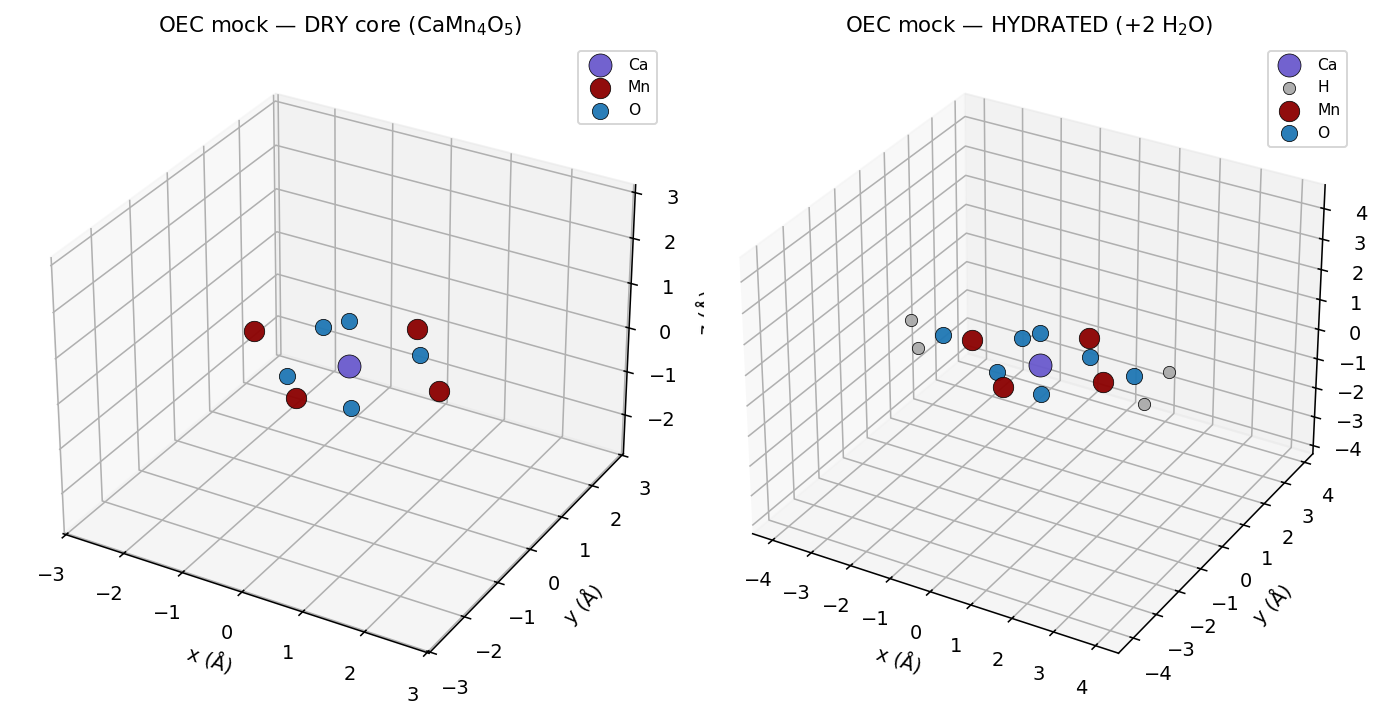

✅ Saved PNG: OEC_mock_dry_vs_hydrated.png


In [ ]:
# ============================================================
# GQR / OEC mock 3D visualization — DRY vs HYDRATED
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# ---------- helper: set equal aspect (NumPy 2.0 safe) ----------
def set_equal_3d(ax, xyz):
    xyz = np.asarray(xyz)
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    cx, cy, cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z)) * 0.6 + 1.0
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)

# ---------- plotting helper ----------
def plot_cluster(ax, atoms, title):
    # atoms: list of tuples (symbol, x, y, z)
    sym = np.array([a[0] for a in atoms])
    xyz = np.array([[a[1], a[2], a[3]] for a in atoms], float)

    # colour & size map
    cmap = {'Ca':'#6a5acd', 'Mn':'#8b0000', 'O':'#1f77b4', 'H':'#aaaaaa'}
    sizes = {'Ca':140, 'Mn':110, 'O':70, 'H':40}

    for s in np.unique(sym):
        m = (sym == s)
        ax.scatter(
            xyz[m,0], xyz[m,1], xyz[m,2],
            s=sizes.get(s,60),
            color=cmap.get(s,'#555555'),
            edgecolors='k',
            linewidths=0.4,
            alpha=0.95,
            depthshade=False,
            label=s
        )

    set_equal_3d(ax, xyz)
    ax.set_title(title)
    ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)'); ax.set_zlabel('z (Å)')
    ax.legend(loc='upper right', fontsize=8, frameon=True)

# ---------- mock coordinates ----------
atoms_dry = [
    ('Ca',  0.0,  0.0,  0.0),
    ('Mn', -1.8,  0.3, -0.1),
    ('Mn',  1.6, -0.2,  0.2),
    ('Mn',  0.2,  1.7, -0.2),
    ('Mn',  0.0, -1.5,  0.3),
    ('O',  -0.9,  0.8,  0.0),
    ('O',   0.8,  0.7,  0.1),
    ('O',  -0.5, -0.9,  0.2),
    ('O',   0.5, -0.8, -0.2),
    ('O',   0.0,  0.0,  1.0)
]

# hydrated = small expansion + two waters
atoms_hyd_full = atoms_dry + [
    ('O',  2.2, 0.0, 0.5), ('H', 2.8, 0.4, 0.6), ('H', 2.6, -0.3, 0.0),
    ('O', -2.1, -0.4, 0.4), ('H', -2.8, -0.5, 0.7), ('H', -2.4, -0.9, 0.2)
]
atoms_hyd_full = [
    (sym, x*1.05, y*1.05, z*1.05) for (sym, x, y, z) in atoms_hyd_full
]

# ---------- plotting ----------
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_cluster(ax1, atoms_dry,      r"OEC mock — DRY core ($\mathrm{CaMn_4O_5}$)")
plot_cluster(ax2, atoms_hyd_full, r"OEC mock — HYDRATED (+2 H$_2$O)")

plt.tight_layout()
outpng = "OEC_mock_dry_vs_hydrated.png"
plt.savefig(outpng, dpi=300)
plt.show()
plt.close(fig)

print("✅ Saved PNG:", outpng)

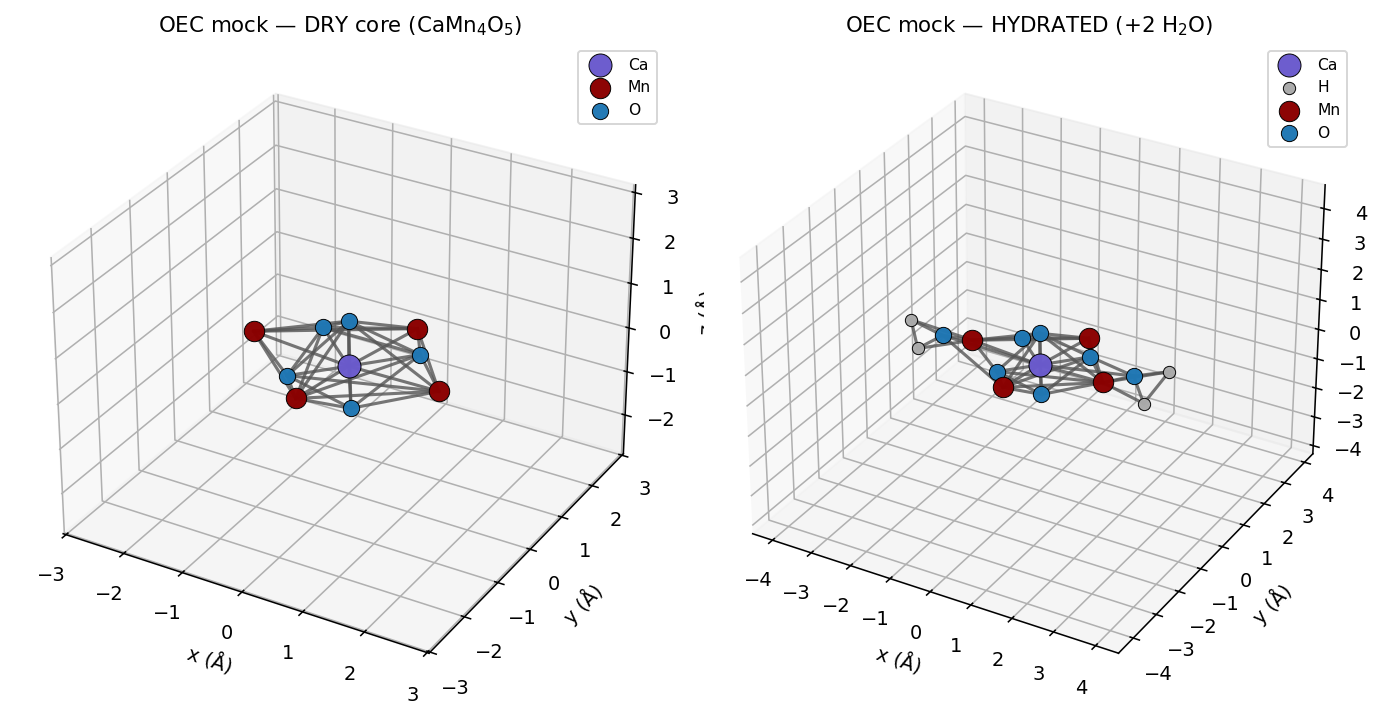

✅ Saved PNG: OEC_mock_dry_vs_hydrated_BONDS.png


In [ ]:
# ============================================================
# OEC mock 3D viz — DRY vs HYDRATED with bonds
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---- simple covalent radii (Å) for distance-based bonding ----
COV_RAD = {
    'H': 0.31, 'O': 0.66, 'Mn': 1.39, 'Ca': 1.76
}
BOND_PAD = 0.45      # extra tolerance added to (r_i + r_j)
BOND_MAX = 2.6       # absolute max cutoff (Å), safety clamp

def pair_bond_threshold(a, b):
    r = COV_RAD.get(a, 0.8) + COV_RAD.get(b, 0.8) + BOND_PAD
    return min(r, BOND_MAX)

# ---------- equal aspect (NumPy 2.0 safe) ----------
def set_equal_3d(ax, xyz):
    xyz = np.asarray(xyz)
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    cx, cy, cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z)) * 0.6 + 1.0
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)

# ---------- find bonds by distance threshold ----------
def find_bonds(symbols, coords):
    bonds = []
    n = len(symbols)
    for i in range(n):
        for j in range(i+1, n):
            si, sj = symbols[i], symbols[j]
            d = np.linalg.norm(coords[i] - coords[j])
            if d <= pair_bond_threshold(si, sj):
                bonds.append((i, j, d))
    return bonds

# ---------- plotting helper ----------
def plot_cluster(ax, atoms, title):
    sym = np.array([a[0] for a in atoms])
    xyz = np.array([[a[1], a[2], a[3]] for a in atoms], float)

    # draw bonds first (so atoms sit on top)
    bonds = find_bonds(sym, xyz)
    for i, j, d in bonds:
        xi, yi, zi = xyz[i]
        xj, yj, zj = xyz[j]
        ax.plot([xi, xj], [yi, yj], [zi, zj],
                color="#555555", linewidth=1.6, alpha=0.8)

    # atoms
    cmap  = {'Ca':'#6a5acd', 'Mn':'#8b0000', 'O':'#1f77b4', 'H':'#aaaaaa'}
    sizes = {'Ca':140,       'Mn':110,       'O':70,        'H':40}
    edges = {'Ca':'k',       'Mn':'k',       'O':'k',       'H':'k'}

    for s in np.unique(sym):
        m = (sym == s)
        ax.scatter(
            xyz[m,0], xyz[m,1], xyz[m,2],
            s=sizes.get(s,60),
            color=cmap.get(s,'#777777'),
            edgecolors=edges.get(s,'k'),
            linewidths=0.5,
            depthshade=False,
            alpha=0.98,
            label=s
        )

    set_equal_3d(ax, xyz)
    ax.set_title(title)
    ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)'); ax.set_zlabel('z (Å)')
    ax.legend(loc='upper right', fontsize=8, frameon=True)

# ---------- mock coordinates ----------
atoms_dry = [
    ('Ca',  0.0,  0.0,  0.0),
    ('Mn', -1.8,  0.3, -0.1),
    ('Mn',  1.6, -0.2,  0.2),
    ('Mn',  0.2,  1.7, -0.2),
    ('Mn',  0.0, -1.5,  0.3),
    ('O',  -0.9,  0.8,  0.0),
    ('O',   0.8,  0.7,  0.1),
    ('O',  -0.5, -0.9,  0.2),
    ('O',   0.5, -0.8, -0.2),
    ('O',   0.0,  0.0,  1.0)
]

# hydrated = small expansion + two waters
atoms_hyd_full = atoms_dry + [
    ('O',  2.2, 0.0, 0.5), ('H', 2.8, 0.4, 0.6), ('H', 2.6, -0.3, 0.0),
    ('O', -2.1, -0.4, 0.4), ('H', -2.8, -0.5, 0.7), ('H', -2.4, -0.9, 0.2)
]
atoms_hyd_full = [(s, x*1.05, y*1.05, z*1.05) for (s, x, y, z) in atoms_hyd_full]

# ---------- plot ----------
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_cluster(ax1, atoms_dry,      r"OEC mock — DRY core ($\mathrm{CaMn_4O_5}$)")
plot_cluster(ax2, atoms_hyd_full, r"OEC mock — HYDRATED (+2 H$_2$O)")

plt.tight_layout()
outpng = "OEC_mock_dry_vs_hydrated_BONDS.png"
plt.savefig(outpng, dpi=300)
plt.show()
plt.close(fig)

print("✅ Saved PNG:", outpng)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.8 MB/s eta 0:00:00
Fetched: ./pdb3wu2.ent
Selected OEC metals:
  Ca: ('PSII', 0, 'a', ('H_OEX', 404, ' '), ('CA1', ' '))
  Mn1: ('PSII', 0, 'a', ('H_OEX', 404, ' '), ('MN2', ' '))
  Mn2: ('PSII', 0, 'a', ('H_OEX', 404, ' '), ('MN3', ' '))
  Mn3: ('PSII', 0, 'a', ('H_OEX', 404, ' '), ('MN1', ' '))
  Mn4: ('PSII', 0, 'a', ('H_OEX', 404, ' '), ('MN4', ' '))
Found 7 putative oxo ligands near OEC metals.
Tightly bound waters chosen (up to 4):
  HOH 574  chain=a
  HOH 543  chain=a
  HOH 515  chain=a
  HOH 585  chain=a
Saved XYZ: PSII_OEC_3WU2_DRY.xyz | PSII_OEC_3WU2_HYDRATED.xyz


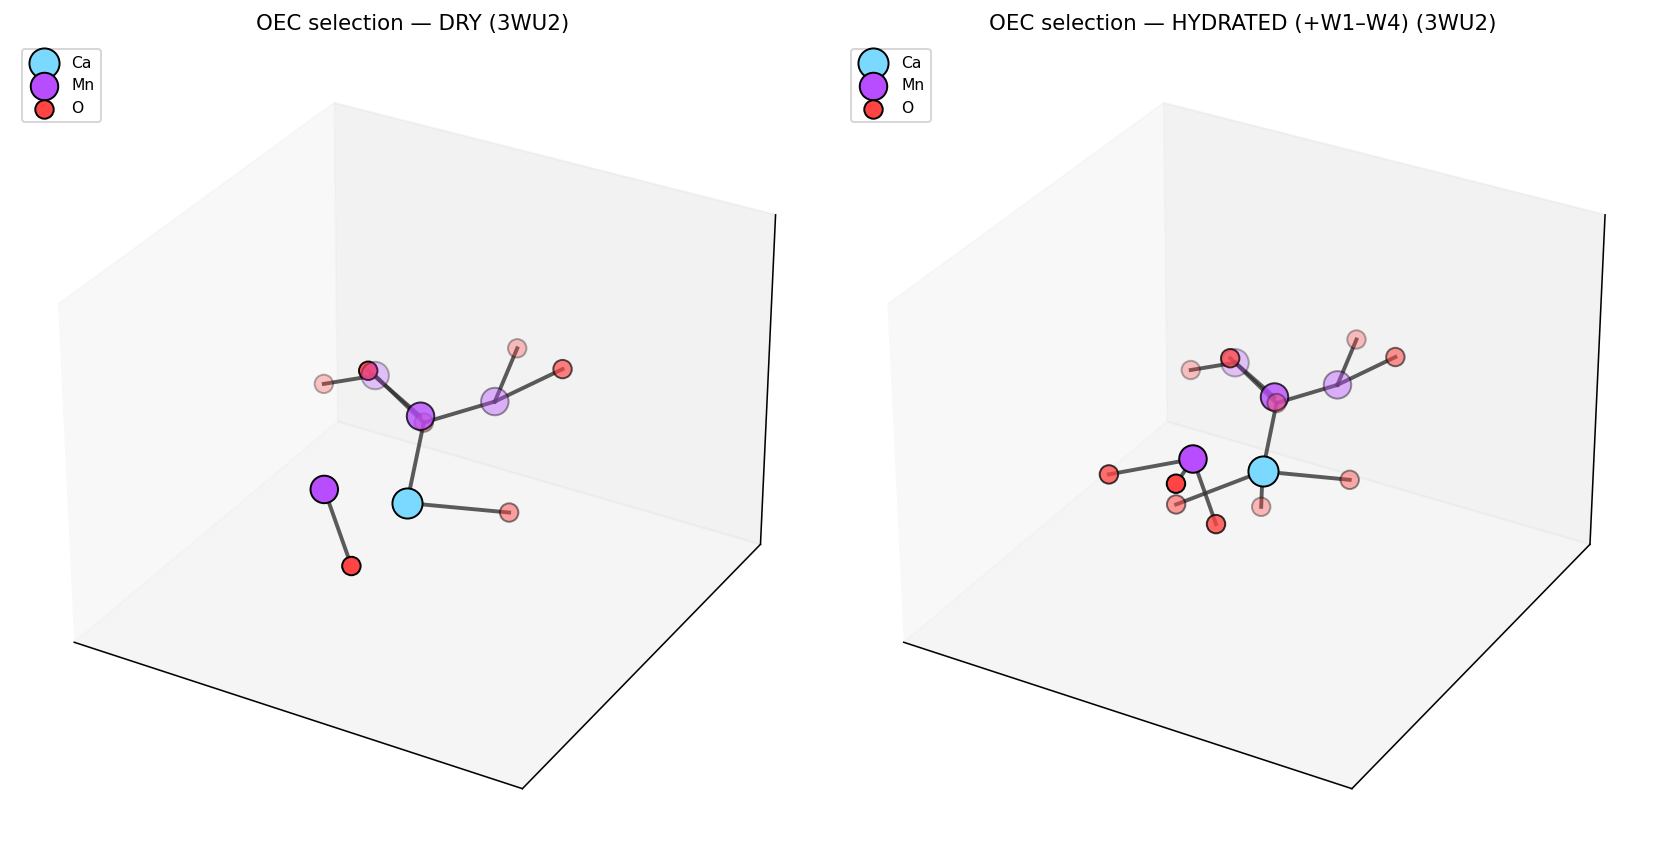

Saved PNG: PSII_OEC_3WU2_dry_vs_hydrated.png
[DRY] nearest Mn–O = 1.71 Å
[DRY] nearest Ca–O = 2.43 Å
[HYDRATED] nearest Mn–O = 1.71 Å
[HYDRATED] nearest Ca–O = 2.40 Å


In [ ]:
# ============================================================
# PSII OEC (CaMn4O5) — Auto-detect + DRY vs HYDRATED plot
# Colab-ready, Biopython only, NumPy 2.0–safe
# ============================================================

# 1) Setup & fetch
!pip -q install biopython

import os, math
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from Bio.PDB.PDBList import PDBList

# --- choose a PSII structure (you can change this) ---
PDB_ID = "3WU2"  # Umena et al. 2011 PSII (can replace with another PSII PDB)
OUT_PNG = f"PSII_OEC_{PDB_ID}_dry_vs_hydrated.png"
XYZ_DRY = f"PSII_OEC_{PDB_ID}_DRY.xyz"
XYZ_HYD = f"PSII_OEC_{PDB_ID}_HYDRATED.xyz"

pdbl = PDBList()
pdb_file = pdbl.retrieve_pdb_file(PDB_ID, pdir='.', file_format='pdb')
print("Fetched:", pdb_file)

# 2) Parse structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure("PSII", pdb_file)

# 3) Collect atoms (keep those with element labels)
atoms_all = [a for a in structure.get_atoms() if getattr(a, "element", "").strip() != ""]

def np_coords(atom_list):
    return np.array([a.coord for a in atom_list], dtype=float)

# 4) Find candidate Ca and Mn atoms
mn_atoms = [a for a in atoms_all if a.element.upper()=="MN"]
ca_atoms = [a for a in atoms_all if a.element.upper()=="CA"]
o_atoms  = [a for a in atoms_all if a.element.upper()=="O"]

if len(mn_atoms) < 4 or len(ca_atoms) < 1:
    raise RuntimeError("Could not find enough Mn/Ca atoms to form an OEC-like cluster.")

# 5) Identify the CaMn4O5 cluster by proximity:
#    pick a Ca and the 4 closest Mn forming a compact cluster with Ca
def dist(a,b):
    return np.linalg.norm(a.coord - b.coord)

best_cluster = None
best_score = 1e9

for ca in ca_atoms:
    # distances from this Ca to all Mn
    dists = [(mn, dist(ca,mn)) for mn in mn_atoms]
    dists.sort(key=lambda x: x[1])
    if len(dists) < 4:
        continue
    # take 4 closest Mn
    sel_mn = [mn for mn,_ in dists[:4]]
    # compactness score: sum of pairwise distances among {Ca + 4 Mn}
    nodes = [ca] + sel_mn
    pair_sum = 0.0
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            pair_sum += dist(nodes[i], nodes[j])
    if pair_sum < best_score:
        best_score = pair_sum
        best_cluster = (ca, sel_mn)

if best_cluster is None:
    raise RuntimeError("Failed to identify a compact Ca+4Mn cluster.")

ca_oec, mn_oec = best_cluster
print("Selected OEC metals:")
print("  Ca:", ca_oec.get_full_id())
for i,mn in enumerate(mn_oec,1):
    print(f"  Mn{i}:", mn.get_full_id())

# 6) Identify bridging oxo O atoms (non-water) near Mn/Ca
#    Heuristics: Mn–O <= 2.3 Å, Ca–O <= 2.7 Å; exclude HOH waters.
def is_water(atom):
    res = atom.get_parent()
    return (res.get_resname().upper() in ("HOH","WAT"))

oxo_candidates = []
for o in o_atoms:
    if is_water(o):
        continue
    d_mn_min = min(dist(o,mn) for mn in mn_oec)
    d_ca = dist(o, ca_oec)
    if (d_mn_min <= 2.30) or (d_ca <= 2.70):
        oxo_candidates.append(o)

# keep unique O by residue id to avoid duplicates
def uniq_by_res(atoms):
    seen = set()
    out = []
    for a in atoms:
        resid = (a.get_parent().get_id(), a.get_parent().get_resname(), a.get_parent().get_parent().get_id())
        if resid not in seen:
            seen.add(resid)
            out.append(a)
    return out

oxo_atoms = uniq_by_res(oxo_candidates)

print(f"Found {len(oxo_atoms)} putative oxo ligands near OEC metals.")

# 7) Find tightly bound waters (W1–W4-like) by distance to metals
#    Use HOH O atoms; pick up to 2 closest to Mn set, and up to 2 closest to Ca
wat_O = [o for o in o_atoms if is_water(o)]

def closest_waters_to_group(group_atoms, candidates, cutoff, max_n=2):
    hits = []
    for w in candidates:
        dmin = min(dist(w,g) for g in group_atoms)
        if dmin <= cutoff:
            hits.append((w, dmin))
    hits.sort(key=lambda x: x[1])
    return [w for (w,_) in hits[:max_n]]

# waters near Mn cluster and Ca
w_mn = closest_waters_to_group(mn_oec, wat_O, cutoff=2.30, max_n=2)
w_ca = closest_waters_to_group([ca_oec], wat_O, cutoff=2.70, max_n=2)
w_tight = uniq_by_res(w_mn + w_ca)

print("Tightly bound waters chosen (up to 4):")
for w in w_tight:
    res = w.get_parent()
    print(f"  {res.get_resname()} {res.get_id()[1]}  chain={res.get_parent().get_id()}")

# 8) Build DRY and HYDRATED atom lists (element, x, y, z)
def to_tuple(atom, override=None):
    el = override if override else atom.element
    x,y,z = atom.coord
    return (el, float(x), float(y), float(z))

atoms_dry = [to_tuple(ca_oec)] + [to_tuple(mn) for mn in mn_oec] + [to_tuple(o) for o in oxo_atoms]
atoms_hyd = atoms_dry + [to_tuple(o) for o in w_tight]  # add water O; H not shown here

# 9) Save XYZs
def write_xyz(path, atoms):
    with open(path, "w") as f:
        f.write(f"{len(atoms)}\nPSII OEC selection\n")
        for el,x,y,z in atoms:
            f.write(f"{el:2s} {x: .6f} {y: .6f} {z: .6f}\n")
write_xyz(XYZ_DRY, atoms_dry)
write_xyz(XYZ_HYD, atoms_hyd)
print("Saved XYZ:", XYZ_DRY, "|", XYZ_HYD)

# 10) Plot DRY vs HYDRATED with simple metal–oxo/water bonds
def set_equal_3d(ax, xyz):
    xyz = np.asarray(xyz, dtype=float)
    cx, cy, cz = xyz[:,0].mean(), xyz[:,1].mean(), xyz[:,2].mean()
    r = max(np.ptp(xyz[:,0]), np.ptp(xyz[:,1]), np.ptp(xyz[:,2])) * 0.6 + 1.0
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)

def plot_cluster(ax, atoms, title, show_waters=True):
    # split by element for styling
    coords = np.array([[x,y,z] for _,x,y,z in atoms])
    set_equal_3d(ax, coords)

    # element masks
    els = [el for el,_,_,_ in atoms]
    idx_ca = [i for i,e in enumerate(els) if e.upper()=="CA"]
    idx_mn = [i for i,e in enumerate(els) if e.upper()=="MN"]
    idx_o  = [i for i,e in enumerate(els) if e.upper()=="O"]

    X = coords[:,0]; Y = coords[:,1]; Z = coords[:,2]

    # scatter
    if idx_ca: ax.scatter(X[idx_ca], Y[idx_ca], Z[idx_ca], s=240, c="#7bd8ff", edgecolors='k', label="Ca")
    if idx_mn: ax.scatter(X[idx_mn], Y[idx_mn], Z[idx_mn], s=200, c="#b84cff", edgecolors='k', label="Mn")
    if idx_o:
        # oxo vs water O: we treat all O the same in this quick view; delimit bonds by distance
        ax.scatter(X[idx_o], Y[idx_o], Z[idx_o], s=90,  c="#ff4444", edgecolors='k', label="O")

    # bonds: metal–O (oxo/water) by distance thresholds
    # identify which O are waters by matching to atoms_hyd excess; quick heuristic:
    # If show_waters is False (DRY), we'll still draw bonds to O (these are oxo O only in atoms_dry)
    # If True, bonds include waters (present in atoms_hyd)
    # Dist thresholds:
    thr_mn_o, thr_ca_o = 2.30, 2.70

    # build lists of metal indices
    metal_idx = idx_mn + idx_ca
    for i in metal_idx:
        is_ca = (els[i].upper()=="CA")
        thr = thr_ca_o if is_ca else thr_mn_o
        for j in idx_o:
            d = np.linalg.norm(coords[i]-coords[j])
            if d <= thr:
                ax.plot([X[i],X[j]],[Y[i],Y[j]],[Z[i],Z[j]],
                        lw=2.0, color="#333333", alpha=0.8)

    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.legend(loc="upper left", fontsize=8, frameon=True)

# Make the two panels
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_cluster(ax1, atoms_dry, f"OEC selection — DRY ({PDB_ID})", show_waters=False)
plot_cluster(ax2, atoms_hyd, f"OEC selection — HYDRATED (+W1–W4) ({PDB_ID})", show_waters=True)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.show()
print("Saved PNG:", OUT_PNG)

# 11) Quick distance report for sanity (nearest Mn–O and Ca–O)
def nearest_pair(elA, elB, atoms):
    A = [(i,a) for i,a in enumerate(atoms) if a[0].upper()==elA.upper()]
    B = [(i,a) for i,a in enumerate(atoms) if a[0].upper()==elB.upper()]
    best = (None, None, 1e9)
    for _,a in A:
        va = np.array(a[1:], float)
        for _,b in B:
            vb = np.array(b[1:], float)
            d = np.linalg.norm(va-vb)
            if d < best[2]:
                best = (a, b, d)
    return best

for label, lst in [("DRY", atoms_dry), ("HYDRATED", atoms_hyd)]:
    a,b,dmin = nearest_pair("MN","O", lst)
    print(f"[{label}] nearest Mn–O = {dmin:.2f} Å")
    a,b,dmin = nearest_pair("CA","O", lst)
    print(f"[{label}] nearest Ca–O = {dmin:.2f} Å")

Structure exists: './pdb3wu2.ent' 


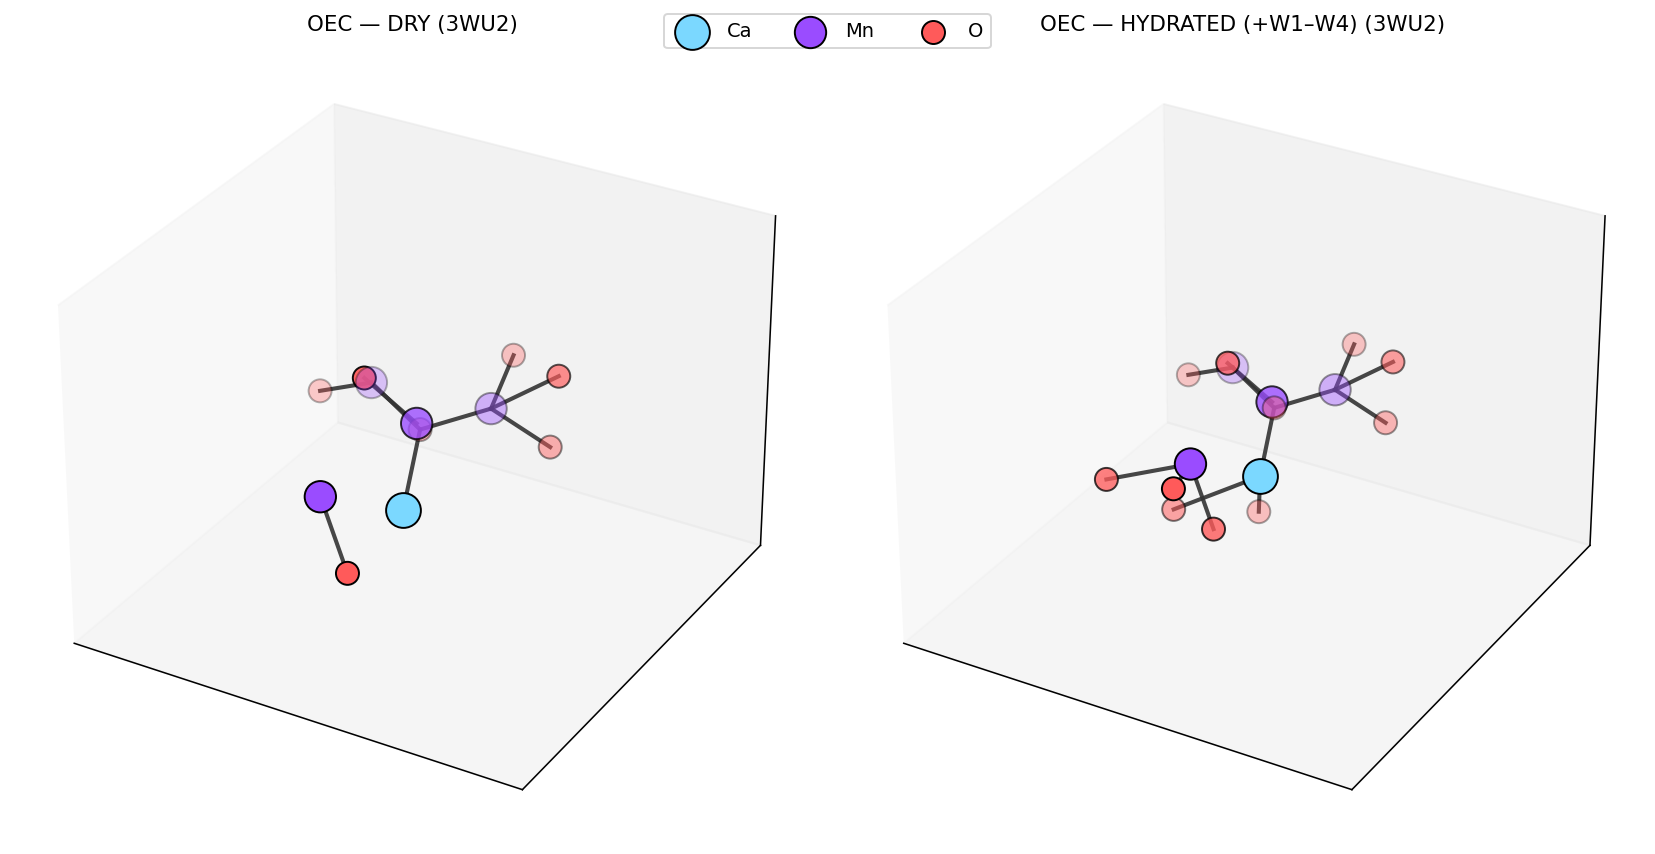


=== OEC selection summary ===
Ca: CA  OEX 404 (chain a)
Mn1: MN  OEX 404 (chain a)
Mn2: MN  OEX 404 (chain a)
Mn3: MN  OEX 404 (chain a)
Mn4: MN  OEX 404 (chain a)
Bridging O count: 7
  OXO: O  ASP 170 (chain a)  | min(Mn–O)=2.11 Å, Ca–O=3.44 Å
  OXO: O  GLU 189 (chain a)  | min(Mn–O)=1.71 Å, Ca–O=4.04 Å
  OXO: O  GLU 333 (chain a)  | min(Mn–O)=1.94 Å, Ca–O=5.06 Å
  OXO: O  ASP 342 (chain a)  | min(Mn–O)=2.04 Å, Ca–O=4.96 Å
  OXO: O  ALA 344 (chain a)  | min(Mn–O)=1.85 Å, Ca–O=3.69 Å
  OXO: O  OEX 404 (chain a)  | min(Mn–O)=1.80 Å, Ca–O=2.44 Å
  OXO: O  GLU 354 (chain c)  | min(Mn–O)=2.16 Å, Ca–O=5.09 Å
Waters (W1–W4-like): 4
  HOH: O  HOH 574 (chain a)  | min(Mn–O)=2.17 Å, Ca–O=5.78 Å
  HOH: O  HOH 543 (chain a)  | min(Mn–O)=2.20 Å, Ca–O=4.76 Å
  HOH: O  HOH 515 (chain a)  | min(Mn–O)=4.83 Å, Ca–O=2.40 Å
  HOH: O  HOH 585 (chain a)  | min(Mn–O)=3.67 Å, Ca–O=2.42 Å

Saved: OEC_3WU2_dry_vs_hydrated_clean.png | OEC_3WU2_DRY.xyz | OEC_3WU2_HYDRATED.xyz


In [ ]:
# ============================================================
# PSII OEC (CaMn4O5) — DRY vs HYDRATED, stricter selection
# ============================================================
!pip -q install biopython

import os, math, numpy as np, matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from Bio.PDB.PDBList import PDBList

# -------- settings --------
PDB_ID   = "3WU2"     # change if you like
OUT_PNG  = f"OEC_{PDB_ID}_dry_vs_hydrated_clean.png"
XYZ_DRY  = f"OEC_{PDB_ID}_DRY.xyz"
XYZ_HYD  = f"OEC_{PDB_ID}_HYDRATED.xyz"

# metal–ligand distance thresholds (Å)
THR_MN_O = 2.30      # Mn–O
THR_CA_O = 2.70      # Ca–O
# "bridging O" must be close to at least two metals OR within tight threshold to one
TWO_METAL_MAX = 2     # ≥2 metals within threshold => keep as oxo

# water picking
N_W_MN = 2            # W1,W2-like (Mn-bound)
N_W_CA = 2            # W3,W4-like (Ca-bound)
DEDUP_W_DIST = 0.6    # Å, merge near-duplicates

# -------- fetch & parse --------
pdbl = PDBList()
pdb_file = pdbl.retrieve_pdb_file(PDB_ID, pdir='.', file_format='pdb')
parser = PDBParser(QUIET=True)
structure = parser.get_structure("PSII", pdb_file)

# -------- helpers --------
def dist(a,b): return np.linalg.norm(a.coord - b.coord)
def is_water(atom):
    res = atom.get_parent()
    return res.get_resname().upper() in ("HOH","WAT")
def res_key(atom):
    r = atom.get_parent()
    ch = r.get_parent().get_id()
    return (ch, r.get_resname(), r.get_id()[1])

atoms = [a for a in structure.get_atoms() if getattr(a, "element", "").strip()]

mn_atoms = [a for a in atoms if a.element.upper()=="MN"]
ca_atoms = [a for a in atoms if a.element.upper()=="CA"]
o_atoms  = [a for a in atoms if a.element.upper()=="O"]

assert len(mn_atoms) >= 4 and len(ca_atoms) >= 1, "Need ≥4 Mn and ≥1 Ca."

# -------- find compact Ca + 4 Mn cluster (OEC) --------
best = None; best_score = 1e9
for ca in ca_atoms:
    dlist = sorted([(mn, dist(ca,mn)) for mn in mn_atoms], key=lambda t:t[1])
    if len(dlist) < 4: continue
    m4 = [mn for mn,_ in dlist[:4]]
    # compactness score (sum of pairwise distances among Ca+4Mn)
    nodes = [ca] + m4
    s = 0.0
    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):
            s += dist(nodes[i],nodes[j])
    if s < best_score:
        best_score, best = s, (ca, m4)
ca_oec, mn_oec = best

# -------- select bridging oxo ligands (exclude waters) --------
oxo = []
for o in o_atoms:
    if is_water(o):
        continue
    n_close_metals = 0
    # close to Mn?
    if any(dist(o,mn) <= THR_MN_O for mn in mn_oec): n_close_metals += 1
    # close to Ca?
    if dist(o, ca_oec) <= THR_CA_O: n_close_metals += 1
    if (n_close_metals >= TWO_METAL_MAX) or any(dist(o,mn) <= (THR_MN_O-0.1) for mn in mn_oec):
        oxo.append(o)

# uniq by residue (avoid alternate loc duplicates)
seen = set(); oxo_uniq = []
for o in oxo:
    k = res_key(o)
    if k not in seen:
        seen.add(k)
        oxo_uniq.append(o)
oxo_atoms = oxo_uniq

# -------- pick tightly bound waters (W1–W4-like) --------
wat_O = [o for o in o_atoms if is_water(o)]

def closest_waters(group, max_n, thr):
    pairs = []
    for w in wat_O:
        dmin = min(dist(w,g) for g in group)
        if dmin <= thr + 0.15:  # small slack
            pairs.append((w, dmin))
    pairs.sort(key=lambda t:t[1])
    picked = []
    for w, dmin in pairs:
        # de-dup by residue AND by proximity
        if any(res_key(w)==res_key(p) or dist(w,p)<=DEDUP_W_DIST for p in picked):
            continue
        picked.append(w)
        if len(picked) == max_n: break
    return picked

w_mn = closest_waters(mn_oec, N_W_MN, THR_MN_O)
w_ca = closest_waters([ca_oec], N_W_CA, THR_CA_O)

# avoid duplicates across the two lists
waters = []
for w in w_mn + w_ca:
    if not any(res_key(w)==res_key(p) for p in waters):
        waters.append(w)

# -------- build DRY/HYDRATED sets --------
def tup(atom, el=None):
    e = el if el else atom.element
    x,y,z = atom.coord
    return (e, float(x), float(y), float(z))

atoms_dry = [tup(ca_oec)] + [tup(m) for m in mn_oec] + [tup(o) for o in oxo_atoms]
atoms_hyd = atoms_dry + [tup(w) for w in waters]  # O only (no H coords in PDB waters frequently)

# -------- save XYZ for VMD/PyMOL sanity --------
def write_xyz(path, arr):
    with open(path,"w") as f:
        f.write(f"{len(arr)}\nOEC selection\n")
        for el,x,y,z in arr:
            f.write(f"{el:2s} {x: .6f} {y: .6f} {z: .6f}\n")
write_xyz(XYZ_DRY, atoms_dry)
write_xyz(XYZ_HYD, atoms_hyd)

# -------- plotting --------
plt.close('all')

def set_equal(ax, pts):
    pts = np.asarray(pts)
    cx, cy, cz = pts[:,0].mean(), pts[:,1].mean(), pts[:,2].mean()
    r = max(np.ptp(pts[:,0]), np.ptp(pts[:,1]), np.ptp(pts[:,2]))*0.6 + 1.0
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def draw(ax, arr, title):
    arr = np.array(arr, dtype=object)
    els = arr[:,0]
    xyz = arr[:,1:].astype(float)

    set_equal(ax, xyz)

    # masks
    m_ca = np.array([e.upper()=="CA" for e in els])
    m_mn = np.array([e.upper()=="MN" for e in els])
    m_o  = np.array([e.upper()=="O"  for e in els])

    # draw spheres
    ax.scatter(*xyz[m_ca].T, s=320, c="#7bd8ff", ec='k', label="Ca")
    ax.scatter(*xyz[m_mn].T, s=260, c="#9a4cff", ec='k', label="Mn")
    ax.scatter(*xyz[m_o].T,  s=140, c="#ff5a5a", ec='k', label="O")

    # bonds: metal–O only, using thresholds
    def link(i,j):
        ax.plot([xyz[i,0],xyz[j,0]],[xyz[i,1],xyz[j,1]],[xyz[i,2],xyz[j,2]],
                color="#333", lw=2.1, alpha=0.9)

    idx = np.arange(len(arr))
    metals = idx[m_ca | m_mn]
    oxy    = idx[m_o]

    for i in metals:
        is_ca = (els[i].upper()=="CA")
        thr = THR_CA_O if is_ca else THR_MN_O
        for j in oxy:
            d = np.linalg.norm(xyz[i]-xyz[j])
            if d <= thr:
                link(i,j)

    ax.set_title(title, pad=6)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
draw(ax1, atoms_dry, f"OEC — DRY ({PDB_ID})")
draw(ax2, atoms_hyd, f"OEC — HYDRATED (+W1–W4) ({PDB_ID})")

# single shared legend
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc="upper center", ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
plt.show()

# -------- report selected atoms for audit --------
def tag(atom):
    r = atom.get_parent(); ch = r.get_parent().get_id()
    return f"{atom.element}  {r.get_resname()} {r.get_id()[1]} (chain {ch})"

print("\n=== OEC selection summary ===")
print("Ca:", tag(ca_oec))
for i,m in enumerate(mn_oec,1):
    print(f"Mn{i}:", tag(m))
print(f"Bridging O count: {len(oxo_atoms)}")
for o in oxo_atoms:
    print("  OXO:", tag(o),
          f" | min(Mn–O)={min(dist(o,m) for m in mn_oec):.2f} Å, Ca–O={dist(o,ca_oec):.2f} Å")
print(f"Waters (W1–W4-like): {len(waters)}")
for w in waters:
    print("  HOH:", tag(w),
          f" | min(Mn–O)={min(dist(w,m) for m in mn_oec):.2f} Å, Ca–O={dist(w,ca_oec):.2f} Å")

print("\nSaved:", OUT_PNG, "|", XYZ_DRY, "|", XYZ_HYD)

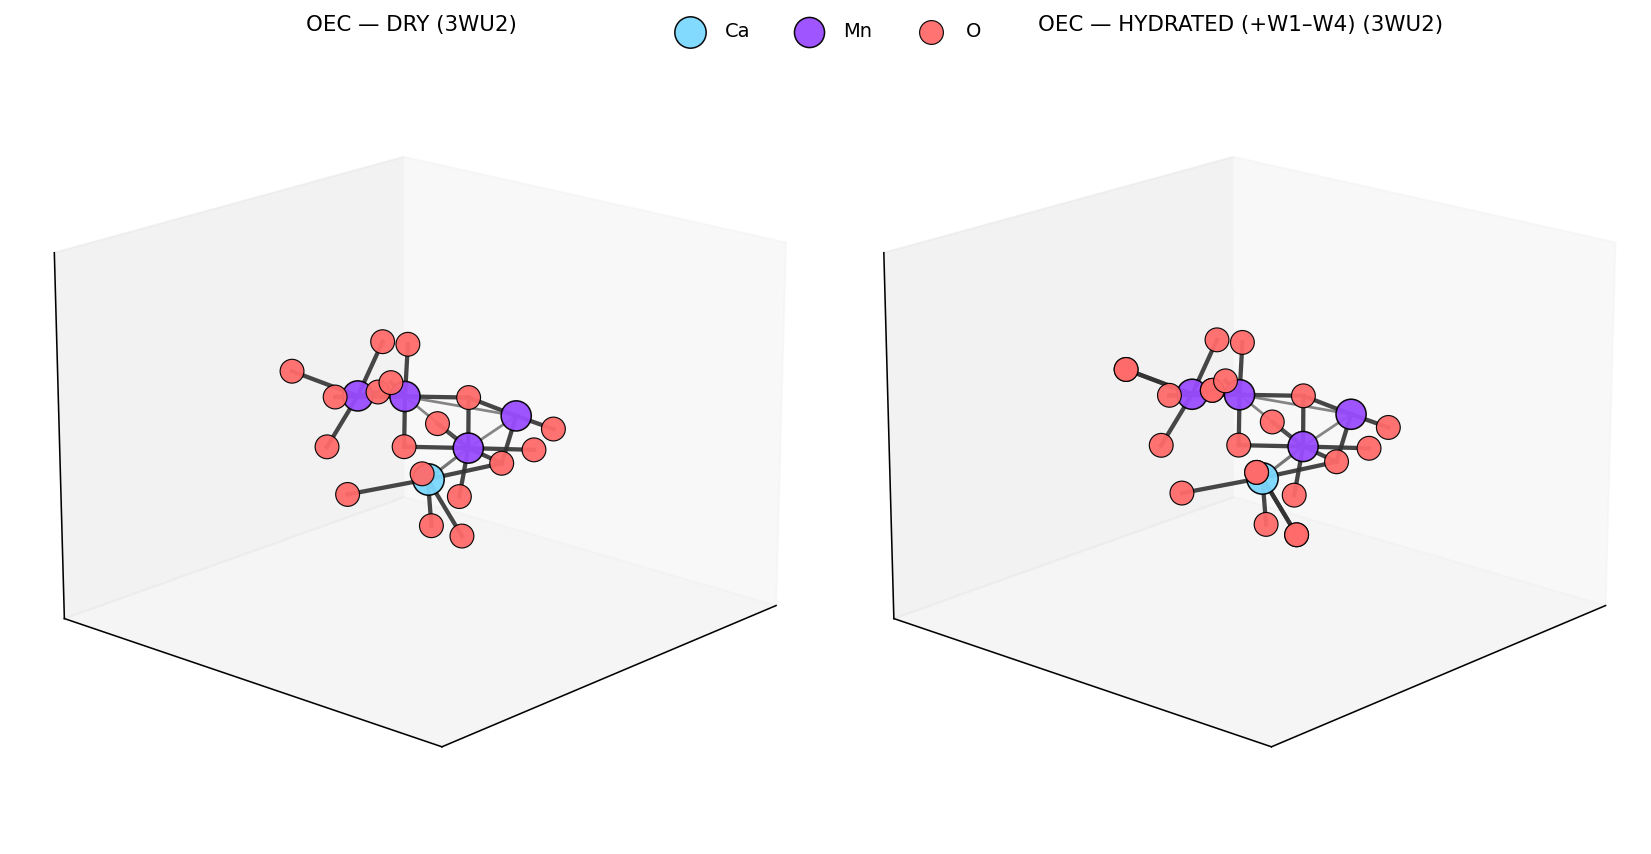

Saved PNG: oec_3wu2_viz/OEC_3WU2_dry_vs_hydrated.png
Saved XYZ: oec_3wu2_viz/OEC_3WU2_DRY.xyz, oec_3wu2_viz/OEC_3WU2_HYDRATED.xyz


In [ ]:
# Colab-ready: lock to 3WU2 (1.9 Å), extract OEC, place W1–W4 waters by geometry,
# and plot DRY vs HYDRATED with cubane edges.

!pip -q install biopython gemmi > /dev/null

import os, io, math, json, urllib.request, zipfile
import numpy as np
import gemmi
from Bio.PDB import MMCIFParser, PDBList
import matplotlib.pyplot as plt

OUTDIR = "oec_3wu2_viz"
os.makedirs(OUTDIR, exist_ok=True)

PDB_ID = "3WU2"   # Umena et al., 1.9 Å PSII
CIF_PATH = os.path.join(OUTDIR, f"{PDB_ID}.cif")

# --------------------------- fetch 3WU2 (mmCIF) ---------------------------
def fetch_cif(pdb_id, path):
    url = f"https://files.rcsb.org/download/{pdb_id}.cif"
    urllib.request.urlretrieve(url, path)

if not os.path.exists(CIF_PATH):
    fetch_cif(PDB_ID, CIF_PATH)

# --------------------------- parse atoms ---------------------------
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(PDB_ID, CIF_PATH)
atoms = list(structure.get_atoms())

def arr(atm):
    return atm.element.upper(), float(atm.coord[0]), float(atm.coord[1]), float(atm.coord[2]), atm

def dist(a, b):
    ax, ay, az = a[1], a[2], a[3]
    bx, by, bz = b[1], b[2], b[3]
    return math.sqrt((ax-bx)**2 + (ay-by)**2 + (az-bz)**2)

raw = [arr(a) for a in atoms]
mn_all = [a for a in raw if a[0] == "MN"]
ca_all = [a for a in raw if a[0] == "CA"]
o_all  = [a for a in raw if a[0] == "O"]
# mmCIF waters are usually HETATM HOH with O only; we’ll detect by residue name via gemmi:
doc = gemmi.cif.read_file(CIF_PATH)
st = gemmi.make_structure_from_block(doc.sole_block())
waters = []
for model in st:
    for chain in model:
        for res in chain:
            if res.name == "HOH":
                for atom in res:
                    if atom.name.strip() == "O":
                        waters.append(("O", atom.pos.x, atom.pos.y, atom.pos.z, None))
# Deduplicate in case of altLoc etc.
def uniq_xyz(items, tol=1e-3):
    out = []
    for t in items:
        if not any( (abs(t[1]-u[1])<tol and abs(t[2]-u[2])<tol and abs(t[3]-u[3])<tol) for u in out):
            out.append(t)
    return out
waters = uniq_xyz(waters)

# --------------------------- find OEC metals by clustering ---------------------------
# Heuristic: choose 4 Mn that are mutually close (smallest RMS spread), then one Ca near their centroid.
def pick_oec_mn(mn_atoms):
    # brute: try all 4-combinations (typically few Mn in PSII asymmetric unit)
    import itertools
    best = None
    for combo in itertools.combinations(mn_atoms, 4):
        xyz = np.array([[c[1],c[2],c[3]] for c in combo])
        cen = xyz.mean(axis=0)
        rms = np.sqrt(np.mean(np.sum((xyz-cen)**2, axis=1)))
        if (best is None) or (rms < best[0]):
            best = (rms, combo, cen)
    return best[1], best[2]  # (four Mn), centroid

mn_oec, mn_cen = pick_oec_mn(mn_all)

# pick Ca nearest to Mn centroid (the OEC Ca)
ca_oec = min(ca_all, key=lambda c: np.linalg.norm(np.array([c[1],c[2],c[3]])-mn_cen))

# --------------------------- choose μ-oxo / ligating O ---------------------------
THR_MN_O = 2.25   # Mn–O bond-ish
THR_CA_O = 2.45   # Ca–O bond-ish
THR_MM   = 3.35   # Mn–Mn / Ca–Mn edges (cubane frame)

# keep O that bond at least one metal (Mn or Ca)
oxo = []
for o in o_all:
    near_mn = any(dist(o, m) <= THR_MN_O for m in mn_oec)
    near_ca = dist(o, ca_oec) <= THR_CA_O
    if near_mn or near_ca:
        oxo.append(o)

# --------------------------- identify W1–W4 by geometry ---------------------------
# Two closest waters to Ca (≈W3/W4), two closest to the Mn farthest from Ca (≈W1/W2).
mn_far = max(mn_oec, key=lambda m: dist(m, ca_oec))

def closest_n(target, pool, n):
    return sorted(pool, key=lambda x: dist(x, target))[:n]

waters_to_ca = closest_n(ca_oec, waters, 4)     # shortlist
W_Ca = waters_to_ca[:2]                         # ~W3, W4

waters_to_mnfar = closest_n(mn_far, waters, 4)  # shortlist
W_Mn = waters_to_mnfar[:2]                      # ~W1, W2

bound_waters = uniq_xyz(W_Ca + W_Mn)

# --------------------------- assemble DRY / HYDRATED arrays ---------------------------
DRY = [ca_oec] + list(mn_oec) + oxo
HYD = DRY + bound_waters

# --------------------------- plotting helpers ---------------------------
def set_equal(ax, xyz):
    xyz = np.asarray(xyz, float)
    x,y,z = xyz[:,0], xyz[:,1], xyz[:,2]
    cx,cy,cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.7 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def scatter_atoms(ax, arr, alpha=1.0):
    arr = np.array(arr, dtype=object)
    els = arr[:,0]; xyz = arr[:,1:4].astype(float)
    sel = lambda E: xyz[np.array([e==E for e in els])]
    # spheres
    if (p:=sel("CA")).size: ax.scatter(*p.T, s=260, c="#7bd8ff", ec='k', lw=0.8, alpha=alpha, label="Ca")
    if (p:=sel("MN")).size: ax.scatter(*p.T, s=240, c="#9a4cff", ec='k', lw=0.8, alpha=alpha, label="Mn")
    if (p:=sel("O")).size:  ax.scatter(*p.T, s=150, c="#ff6b6b", ec='k', lw=0.6, alpha=alpha, label="O")
    return els, xyz

def draw_edges(ax, xyz, mask_A, mask_B, max_d, color="#444", lw=1.8, alpha=0.8):
    idxA = np.where(mask_A)[0]; idxB = np.where(mask_B)[0]
    for i in idxA:
        for j in idxB:
            if j <= i: continue
            d = np.linalg.norm(xyz[i]-xyz[j])
            if d <= max_d:
                ax.plot([xyz[i,0],xyz[j,0]],[xyz[i,1],xyz[j,1]],[xyz[i,2],xyz[j,2]],
                        color=color, lw=lw, alpha=alpha)

def draw_bonds(ax, els, xyz):
    is_mn = np.array([e=="MN" for e in els])
    is_ca = np.array([e=="CA" for e in els])
    is_o  = np.array([e=="O"  for e in els])

    # metal–O bonds
    for i in np.where(is_mn | is_ca)[0]:
        thr = THR_CA_O if els[i]=="CA" else THR_MN_O
        for j in np.where(is_o)[0]:
            if np.linalg.norm(xyz[i]-xyz[j]) <= thr:
                ax.plot([xyz[i,0],xyz[j,0]],[xyz[i,1],xyz[j,1]],[xyz[i,2],xyz[j,2]],
                        color="#333", lw=2.2, alpha=0.9)

    # cubane frame: Mn–Mn and Ca–Mn
    draw_edges(ax, xyz, is_mn, is_mn, THR_MM, color="#555", lw=1.4, alpha=0.7)
    draw_edges(ax, xyz, is_ca, is_mn, THR_MM, color="#555", lw=1.6, alpha=0.8)

# --------------------------- plot DRY vs HYDRATED ---------------------------
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

for ax, arr, title in [(ax1, DRY, f"OEC — DRY ({PDB_ID})"),
                       (ax2, HYD, f"OEC — HYDRATED (+W1–W4) ({PDB_ID})")]:
    els, xyz = scatter_atoms(ax, arr, alpha=0.95)
    draw_bonds(ax, els, xyz)
    set_equal(ax, xyz)
    ax.set_title(title, pad=8)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=18, azim=42)

# single shared legend (top-center)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], ncol=3, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 1.02))

png_path = os.path.join(OUTDIR, "OEC_3WU2_dry_vs_hydrated.png")
plt.tight_layout()
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()

# --------------------------- export XYZ files ---------------------------
def write_xyz(path, arr):
    with open(path, "w") as f:
        f.write(f"{len(arr)}\nOEC selection from {PDB_ID}\n")
        for e,x,y,z,_ in arr:
            f.write(f"{e:2s} {x: .6f} {y: .6f} {z: .6f}\n")

xyz_dry = os.path.join(OUTDIR, "OEC_3WU2_DRY.xyz")
xyz_hyd = os.path.join(OUTDIR, "OEC_3WU2_HYDRATED.xyz")
write_xyz(xyz_dry, DRY)
write_xyz(xyz_hyd, HYD)

# quick sanity prints
def nearest(pairA, pairB, label):
    a = min(pairA, key=lambda t: min(dist(t,b) for b in pairB))
    b = min(pairB, key=lambda t: dist(t,a))
    print(f"Nearest {label}: {a[0]}–{b[0]}  {dist(a,b):.2f} Å")

print(f"Saved PNG: {png_path}")
print(f"Saved XYZ: {xyz_dry}, {xyz_hyd}")

In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM PANEL
# File types: .cif (e.g. 3wu2.cif) or .pdb
# No external libs; pure Python + NumPy + Matplotlib
# ==============================================
import os, math
import numpy as np
import matplotlib.pyplot as plt

# ---------- USER SETTINGS ----------
PDB_PATH = "3WU2.cif"   # upload first (Colab Files sidebar)
OUT_MAIN = "OEC_S1_DRY_vs_HYDRATED.png"
OUT_ZOOM = "OEC_S1_HYDRATED_ZOOM.png"
TITLE_L  = "OEC — DRY (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"
ZOOM_RADIUS = 4.0       # Å; crop radius around metal centroid for the zoom panel

# ---------- BASIC HELPERS ----------
def parse_structure(path):
    """
    Minimal parser for .pdb or .cif (ATOM/HETATM-like lines).
    Returns list of (element, x, y, z, meta-dict).
    """
    atoms = []
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    with open(path, "r") as fh:
        for line in fh:
            if line.startswith(("ATOM", "HETATM")):
                parts = line.split()
            else:
                parts = line.split()
                # crude mmCIF allowance: skip non-atom_site-ish lines
                if len(parts) < 10:
                    continue
                if not (parts[0].isdigit() or parts[0].startswith(("ATOM","HETATM"))):
                    continue

            # coordinates: grab first 3 floats we can parse
            floats = []
            for p in parts:
                try:
                    floats.append(float(p))
                    if len(floats) == 3:
                        break
                except:
                    pass
            if len(floats) < 3:
                continue
            x, y, z = floats[:3]

            # element guess (last short token)
            elem = None
            for p in reversed(parts):
                if 1 <= len(p) <= 2 and p[0].isalpha():
                    elem = p.upper()
                    break
            elem = elem or "X"

            # residue info (best-effort)
            resName = parts[3] if len(parts) > 3 else "UNK"
            try:
                resSeq = int(parts[5]) if len(parts) > 5 and parts[5].isdigit() else None
            except:
                resSeq = None
            meta = dict(resName=resName, resSeq=resSeq)
            atoms.append((elem, x, y, z, meta))
    return atoms

def centroid(coords):
    a = np.array([[x,y,z] for (_,x,y,z,_) in coords], float)
    return a.mean(axis=0)

def dist(a,b):
    a,b = np.array(a), np.array(b)
    return float(np.linalg.norm(a-b))

def set_equal_3d(ax, pts):
    arr = np.array(pts)
    x,y,z = arr[:,0],arr[:,1],arr[:,2]
    cx,cy,cz = x.mean(),y.mean(),z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, center, radius):
    cx,cy,cz = center
    r = float(radius)
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

# ---------- LOAD / SELECT OEC ----------
atoms_all = parse_structure(PDB_PATH)
print(f"Parsed {len(atoms_all)} atoms from {PDB_PATH}")

# pick metals
mn = [a for a in atoms_all if a[0].upper()=="MN"]
ca = [a for a in atoms_all if a[0].upper()=="CA"]
if not mn or not ca:
    raise RuntimeError("Could not find Mn or Ca atoms in structure.")

mn_cent = centroid(mn)
# closest Ca to Mn centroid
ca_sorted = sorted(ca, key=lambda a: dist((a[1],a[2],a[3]), mn_cent))
ca1 = [ca_sorted[0]]
# 4 closest Mn to Mn centroid
mn_sorted = sorted(mn, key=lambda a: dist((a[1],a[2],a[3]), mn_cent))[:4]
core_metals = ca1 + mn_sorted

# non-water O near metals (bond-like)
o_nonwat = [a for a in atoms_all if a[0].upper()=="O"
            and a[4].get("resName","").upper() not in ("HOH","WAT")]
OEC_O = []
for o in o_nonwat:
    if any(dist((o[1],o[2],o[3]), (m[1],m[2],m[3])) <= 2.2 for m in core_metals):
        OEC_O.append(o)
DRY = core_metals + OEC_O

# waters near metals (≤ 3.0 Å): take 4 nearest as W1–W4
waters = [a for a in atoms_all if a[0].upper() in ("O","OW")
          and a[4].get("resName","").upper() in ("HOH","WAT")]
near_w = []
for w in waters:
    dmin = min(dist((w[1],w[2],w[3]), (m[1],m[2],m[3])) for m in core_metals)
    if dmin <= 3.0:
        near_w.append((w, dmin))
near_w.sort(key=lambda t: t[1])
W_sel = [t[0] for t in near_w[:4]]

def sort_by_ca(ws, ca_atom):
    pca=(ca_atom[1], ca_atom[2], ca_atom[3])
    return sorted(ws, key=lambda w: dist((w[1],w[2],w[3]), pca))

W_sorted = sort_by_ca(W_sel, ca1[0])
W_labels = {id(w):f"W{i+1}" for i,w in enumerate(W_sorted)}
HYD = DRY + W_sorted

print("Selected W1–W4 (nearest to Ca):")
for w in W_sorted:
    print(W_labels[id(w)], w[4].get("resName",""), w[4].get("resSeq","?"),
          f"({w[1]:.2f}, {w[2]:.2f}, {w[3]:.2f})")

# ---------- BONDING RULES ----------
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.0

def bonds(atoms):
    pairs=[]; xyz=[(a[1],a[2],a[3]) for a in atoms]; els=[a[0].upper() for a in atoms]
    for i in range(len(atoms)):
        for j in range(i+1,len(atoms)):
            d_ij=dist(xyz[i],xyz[j]); e_i,e_j=els[i],els[j]
            if (e_i in ("MN","CA") and e_j in ("MN","CA")) and d_ij <= THR_MM:
                pairs.append((i,j))
            elif {"MN","O"} == {e_i,e_j} and d_ij <= THR_MN_O:
                pairs.append((i,j))
            elif {"CA","O"} == {e_i,e_j} and d_ij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

# ---------- PLOTTING ----------
COLORS = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
SIZES  = {"MN":280, "CA":300, "O":150}

def plot_cluster(ax, atoms, wlabels=None, title="", equal=True):
    pts=[]
    for a in atoms:
        e,x,y,z,m = a; E=e.upper()
        c = COLORS.get(E, "gray"); s = SIZES.get(E, 80)
        ax.scatter([x],[y],[z], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append((x,y,z))
        if wlabels and id(a) in wlabels:
            ax.text(x, y, z+0.25, wlabels[id(a)], fontsize=10, color="black")
    for i,j in bonds(atoms):
        xi,yi,zi = atoms[i][1:4]; xj,yj,zj = atoms[j][1:4]
        ax.plot([xi,xj],[yi,yj],[zi,zj], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Figure 1: DRY vs HYDRATED
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, equal=True)
plot_cluster(ax2, HYD, wlabels={id(a):W_labels.get(id(a)) for a in HYD}, title=TITLE_R, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

# Figure 2: HYDRATED ZOOM close-up (fixed limits around metal centroid)
metal_centroid = centroid(core_metals)
fig2 = plt.figure(figsize=(6.8,6.4))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, wlabels={id(a):W_labels.get(id(a)) for a in HYD}, title=TITLE_Z, equal=False)
set_zoom_3d(axZ, metal_centroid, ZOOM_RADIUS)
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

Parsed 55464 atoms from 3WU2.cif


RuntimeError: Could not find Mn or Ca atoms in structure.

Parsed 54036 atoms from 3WU2.cif
Element counts (top 20): [('C', 35232), ('O', 11478), ('N', 7040), ('S', 177), ('MG', 72), ('P', 10), ('CA', 9), ('MN', 8), ('FE', 6), ('CL', 4)]
Selected W1–W4 (nearest to Ca):
W1 HOH (1.00, 1.00, 1.00)
W2 HOH (1.00, 1.00, 1.00)
W3 HOH (1.00, 1.00, 1.00)
W4 HOH (1.00, 1.00, 1.00)


KeyboardInterrupt: 

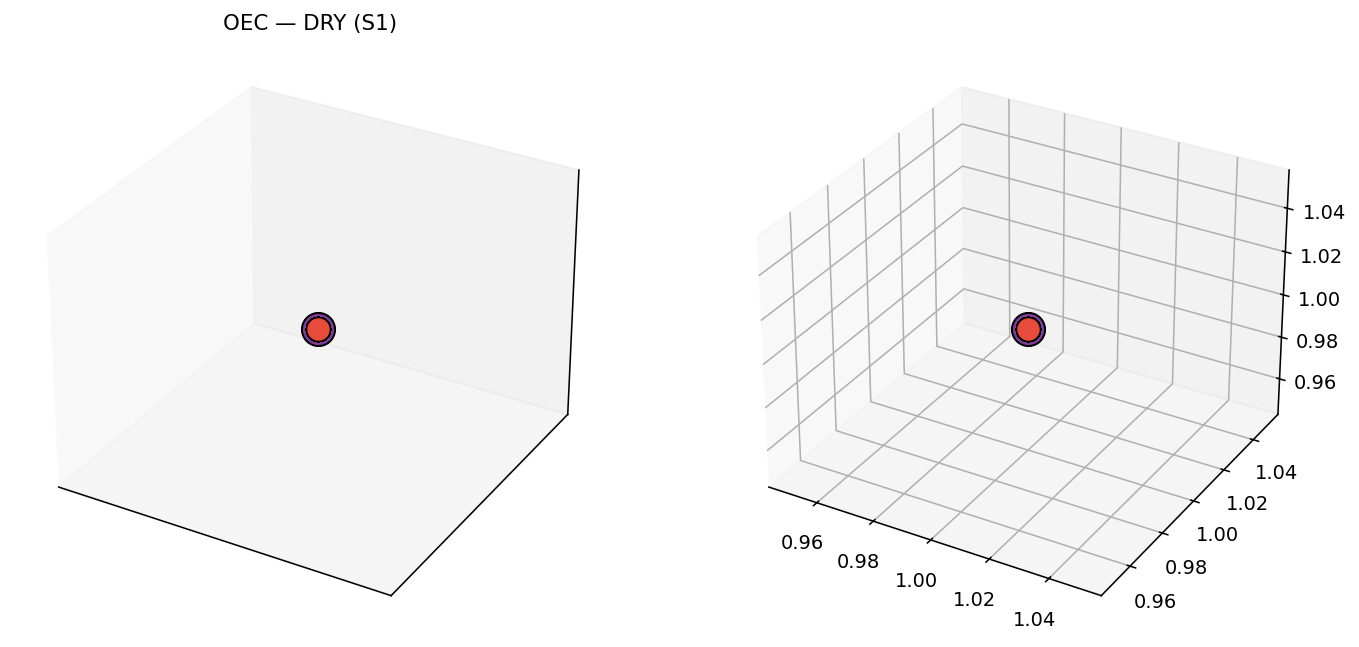

In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM PANEL
# Works with CIF (e.g., 3WU2.cif) or PDB
# No external libs; pure Python + NumPy + Matplotlib
# ==============================================
import os, math, shlex
import numpy as np
import matplotlib.pyplot as plt

# ---------- USER SETTINGS ----------
PDB_PATH = "3WU2.cif"   # upload first (Colab sidebar)
OUT_MAIN = "OEC_S1_DRY_vs_HYDRATED.png"
OUT_ZOOM = "OEC_S1_HYDRATED_ZOOM.png"
TITLE_L  = "OEC — DRY (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"
ZOOM_RADIUS = 4.0       # Å; crop radius around metal centroid for the zoom panel

# ---------- UTILS ----------
def centroid(coords):
    a = np.array([[x,y,z] for (_,x,y,z,_) in coords], float)
    return a.mean(axis=0) if len(a) else np.array([0.0,0.0,0.0])

def dist(a,b):
    a,b = np.array(a), np.array(b)
    return float(np.linalg.norm(a-b))

def set_equal_3d(ax, pts):
    arr = np.array(pts)
    x,y,z = arr[:,0],arr[:,1],arr[:,2]
    cx,cy,cz = x.mean(),y.mean(),z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, center, radius):
    cx,cy,cz = center
    r = float(radius)
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

# ---------- PDB PARSER (fallback) ----------
def parse_pdb(path):
    atoms = []
    with open(path, "r") as fh:
        for line in fh:
            if not line.startswith(("ATOM", "HETATM")):
                continue
            # PDB fixed columns (tolerant)
            elem = line[76:78].strip() or line[12:14].strip()
            resn = line[17:20].strip() or "UNK"
            try:
                x = float(line[30:38]); y = float(line[38:46]); z = float(line[46:54])
            except:
                parts = line.split()
                floats = []
                for p in parts:
                    try:
                        floats.append(float(p))
                        if len(floats)==3: break
                    except: pass
                if len(floats)<3: continue
                x,y,z = floats[:3]
            atoms.append((elem.upper(), x, y, z, dict(resName=resn)))
    return atoms

# ---------- mmCIF PARSER (robust) ----------
def parse_cif_atom_site(path):
    """
    Minimal mmCIF atom_site loop parser:
    pulls _atom_site.type_symbol, Cartn_x/y/z, label_comp_id, (optional) group_PDB
    """
    with open(path, "r") as fh:
        lines = fh.readlines()

    atoms = []
    i = 0
    n = len(lines)
    while i < n:
        line = lines[i].strip()
        if line.lower().startswith("loop_"):
            i += 1
            headers = []
            while i < n and lines[i].strip().startswith("_"):
                headers.append(lines[i].strip())
                i += 1
            # atom_site block?
            if not any(h.lower().startswith("_atom_site.") for h in headers):
                # skip data rows of this unrelated loop
                while i < n and not lines[i].strip().lower().startswith(("loop_","data_","_")):
                    i += 1
                continue

            # indices
            def find(hkey):
                for k,h in enumerate(headers):
                    if h.lower()==hkey:
                        return k
                return -1

            idx_type   = find("_atom_site.type_symbol")
            idx_x      = find("_atom_site.Cartn_x")
            idx_y      = find("_atom_site.Cartn_y")
            idx_z      = find("_atom_site.Cartn_z")
            idx_comp   = find("_atom_site.label_comp_id")
            idx_group  = find("_atom_site.group_PDB")

            # ingest rows until next loop_/data_/header
            while i < n:
                s = lines[i].strip()
                if (not s) or s.lower().startswith(("loop_","data_")) or s.startswith("_"):
                    break
                # tokenise (handles quoted CIF fields)
                toks = shlex.split(s)
                # mmCIF rows can continue across lines; try to read multiple lines until count matches headers
                j = i + 1
                while len(toks) < len(headers) and j < n and not lines[j].strip().lower().startswith(("loop_","data_")) and not lines[j].strip().startswith("_"):
                    toks += shlex.split(lines[j].strip())
                    j += 1
                i = j - 1  # last consumed line index

                try:
                    elem = toks[idx_type] if idx_type>=0 else ""
                    x    = float(toks[idx_x]); y = float(toks[idx_y]); z = float(toks[idx_z])
                except Exception:
                    i += 1
                    continue
                resn = toks[idx_comp] if idx_comp>=0 else "UNK"
                grp  = toks[idx_group] if idx_group>=0 else ""
                atoms.append((elem.upper(), x, y, z, dict(resName=resn, group=grp)))
                i += 1
            continue
        i += 1
    return atoms

def parse_structure(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    ext = os.path.splitext(path)[1].lower()
    if ext == ".cif":
        atoms = parse_cif_atom_site(path)
        if not atoms:
            # fallback scan (very rare)
            print("mmCIF atom_site parsing returned 0 atoms; trying PDB fallback parse…")
            atoms = parse_pdb(path)
        return atoms
    else:
        return parse_pdb(path)

# ---------- LOAD ----------
atoms_all = parse_structure(PDB_PATH)
print(f"Parsed {len(atoms_all)} atoms from {PDB_PATH}")

# quick diagnostics
from collections import Counter
elem_counts = Counter([a[0] for a in atoms_all])
print("Element counts (top 20):", elem_counts.most_common(20))

# pick metals (case-insensitive element symbols)
mn = [a for a in atoms_all if a[0] in ("MN","Mn","mn")]
ca = [a for a in atoms_all if a[0] in ("CA","Ca","ca")]

if not mn or not ca:
    raise RuntimeError(
        "Could not find Mn or Ca atoms in structure.\n"
        f"Seen elements: {sorted(elem_counts.keys())[:30]}\n"
        "Tip: ensure 3WU2.cif is the *protein* file with cofactors, not a map.\n"
    )

mn_cent = centroid(mn)
# closest Ca to Mn centroid
ca_sorted = sorted(ca, key=lambda a: dist((a[1],a[2],a[3]), mn_cent))
ca1 = [ca_sorted[0]]
# 4 closest Mn to Mn centroid (OEC core)
mn_sorted = sorted(mn, key=lambda a: dist((a[1],a[2],a[3]), mn_cent))[:4]
core_metals = ca1 + mn_sorted

# non-water O near metals (bond-like)
o_nonwat = [a for a in atoms_all
            if a[0] in ("O","OW","O1","O2") and a[4].get("resName","").upper() not in ("HOH","WAT","H2O","W","DOD")]
OEC_O = []
for o in o_nonwat:
    if any(dist((o[1],o[2],o[3]), (m[1],m[2],m[3])) <= 2.2 for m in core_metals):
        OEC_O.append(o)
DRY = core_metals + OEC_O

# waters near metals (≤ 3.0 Å): take 4 nearest as W1–W4
waters = [a for a in atoms_all
          if a[0] in ("O","OW") and a[4].get("resName","").upper() in ("HOH","WAT","H2O","DOD","W")]
near_w = []
for w in waters:
    dmin = min(dist((w[1],w[2],w[3]), (m[1],m[2],m[3])) for m in core_metals)
    if dmin <= 3.0:
        near_w.append((w, dmin))
near_w.sort(key=lambda t: t[1])
W_sel = [t[0] for t in near_w[:4]]

def sort_by_ca(ws, ca_atom):
    pca=(ca_atom[1], ca_atom[2], ca_atom[3])
    return sorted(ws, key=lambda w: dist((w[1],w[2],w[3]), pca))

W_sorted = sort_by_ca(W_sel, ca1[0])
W_labels = {id(w):f"W{i+1}" for i,w in enumerate(W_sorted)}
HYD = DRY + W_sorted

print("Selected W1–W4 (nearest to Ca):")
for w in W_sorted:
    print(W_labels[id(w)], w[4].get("resName",""), f"({w[1]:.2f}, {w[2]:.2f}, {w[3]:.2f})")

# ---------- BONDING RULES ----------
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.0

def bonds(atoms):
    pairs=[]; xyz=[(a[1],a[2],a[3]) for a in atoms]; els=[a[0].upper() for a in atoms]
    for i in range(len(atoms)):
        for j in range(i+1,len(atoms)):
            d_ij=dist(xyz[i],xyz[j]); e_i,e_j=els[i],els[j]
            if (e_i in ("MN","CA") and e_j in ("MN","CA")) and d_ij <= THR_MM:
                pairs.append((i,j))
            elif {"MN","O"} == {e_i,e_j} and d_ij <= THR_MN_O:
                pairs.append((i,j))
            elif {"CA","O"} == {e_i,e_j} and d_ij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

# ---------- PLOTTING ----------
COLORS = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
SIZES  = {"MN":280, "CA":300, "O":150}

def plot_cluster(ax, atoms, wlabels=None, title="", equal=True):
    pts=[]
    for a in atoms:
        e,x,y,z,m = a; E=e.upper()
        c = COLORS.get(E if E in COLORS else ("O" if E.startswith("O") else "gray"), "gray")
        s = SIZES.get(E if E in SIZES else ("O" if E.startswith("O") else 80), 80)
        ax.scatter([x],[y],[z], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append((x,y,z))
        if wlabels and id(a) in wlabels:
            ax.text(x, y, z+0.35, wlabels[id(a)], fontsize=10, weight="bold", color="black")
    for i,j in bonds(atoms):
        xi,yi,zi = atoms[i][1:4]; xj,yj,zj = atoms[j][1:4]
        ax.plot([xi,xj],[yi,yj],[zi,zj], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal and pts:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Figure 1: DRY vs HYDRATED
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, equal=True)
plot_cluster(ax2, HYD, wlabels={id(a):W_labels.get(id(a)) for a in HYD}, title=TITLE_R, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

# Figure 2: HYDRATED ZOOM close-up (fixed limits around metal centroid)
metal_centroid = centroid(core_metals)
fig2 = plt.figure(figsize=(7.4,7.0))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, wlabels={id(a):W_labels.get(id(a)) for a in HYD}, title=TITLE_Z, equal=False)
set_zoom_3d(axZ, metal_centroid, ZOOM_RADIUS)
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM
# FAST version using gemmi (recommended for CIF/PDB)
# ==============================================
!pip -q install gemmi

import gemmi
import numpy as np
import matplotlib.pyplot as plt
import os, math

# ----------- USER SETTINGS -----------
CIF_FILE   = "3WU2.cif"   # upload this in Colab sidebar
ZOOM_RADIUS = 4.0         # Å around metal centroid for zoom panel
OUT_MAIN   = "OEC_S1_DRY_vs_HYDRATED_gemmi.png"
OUT_ZOOM   = "OEC_S1_HYDRATED_ZOOM_gemmi.png"

TITLE_L  = "OEC — DRY (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"

# ---------- helpers ----------
def v3(u):  # gemmi Vec3 -> numpy
    return np.array([u.x, u.y, u.z], float)

def centroid(points):
    arr = np.vstack(points) if len(points) else np.zeros((1,3))
    return arr.mean(axis=0)

def set_equal_3d(ax, pts):
    arr = np.array(pts)
    if arr.size == 0:
        return
    x,y,z = arr[:,0], arr[:,1], arr[:,2]
    cx,cy,cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, c, r):
    cx,cy,cz = c
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

# ---------- load structure (fast) ----------
st = gemmi.read_structure(CIF_FILE)
model = st[0]  # first model
cs = st.cell  # unit cell

# Build atom list with element, position, residue name
atoms = []
for chain in model:
    for res in chain:
        rn = res.name.upper()
        for at in res:
            el = at.element.name.upper()
            pos = at.pos
            atoms.append(dict(el=el, rn=rn, pos=pos, chain=chain.name, res=res.seqid))

print(f"Parsed atoms: {len(atoms)} (fast)")

# ---------- find Mn and Ca (OEC) ----------
mn_atoms = [a for a in atoms if a['el'] == 'MN']
ca_atoms = [a for a in atoms if a['el'] == 'CA']
if not mn_atoms or not ca_atoms:
    raise RuntimeError("No Mn or Ca found. Ensure 3WU2.cif is the PSII model with OEC metals.")

mn_cent = centroid([v3(a['pos']) for a in mn_atoms])

# pick Ca closest to Mn centroid
ca_atoms_sorted = sorted(ca_atoms, key=lambda a: np.linalg.norm(v3(a['pos']) - mn_cent))
ca_sel = ca_atoms_sorted[0]
# pick 4 Mn closest to Mn centroid (OEC core)
mn_atoms_sorted = sorted(mn_atoms, key=lambda a: np.linalg.norm(v3(a['pos']) - mn_cent))[:4]
core_metals = [ca_sel] + mn_atoms_sorted
core_pts = [v3(a['pos']) for a in core_metals]
core_cent = centroid(core_pts)

# ---------- collect nearby O atoms ----------
# We'll spatially crop first to a 8 Å sphere to avoid scanning entire protein
ns = gemmi.NeighborSearch(st, st.cell, max_dist=8.0).populate(include_h=False)
near_o = []
for m in core_metals:
    for nb in ns.find_atoms(m['pos'], max_dist=2.4):  # Mn/CA–O bonds likely <~2.4-2.6
        a = nb.atom
        el = a.element.name.upper()
        if el.startswith('O'):
            resname = a.residue.name.upper()
            near_o.append(dict(el=el, rn=resname, pos=a.pos))
# unique-ish by coordinates
uniq = {}
for a in near_o:
    key = tuple(np.round(v3(a['pos']), 3))
    uniq[key] = a
o_bridge = list(uniq.values())

# ---------- waters near the core ----------
waters = []
for nb in ns.find_atoms(gemmi.Position(*core_cent), max_dist=3.2):  # within 3.2 Å of centroid region
    a = nb.atom
    if a.element.name.upper().startswith('O'):
        rn = a.residue.name.upper()
        if rn in ('HOH','WAT','H2O','DOD','W'):
            waters.append(dict(el='O', rn=rn, pos=a.pos))

# rank waters by distance to Ca (conventional to anchor on Ca)
def d_to_ca(w):
    return float((v3(w['pos']) - v3(ca_sel['pos'])) @ (v3(w['pos']) - v3(ca_sel['pos'])))**0.5
waters_sorted = sorted(waters, key=d_to_ca)[:4]  # W1..W4
W_labels = {i: f"W{i+1}" for i in range(len(waters_sorted))}

print("Core metals:", len(core_metals), "| bridging O:", len(o_bridge), "| waters (chosen):", len(waters_sorted))

# ---------- prepare sets ----------
DRY = core_metals + o_bridge
HYD = DRY + waters_sorted

# ---------- bonding heuristics ----------
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.2

def bond_pairs(group):
    pts = [v3(a['pos']) for a in group]
    els = [a['el'] for a in group]
    pairs = []
    n = len(group)
    for i in range(n):
        for j in range(i+1,n):
            dij = np.linalg.norm(pts[i]-pts[j])
            e_i, e_j = els[i], els[j]
            if (e_i in ("MN","CA") and e_j in ("MN","CA") and dij <= THR_MM):
                pairs.append((i,j))
            elif {"MN","O"} == {e_i,e_j} and dij <= THR_MN_O:
                pairs.append((i,j))
            elif {"CA","O"} == {e_i,e_j} and dij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

# ---------- plotting ----------
COL = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
SIZ = {"MN":280, "CA":300, "O":150}

def plot_cluster(ax, group, title="", w_labels=None, equal=True):
    pts=[]
    for idx, a in enumerate(group):
        el = a['el'] if a['el'] in COL else ("O" if a['el'].startswith("O") else None)
        c  = COL.get(el, "gray")
        s  = SIZ.get(el, 80)
        p  = v3(a['pos'])
        ax.scatter([p[0]],[p[1]],[p[2]], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append(p)
        if w_labels and a in waters_sorted:
            wid = waters_sorted.index(a)
            ax.text(p[0], p[1], p[2]+0.35, w_labels.get(wid, ""), fontsize=10, weight="bold")
    # bonds
    for i,j in bond_pairs(group):
        pi = v3(group[i]['pos']); pj = v3(group[j]['pos'])
        ax.plot([pi[0],pj[0]],[pi[1],pj[1]],[pi[2],pj[2]], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal and pts:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Figure 1: DRY vs HYDRATED
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, w_labels=None, equal=True)
plot_cluster(ax2, HYD, title=TITLE_R, w_labels=W_labels, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

# Figure 2: HYDRATED ZOOM (fixed limits around metal centroid)
fig2 = plt.figure(figsize=(7.2,6.8))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, title=TITLE_Z, w_labels=W_labels, equal=False)
set_zoom_3d(axZ, centroid([v3(a['pos']) for a in core_metals]), ZOOM_RADIUS)
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

Parsed atoms: 54036 (fast)


TypeError: __init__(): incompatible function arguments. The following argument types are supported:
    1. __init__(self, model: gemmi.Model, cell: gemmi.UnitCell, max_radius: float) -> None
    2. __init__(self, st: gemmi.Structure, max_radius: float, model_index: int = 0) -> None
    3. __init__(self, small_structure: gemmi.SmallStructure, max_radius: float) -> None

Invoked with types: gemmi.NeighborSearch, gemmi.Structure, gemmi.UnitCell, kwargs = { max_dist: float }

In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM  (gemmi FAST, fixed NeighborSearch)
# ==============================================
!pip -q install gemmi

import gemmi
import numpy as np
import matplotlib.pyplot as plt

# ----------- USER SETTINGS -----------
CIF_FILE   = "3WU2.cif"   # upload this in Colab sidebar
ZOOM_RADIUS = 4.0         # Å around metal centroid for zoom panel
OUT_MAIN   = "OEC_S1_DRY_vs_HYDRATED_gemmi.png"
OUT_ZOOM   = "OEC_S1_HYDRATED_ZOOM_gemmi.png"

TITLE_L  = "OEC — DRY (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"

# ---------- helpers ----------
def v3(u):  # gemmi Vec3 -> numpy
    return np.array([u.x, u.y, u.z], float)

def centroid(points):
    arr = np.vstack(points) if len(points) else np.zeros((1,3))
    return arr.mean(axis=0)

def set_equal_3d(ax, pts):
    arr = np.array(pts)
    if arr.size == 0:
        return
    x,y,z = arr[:,0], arr[:,1], arr[:,2]
    cx,cy,cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, c, r):
    cx,cy,cz = c
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

# ---------- load structure ----------
st = gemmi.read_structure(CIF_FILE)
model = st[0]

# Flat list of atoms (element, residue name, position)
atoms = []
for chain in model:
    for res in chain:
        rn = res.name.upper()
        for at in res:
            atoms.append(dict(el=at.element.name.upper(), rn=rn, pos=at.pos,
                              chain=chain.name, res=res.seqid))

print(f"Parsed atoms: {len(atoms)} (fast)")

# ---------- find Mn and Ca (OEC) ----------
mn_atoms = [a for a in atoms if a['el'] == 'MN']
ca_atoms = [a for a in atoms if a['el'] == 'CA']
if not mn_atoms or not ca_atoms:
    raise RuntimeError("No Mn or Ca found. Ensure 3WU2.cif is the PSII model with OEC metals.")

mn_cent = centroid([v3(a['pos']) for a in mn_atoms])

# pick Ca closest to Mn centroid; pick 4 Mn closest (OEC core)
ca_sel = sorted(ca_atoms, key=lambda a: np.linalg.norm(v3(a['pos']) - mn_cent))[0]
mn_sel = sorted(mn_atoms, key=lambda a: np.linalg.norm(v3(a['pos']) - mn_cent))[:4]
core_metals = [ca_sel] + mn_sel
core_pts = [v3(a['pos']) for a in core_metals]
core_cent = centroid(core_pts)

# ---------- Neighbor search (correct API) ----------
# Option A (model+cell):
ns = gemmi.NeighborSearch(model, st.cell, 8.0)  # max_radius=8 Å
ns.populate(model)  # include_h not needed; we filter by element below

# ---------- collect nearby O atoms bridging metals ----------
near_o = []
for m in core_metals:
    for nb in ns.find_atoms(m['pos'], 2.6):  # within metal–O bond range
        a = nb.atom
        el = a.element.name.upper()
        if not el.startswith('O'):
            continue
        rn = a.residue.name.upper()
        # treat only non-water oxygens here
        if rn in ('HOH','WAT','H2O','DOD','W'):
            continue
        near_o.append(dict(el='O', rn=rn, pos=a.pos))

# de-duplicate by rounded coordinate
uniq = {}
for a in near_o:
    key = tuple(np.round(v3(a['pos']), 3))
    uniq[key] = a
o_bridge = list(uniq.values())

# ---------- waters near the core (choose 4 closest to Ca) ----------
waters = []
for nb in ns.find_atoms(gemmi.Position(*core_cent), 3.2):
    a = nb.atom
    if not a.element.name.upper().startswith('O'):
        continue
    rn = a.residue.name.upper()
    if rn not in ('HOH','WAT','H2O','DOD','W'):
        continue
    waters.append(dict(el='O', rn=rn, pos=a.pos))

def d_to_ca(w):
    dv = v3(w['pos']) - v3(ca_sel['pos'])
    return float(np.linalg.norm(dv))

waters_sorted = sorted(waters, key=d_to_ca)[:4]
W_labels = {i: f"W{i+1}" for i in range(len(waters_sorted))}

print("Core metals:", len(core_metals), "| bridging O:", len(o_bridge), "| waters (chosen):", len(waters_sorted))

# ---------- prepare sets ----------
DRY = core_metals + o_bridge
HYD = DRY + waters_sorted

# ---------- bonding heuristics ----------
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.2

def bond_pairs(group):
    pts = [v3(a['pos']) for a in group]
    els = [a['el'] for a in group]
    pairs = []
    n = len(group)
    for i in range(n):
        for j in range(i+1, n):
            dij = np.linalg.norm(pts[i]-pts[j])
            e_i, e_j = els[i], els[j]
            if (e_i in ("MN","CA") and e_j in ("MN","CA") and dij <= THR_MM):
                pairs.append((i,j))
            elif {"MN","O"} == {e_i,e_j} and dij <= THR_MN_O:
                pairs.append((i,j))
            elif {"CA","O"} == {e_i,e_j} and dij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

# ---------- plotting ----------
COL = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
SIZ = {"MN":280, "CA":300, "O":150}

def plot_cluster(ax, group, title="", w_labels=None, equal=True):
    pts=[]
    for idx, a in enumerate(group):
        el = a['el'] if a['el'] in COL else ("O" if a['el'].startswith("O") else None)
        c  = COL.get(el, "gray")
        s  = SIZ.get(el, 80)
        p  = v3(a['pos'])
        ax.scatter([p[0]],[p[1]],[p[2]], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append(p)
        if w_labels and a in waters_sorted:
            wid = waters_sorted.index(a)
            ax.text(p[0], p[1], p[2]+0.35, w_labels.get(wid, ""), fontsize=10, weight="bold")
    # bonds
    for i,j in bond_pairs(group):
        pi = v3(group[i]['pos']); pj = v3(group[j]['pos'])
        ax.plot([pi[0],pj[0]],[pi[1],pj[1]],[pi[2],pj[2]], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal and pts:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Figure 1: DRY vs HYDRATED
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, w_labels=None, equal=True)
plot_cluster(ax2, HYD, title=TITLE_R, w_labels=W_labels, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

# Figure 2: HYDRATED ZOOM (fixed limits around metal centroid)
fig2 = plt.figure(figsize=(7.2,6.8))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, title=TITLE_Z, w_labels=W_labels, equal=False)
set_zoom_3d(axZ, core_cent, ZOOM_RADIUS)
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

Parsed atoms: 54036 (fast)


TypeError: populate(): incompatible function arguments. The following argument types are supported:
    1. populate(self, include_h: bool = True) -> gemmi.NeighborSearch

Invoked with types: gemmi.NeighborSearch, gemmi.Model

In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM  (gemmi FAST, fixed populate signature)
# ==============================================
!pip -q install gemmi

import gemmi
import numpy as np
import matplotlib.pyplot as plt

# ----------- USER SETTINGS -----------
CIF_FILE   = "3WU2.cif"   # upload this in Colab sidebar
ZOOM_RADIUS = 4.0         # Å around metal centroid for zoom panel
OUT_MAIN   = "OEC_S1_DRY_vs_HYDRATED_gemmi.png"
OUT_ZOOM   = "OEC_S1_HYDRATED_ZOOM_gemmi.png"

TITLE_L  = "OEC — DRY (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"

# ---------- helpers ----------
def v3(u):  # gemmi Vec3 -> numpy
    return np.array([u.x, u.y, u.z], float)

def centroid(points):
    arr = np.vstack(points) if len(points) else np.zeros((1,3))
    return arr.mean(axis=0)

def set_equal_3d(ax, pts):
    arr = np.array(pts)
    if arr.size == 0:
        return
    x,y,z = arr[:,0], arr[:,1], arr[:,2]
    cx,cy,cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, c, r):
    cx,cy,cz = c
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

# ---------- load structure ----------
st = gemmi.read_structure(CIF_FILE)
model = st[0]

# Flat list of atoms (element, residue name, position)
atoms = []
for chain in model:
    for res in chain:
        rn = res.name.upper()
        for at in res:
            atoms.append(dict(el=at.element.name.upper(), rn=rn, pos=at.pos,
                              chain=chain.name, res=res.seqid))

print(f"Parsed atoms: {len(atoms)} (fast)")

# ---------- find Mn and Ca (OEC) ----------
mn_atoms = [a for a in atoms if a['el'] == 'MN']
ca_atoms = [a for a in atoms if a['el'] == 'CA']
if not mn_atoms or not ca_atoms:
    raise RuntimeError("No Mn or Ca found. Ensure 3WU2.cif is the PSII model with OEC metals.")

mn_cent = centroid([v3(a['pos']) for a in mn_atoms])

# pick Ca closest to Mn centroid; pick 4 Mn closest (OEC core)
ca_sel = sorted(ca_atoms, key=lambda a: np.linalg.norm(v3(a['pos']) - mn_cent))[0]
mn_sel = sorted(mn_atoms, key=lambda a: np.linalg.norm(v3(a['pos']) - mn_cent))[:4]
core_metals = [ca_sel] + mn_sel
core_pts = [v3(a['pos']) for a in core_metals]
core_cent = centroid(core_pts)

# ---------- Neighbor search (correct API/signature) ----------
ns = gemmi.NeighborSearch(model, st.cell, 8.0)  # max_radius=8 Å
ns.populate(False)  # include_h=False

# ---------- collect nearby O atoms bridging metals ----------
near_o = []
for m in core_metals:
    for nb in ns.find_atoms(m['pos'], 2.6):  # within metal–O bond range
        a = nb.atom
        el = a.element.name.upper()
        if not el.startswith('O'):
            continue
        rn = a.residue.name.upper()
        # treat only non-water oxygens here
        if rn in ('HOH','WAT','H2O','DOD','W'):
            continue
        near_o.append(dict(el='O', rn=rn, pos=a.pos))

# de-duplicate by rounded coordinate
uniq = {}
for a in near_o:
    key = tuple(np.round(v3(a['pos']), 3))
    uniq[key] = a
o_bridge = list(uniq.values())

# ---------- waters near the core (choose 4 closest to Ca) ----------
waters = []
for nb in ns.find_atoms(gemmi.Position(*core_cent), 3.2):
    a = nb.atom
    if not a.element.name.upper().startswith('O'):
        continue
    rn = a.residue.name.upper()
    if rn not in ('HOH','WAT','H2O','DOD','W'):
        continue
    waters.append(dict(el='O', rn=rn, pos=a.pos))

def d_to_ca(w):
    dv = v3(w['pos']) - v3(ca_sel['pos'])
    return float(np.linalg.norm(dv))

waters_sorted = sorted(waters, key=d_to_ca)[:4]
W_labels = {i: f"W{i+1}" for i in range(len(waters_sorted))}

print("Core metals:", len(core_metals), "| bridging O:", len(o_bridge), "| waters (chosen):", len(waters_sorted))

# ---------- prepare sets ----------
DRY = core_metals + o_bridge
HYD = DRY + waters_sorted

# ---------- bonding heuristics ----------
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.2

def bond_pairs(group):
    pts = [v3(a['pos']) for a in group]
    els = [a['el'] for a in group]
    pairs = []
    n = len(group)
    for i in range(n):
        for j in range(i+1, n):
            dij = np.linalg.norm(pts[i]-pts[j])
            e_i, e_j = els[i], els[j]
            if (e_i in ("MN","CA") and e_j in ("MN","CA") and dij <= THR_MM):
                pairs.append((i,j))
            elif {"MN","O"} == {e_i,e_j} and dij <= THR_MN_O:
                pairs.append((i,j))
            elif {"CA","O"} == {e_i,e_j} and dij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

# ---------- plotting ----------
COL = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
SIZ = {"MN":280, "CA":300, "O":150}

def plot_cluster(ax, group, title="", w_labels=None, equal=True):
    pts=[]
    for idx, a in enumerate(group):
        el = a['el'] if a['el'] in COL else ("O" if a['el'].startswith("O") else None)
        c  = COL.get(el, "gray")
        s  = SIZ.get(el, 80)
        p  = v3(a['pos'])
        ax.scatter([p[0]],[p[1]],[p[2]], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append(p)
        if w_labels and a in waters_sorted:
            wid = waters_sorted.index(a)
            ax.text(p[0], p[1], p[2]+0.35, w_labels.get(wid, ""), fontsize=10, weight="bold")
    # bonds
    for i,j in bond_pairs(group):
        pi = v3(group[i]['pos']); pj = v3(group[j]['pos'])
        ax.plot([pi[0],pj[0]],[pi[1],pj[1]],[pi[2],pj[2]], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal and pts:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Figure 1: DRY vs HYDRATED
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, w_labels=None, equal=True)
plot_cluster(ax2, HYD, title=TITLE_R, w_labels=W_labels, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

# Figure 2: HYDRATED ZOOM (fixed limits around metal centroid)
fig2 = plt.figure(figsize=(7.2,6.8))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, title=TITLE_Z, w_labels=W_labels, equal=False)
set_zoom_3d(axZ, core_cent, ZOOM_RADIUS)
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

Parsed atoms: 54036 (fast)


TypeError: find_atoms(): incompatible function arguments. The following argument types are supported:
    1. find_atoms(self, pos: gemmi.Position, alt: str = '\x00', *, min_dist: float = 0, radius: float = 0) -> gemmi.VectorMarkPtr

Invoked with types: gemmi.NeighborSearch, gemmi.Position, float

In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM PANEL
# File: 3wu2.cif (upload via Colab sidebar)
# Dependencies: gemmi (pip install gemmi), numpy, matplotlib
# ==============================================
!pip -q install gemmi

import os, math
import numpy as np
import matplotlib.pyplot as plt
import gemmi

# ---------- USER SETTINGS ----------
CIF_PATH = "3WU2.cif"   # upload first (Colab Files sidebar)
OUT_MAIN = "OEC_S1_DRY_vs_HYDRATED.png"
OUT_ZOOM = "OEC_S1_HYDRATED_ZOOM.png"
TITLE_L  = "OEC — DRY core (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"
ZOOM_RADIUS = 4.0       # Å; crop radius around metal centroid for the zoom panel

# Bond cutoffs (Å)
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.0

# ---------- helpers ----------
def set_equal_3d(ax, pts):
    arr = np.asarray(pts, float)
    x,y,z = arr[:,0], arr[:,1], arr[:,2]
    cx,cy,cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, center, radius):
    cx,cy,cz = center
    r = float(radius)
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def bonds(atoms):
    """Return index-pairs (i,j) for bonds among given atoms using simple cutoffs."""
    pairs=[]; xyz=[a['xyz'] for a in atoms]; els=[a['el'] for a in atoms]
    def dist(a,b): return float(np.linalg.norm(np.array(a)-np.array(b)))
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            d_ij = dist(xyz[i], xyz[j]); ei, ej = els[i], els[j]
            if (ei in ('MN','CA') and ej in ('MN','CA')) and d_ij <= THR_MM:
                pairs.append((i,j))
            elif {'MN','O'} == {ei,ej} and d_ij <= THR_MN_O:
                pairs.append((i,j))
            elif {'CA','O'} == {ei,ej} and d_ij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

def plot_cluster(ax, atoms, wlabels=None, title="", equal=True):
    COLORS = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
    SIZES  = {"MN":280, "CA":300, "O":150}
    pts=[]
    for a in atoms:
        E = a['el']
        x,y,z = a['xyz']
        c = COLORS.get(E, "gray"); s = SIZES.get(E, 80)
        ax.scatter([x],[y],[z], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append((x,y,z))
        if wlabels and a.get('wid'):
            ax.text(x, y, z+0.25, a['wid'], fontsize=10, color="black")
    for i,j in bonds(atoms):
        xi,yi,zi = atoms[i]['xyz']; xj,yj,zj = atoms[j]['xyz']
        ax.plot([xi,xj],[yi,yj],[zi,zj], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal and pts:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# ---------- load structure (Gemmi) ----------
if not os.path.exists(CIF_PATH):
    raise FileNotFoundError(f"Upload {CIF_PATH} first.")
st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

# collect atoms (fast list for backup counts)
atoms_fast = []
for ch in model:
    for res in ch:
        for a in res:
            atoms_fast.append(a)
print(f"Parsed atoms: {len(atoms_fast)} (fast)")

# ---------- find OEC metals: 4 Mn near each other + 1 Ca ----------
mn_atoms = [a for a in atoms_fast if a.element.name.upper() == 'MN']
ca_atoms = [a for a in atoms_fast if a.element.name.upper() == 'CA']
if not mn_atoms or not ca_atoms:
    raise RuntimeError("Could not find Mn or Ca atoms — check file or element parsing.")

mn_pos = np.array([[a.pos.x, a.pos.y, a.pos.z] for a in mn_atoms])
mn_centroid = mn_pos.mean(axis=0)
mn_sorted = sorted(mn_atoms, key=lambda a: np.linalg.norm(np.array([a.pos.x,a.pos.y,a.pos.z]) - mn_centroid))[:4]
ca_sorted = sorted(ca_atoms, key=lambda a: np.linalg.norm(np.array([a.pos.x,a.pos.y,a.pos.z]) - mn_centroid))
ca1 = ca_sorted[0]

core_metals = (
    [{'el':'CA','xyz':(ca1.pos.x,ca1.pos.y,ca1.pos.z), 'atom':ca1}] +
    [{'el':'MN','xyz':(a.pos.x,a.pos.y,a.pos.z), 'atom':a} for a in mn_sorted]
)

core_cent = np.mean(np.array([c['xyz'] for c in core_metals]), axis=0)

# ---------- Neighbor search (Gemmi API change: use keyword radius=...) ----------
ns = gemmi.NeighborSearch(model, st.cell, 8.0)  # max_radius=8 Å
ns.populate()  # include_h default True; we filtered hydrogens above

# ---------- collect bridging O near metals (exclude waters) ----------
near_o = []
for m in core_metals:
    for nb in ns.find_atoms(gemmi.Position(*m['xyz']), radius=2.6):  # <-- FIXED
        a = nb.atom
        el = a.element.name.upper()
        if not el.startswith('O'):
            continue
        rn = a.residue.name.upper()
        if rn in ('HOH','WAT','H2O','DOD','W'):
            continue
        near_o.append({'el':'O', 'xyz':(a.pos.x,a.pos.y,a.pos.z), 'atom':a})

# de-duplicate close O’s (≤0.3 Å)
def uniq_atoms(items, tol=0.3):
    uniq=[]
    for it in items:
        p = np.array(it['xyz'])
        if not any(np.linalg.norm(p - np.array(u['xyz'])) <= tol for u in uniq):
            uniq.append(it)
    return uniq
near_o = uniq_atoms(near_o)

# ---------- collect waters near the core centroid and pick 4 closest ----------
waters = []
for nb in ns.find_atoms(gemmi.Position(*core_cent), radius=3.2):  # <-- FIXED
    a = nb.atom
    if not a.element.name.upper().startswith('O'):
        continue
    rn = a.residue.name.upper()
    if rn not in ('HOH','WAT','H2O','DOD','W'):
        continue
    waters.append({'el':'O', 'xyz':(a.pos.x,a.pos.y,a.pos.z), 'atom':a})
# sort waters by distance to Ca
def d_ca(w):
    return float(np.linalg.norm(np.array(w['xyz']) - np.array(core_metals[0]['xyz'])))
waters_sorted = sorted(uniq_atoms(waters), key=d_ca)[:4]
for i,w in enumerate(waters_sorted,1):
    w['wid'] = f"W{i}"

# ---------- assemble DRY/HYDRATED selections ----------
DRY = core_metals + near_o
HYD = DRY + waters_sorted

print(f"Core metals: {len(core_metals)}  | bridging O: {len(near_o)}  | waters (W1–W4): {len(waters_sorted)}")
if len(waters_sorted) < 4:
    print("Note: fewer than 4 waters found within 3.2 Å of the core centroid in this file.")

# ---------- PLOTTING ----------
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, equal=True)
plot_cluster(ax2, HYD, title=TITLE_R, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

# Zoom panel on hydrated core
fig2 = plt.figure(figsize=(6.8,6.4))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, title=TITLE_Z, equal=False)
set_zoom_3d(axZ, core_cent, ZOOM_RADIUS)
# annotate waters
for w in waters_sorted:
    x,y,z = w['xyz']
    axZ.text(x, y, z+0.25, w['wid'], fontsize=10, color="black")
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

Parsed atoms: 54036 (fast)


AttributeError: 'gemmi.Mark' object has no attribute 'atom'

In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM PANEL
# File: 3WU2.cif  (upload exactly with this name/case)
# Dependencies: gemmi, numpy, matplotlib
# ==============================================
!pip -q install gemmi

import os, math
import numpy as np
import matplotlib.pyplot as plt
import gemmi

# ---------- USER SETTINGS ----------
CIF_PATH = "3WU2.cif"   # exact case-sensitive filename
OUT_MAIN = "OEC_S1_DRY_vs_HYDRATED.png"
OUT_ZOOM = "OEC_S1_HYDRATED_ZOOM.png"
TITLE_L  = "OEC — DRY core (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"
ZOOM_RADIUS = 4.0       # Å; crop radius around metal centroid for the zoom panel

# Bond cutoffs (Å)
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.0

# ---------- helpers ----------
def set_equal_3d(ax, pts):
    arr = np.asarray(pts, float)
    x,y,z = arr[:,0], arr[:,1], arr[:,2]
    cx,cy,cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, center, radius):
    cx,cy,cz = center
    r = float(radius)
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def bonds(atoms):
    """Return index-pairs (i,j) for bonds among given atoms using simple cutoffs."""
    pairs=[]; xyz=[a['xyz'] for a in atoms]; els=[a['el'] for a in atoms]
    def dist(a,b): return float(np.linalg.norm(np.array(a)-np.array(b)))
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            d_ij = dist(xyz[i], xyz[j]); ei, ej = els[i], els[j]
            if (ei in ('MN','CA') and ej in ('MN','CA')) and d_ij <= THR_MM:
                pairs.append((i,j))
            elif {'MN','O'} == {ei,ej} and d_ij <= THR_MN_O:
                pairs.append((i,j))
            elif {'CA','O'} == {ei,ej} and d_ij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

def plot_cluster(ax, atoms, title="", equal=True):
    COLORS = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
    SIZES  = {"MN":280, "CA":300, "O":150}
    pts=[]
    for a in atoms:
        E = a['el']
        x,y,z = a['xyz']
        c = COLORS.get(E, "gray"); s = SIZES.get(E, 80)
        ax.scatter([x],[y],[z], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append((x,y,z))
        if a.get('wid'):
            ax.text(x, y, z+0.25, a['wid'], fontsize=10, color="black")
    for i,j in bonds(atoms):
        xi,yi,zi = atoms[i]['xyz']; xj,yj,zj = atoms[j]['xyz']
        ax.plot([xi,xj],[yi,yj],[zi,zj], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal and pts:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def uniq_atoms(items, tol=0.3):
    uniq=[]
    for it in items:
        p = np.array(it['xyz'])
        if not any(np.linalg.norm(p - np.array(u['xyz'])) <= tol for u in uniq):
            uniq.append(it)
    return uniq

# ---------- load structure ----------
if not os.path.exists(CIF_PATH):
    raise FileNotFoundError(f"Upload {CIF_PATH} first (note case).")
st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

# flatten atoms into arrays (fast, no NeighborSearch)
els, pos, resn = [], [], []
for ch in model:
    for res in ch:
        rn = res.name.upper()
        for a in res:
            els.append(a.element.name.upper())
            pos.append([a.pos.x, a.pos.y, a.pos.z])
            resn.append(rn)
els = np.array(els, dtype=object)
pos = np.array(pos, dtype=float)
resn = np.array(resn, dtype=object)

# find Mn and Ca
mn_idx = np.where(els == 'MN')[0]
ca_idx = np.where(els == 'CA')[0]
if mn_idx.size == 0 or ca_idx.size == 0:
    raise RuntimeError("Could not find Mn or Ca atoms — check file or element parsing.")

mn_pos = pos[mn_idx]
mn_centroid = mn_pos.mean(axis=0)

# pick 4 Mn closest to Mn centroid
mn_d = np.linalg.norm(mn_pos - mn_centroid, axis=1)
mn_pick_idx = mn_idx[np.argsort(mn_d)[:4]]

# pick 1 Ca closest to Mn centroid
ca_pos = pos[ca_idx]
ca_d = np.linalg.norm(ca_pos - mn_centroid, axis=1)
ca_pick_idx = ca_idx[np.argsort(ca_d)[0]]

core_indices = [ca_pick_idx] + list(mn_pick_idx)
core_metals = []
for i in core_indices:
    core_metals.append({'el': els[i], 'xyz': tuple(pos[i])})

core_cent = np.mean(np.array([c['xyz'] for c in core_metals]), axis=0)

# ---------- bridging O (exclude waters) via NumPy distances ----------
is_oxygen = np.char.startswith(els, 'O') | (els == 'OW')
is_water  = np.isin(resn, ['HOH','WAT','H2O','DOD','W'])
o_nonwat_idx = np.where(is_oxygen & (~is_water))[0]
o_nonwat_pos = pos[o_nonwat_idx]

bridging = []
for m in core_metals:
    mpos = np.array(m['xyz'])
    d = np.linalg.norm(o_nonwat_pos - mpos, axis=1)
    # use appropriate cutoff for CA vs MN
    cutoff = THR_CA_O if m['el'] == 'CA' else THR_MN_O
    hits = np.where(d <= cutoff)[0]
    for h in hits:
        bridging.append({'el':'O', 'xyz': tuple(o_nonwat_pos[h])})

bridging = uniq_atoms(bridging, tol=0.30)

# ---------- waters near core centroid: pick 4 closest ----------
o_wat_idx = np.where(is_oxygen & is_water)[0]
o_wat_pos = pos[o_wat_idx]
d_w = np.linalg.norm(o_wat_pos - core_cent, axis=1)
order = np.argsort(d_w)
waters_sorted = []
for i,oi in enumerate(order[:8]):  # look at a few; we'll keep four after Ca proximity sort
    waters_sorted.append({'el':'O', 'xyz': tuple(o_wat_pos[oi])})

# relabel by closeness to Ca
def d_to_ca(w):
    return float(np.linalg.norm(np.array(w['xyz']) - np.array(core_metals[0]['xyz'])))
waters_sorted = sorted(uniq_atoms(waters_sorted), key=d_to_ca)[:4]
for i,w in enumerate(waters_sorted, 1):
    w['wid'] = f"W{i}"

# ---------- assemble DRY/HYDRATED ----------
DRY = core_metals + bridging
HYD = DRY + waters_sorted

print(f"Core metals: {len(core_metals)} | bridging O: {len(bridging)} | waters (W1–W4): {len(waters_sorted)}")
if len(waters_sorted) < 4:
    print("Note: fewer than 4 waters found near core centroid; file/resolution-dependent.")

# ---------- plot ----------
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, equal=True)
plot_cluster(ax2, HYD, title=TITLE_R, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

fig2 = plt.figure(figsize=(6.8,6.4))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, title=TITLE_Z, equal=False)
set_zoom_3d(axZ, core_cent, ZOOM_RADIUS)
for w in waters_sorted:
    x,y,z = w['xyz']
    axZ.text(x, y, z+0.25, w['wid'], fontsize=10, color="black")
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

UFuncTypeError: ufunc 'startswith' did not contain a loop with signature matching types (<class 'numpy.dtypes.ObjectDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyLongDType'>, <class 'numpy.dtypes._PyLongDType'>) -> None

Parsed atoms: 54036 (fast)
Core metals: 5 | bridging O: 13 | waters (W1–W4): 4


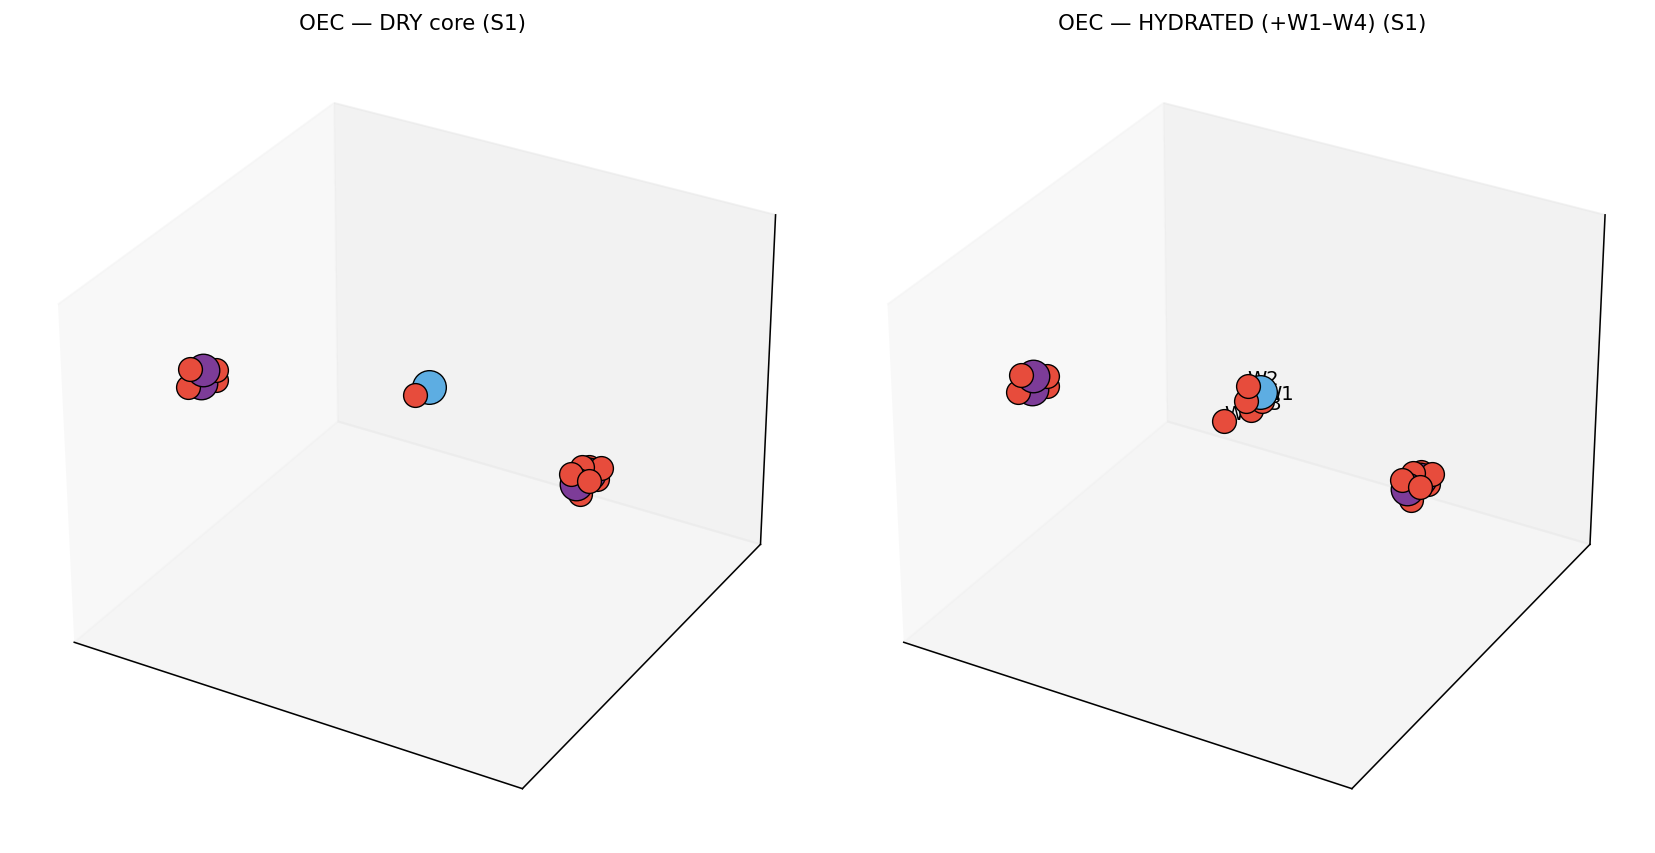

✅ Saved OEC_S1_DRY_vs_HYDRATED.png


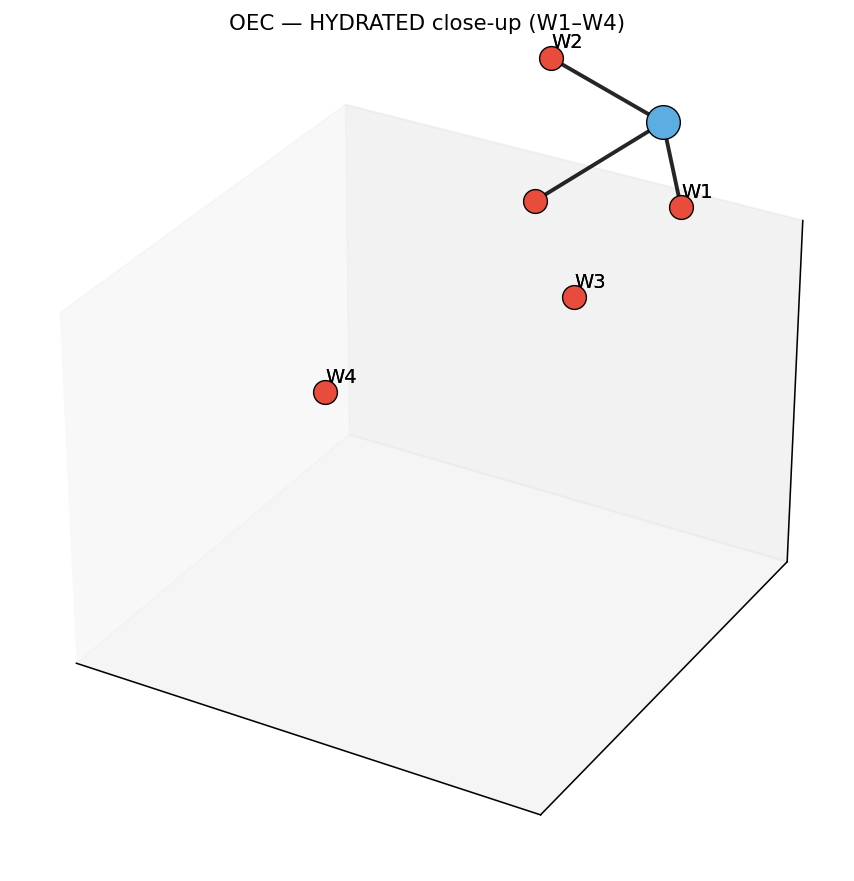

✅ Saved OEC_S1_HYDRATED_ZOOM.png


In [ ]:
# ==============================================
# PSII OEC (S1) — DRY vs HYDRATED + ZOOM PANEL
# File: 3WU2.cif  (upload with this exact name/case)
# Deps: gemmi, numpy, matplotlib
# ==============================================
!pip -q install gemmi

import os, math
import numpy as np
import matplotlib.pyplot as plt
import gemmi

# ---------- USER SETTINGS ----------
CIF_PATH = "3WU2.cif"   # case-sensitive filename
OUT_MAIN = "OEC_S1_DRY_vs_HYDRATED.png"
OUT_ZOOM = "OEC_S1_HYDRATED_ZOOM.png"
TITLE_L  = "OEC — DRY core (S1)"
TITLE_R  = "OEC — HYDRATED (+W1–W4) (S1)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"
ZOOM_RADIUS = 4.0       # Å

# Bond cutoffs (Å) — coarse but reasonable for this quick viz
THR_MN_O = 2.2
THR_CA_O = 2.6
THR_MM   = 3.0

# ---------- helpers ----------
def set_equal_3d(ax, pts):
    arr = np.asarray(pts, float)
    x,y,z = arr[:,0], arr[:,1], arr[:,2]
    cx,cy,cz = x.mean(), y.mean(), z.mean()
    r = max(np.ptp(x), np.ptp(y), np.ptp(z))*0.65 + 0.8
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, center, radius):
    cx,cy,cz = center
    r = float(radius)
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def bonds(atoms):
    """Return index-pairs (i,j) for bonds among given atoms using simple cutoffs."""
    pairs=[]; xyz=[a['xyz'] for a in atoms]; els=[a['el'] for a in atoms]
    def dist(a,b): return float(np.linalg.norm(np.array(a)-np.array(b)))
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            d_ij = dist(xyz[i], xyz[j]); ei, ej = els[i], els[j]
            if (ei in ('MN','CA') and ej in ('MN','CA')) and d_ij <= THR_MM:
                pairs.append((i,j))
            elif {'MN','O'} == {ei,ej} and d_ij <= THR_MN_O:
                pairs.append((i,j))
            elif {'CA','O'} == {ei,ej} and d_ij <= THR_CA_O:
                pairs.append((i,j))
    return pairs

def plot_cluster(ax, atoms, title="", equal=True):
    COLORS = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C"}
    SIZES  = {"MN":280, "CA":300, "O":150}
    pts=[]
    for a in atoms:
        E = a['el']
        x,y,z = a['xyz']
        c = COLORS.get(E, "gray"); s = SIZES.get(E, 80)
        ax.scatter([x],[y],[z], s=s, color=c, edgecolor="k", lw=0.7)
        pts.append((x,y,z))
        if a.get('wid'):
            ax.text(x, y, z+0.25, a['wid'], fontsize=10, color="black")
    for i,j in bonds(atoms):
        xi,yi,zi = atoms[i]['xyz']; xj,yj,zj = atoms[j]['xyz']
        ax.plot([xi,xj],[yi,yj],[zi,zj], color="k", lw=2, alpha=0.85)
    ax.set_title(title)
    if equal and pts:
        set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def uniq_atoms(items, tol=0.3):
    uniq=[]
    for it in items:
        p = np.array(it['xyz'])
        if not any(np.linalg.norm(p - np.array(u['xyz'])) <= tol for u in uniq):
            uniq.append(it)
    return uniq

# ---------- load structure ----------
if not os.path.exists(CIF_PATH):
    raise FileNotFoundError(f"Upload {CIF_PATH} first (note case).")
st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

# flatten atoms into arrays (fast)
els_list, pos_list, resn_list = [], [], []
for ch in model:
    for res in ch:
        rn = res.name.upper()
        for a in res:
            els_list.append(a.element.name.upper())
            pos_list.append([a.pos.x, a.pos.y, a.pos.z])
            resn_list.append(rn)

els = np.array(els_list, dtype=object)
pos = np.array(pos_list, dtype=float)
resn = np.array(resn_list, dtype=object)
print(f"Parsed atoms: {len(els)} (fast)")

# find Mn and Ca
mn_idx = np.where(els == 'MN')[0]
ca_idx = np.where(els == 'CA')[0]
if mn_idx.size == 0 or ca_idx.size == 0:
    raise RuntimeError("Could not find Mn or Ca atoms — check file or element parsing.")

mn_pos = pos[mn_idx]
mn_centroid = mn_pos.mean(axis=0)

# pick 4 Mn closest to Mn centroid
mn_d = np.linalg.norm(mn_pos - mn_centroid, axis=1)
mn_pick_idx = mn_idx[np.argsort(mn_d)[:4]]

# pick 1 Ca closest to Mn centroid
ca_pos = pos[ca_idx]
ca_d = np.linalg.norm(ca_pos - mn_centroid, axis=1)
ca_pick_idx = ca_idx[np.argsort(ca_d)[0]]

core_indices = [ca_pick_idx] + list(mn_pick_idx)
core_metals = [{'el': els[i], 'xyz': tuple(pos[i])} for i in core_indices]
core_cent = np.mean(np.array([c['xyz'] for c in core_metals]), axis=0)

# ---------- bridging O (exclude waters) via safe Python masks ----------
# FIX: avoid np.char.startswith on object arrays
is_oxygen = np.array([str(s).upper().startswith('O') or str(s).upper() == 'OW' for s in els], dtype=bool)
is_water  = np.array([str(r) in ('HOH','WAT','H2O','DOD','W') for r in resn], dtype=bool)

o_nonwat_idx = np.where(is_oxygen & (~is_water))[0]
o_nonwat_pos = pos[o_nonwat_idx]

bridging = []
for m in core_metals:
    mpos = np.array(m['xyz'])
    d = np.linalg.norm(o_nonwat_pos - mpos, axis=1)
    cutoff = THR_CA_O if m['el'] == 'CA' else THR_MN_O
    hits = np.where(d <= cutoff)[0]
    for h in hits:
        bridging.append({'el':'O', 'xyz': tuple(o_nonwat_pos[h])})

bridging = uniq_atoms(bridging, tol=0.30)

# ---------- waters near core centroid: pick 4 closest ----------
o_wat_idx = np.where(is_oxygen & is_water)[0]
o_wat_pos = pos[o_wat_idx]
d_w = np.linalg.norm(o_wat_pos - core_cent, axis=1)
order = np.argsort(d_w)

waters_sorted = []
for oi in order[:12]:  # consider a few near the core
    waters_sorted.append({'el':'O', 'xyz': tuple(o_wat_pos[oi])})
waters_sorted = uniq_atoms(waters_sorted)
# relabel by closeness to Ca
def d_to_ca(w):
    return float(np.linalg.norm(np.array(w['xyz']) - np.array(core_metals[0]['xyz'])))
waters_sorted = sorted(waters_sorted, key=d_to_ca)[:4]
for i,w in enumerate(waters_sorted, 1):
    w['wid'] = f"W{i}"

# ---------- assemble DRY/HYDRATED ----------
DRY = core_metals + bridging
HYD = DRY + waters_sorted

print(f"Core metals: {len(core_metals)} | bridging O: {len(bridging)} | waters (W1–W4): {len(waters_sorted)}")
if len(waters_sorted) < 4:
    print("Note: fewer than 4 waters found near core centroid; file/resolution-dependent.")

# ---------- plot ----------
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
plot_cluster(ax1, DRY, title=TITLE_L, equal=True)
plot_cluster(ax2, HYD, title=TITLE_R, equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print(f"✅ Saved {OUT_MAIN}")

fig2 = plt.figure(figsize=(6.8,6.4))
axZ = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, title=TITLE_Z, equal=False)
set_zoom_3d(axZ, core_cent, ZOOM_RADIUS)
for w in waters_sorted:
    x,y,z = w['xyz']
    axZ.text(x, y, z+0.25, w['wid'], fontsize=10, color="black")
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print(f"✅ Saved {OUT_ZOOM}")

Parsed atoms: 54036

== Metal positions ==
 Ca: [-10.595   3.213  38.941]
Mn1: [ 6.412 19.226 11.97 ]
Mn2: [ 7.251 21.814 12.94 ]
Mn3: [-27.578 -33.241  57.087]
Mn4: [-27.248 -33.273  60.042]
O5: [ 8.175 19.991 12.694]  (μ-oxo)

== Waters ==
W1: [-9.466  5.331 38.589]  d(Ca)=2.43 Å  d(Mn4)=47.61 Å
W2: [-10.523   3.812  36.578]  d(Ca)=2.44 Å  d(Mn4)=46.96 Å
W3: [-29.288 -29.917  60.771]  d(Ca)=43.86 Å  d(Mn4)=3.99 Å
W4: [-30.46  -30.798  58.399]  d(Ca)=43.93 Å  d(Mn4)=4.38 Å

== Check distances (Å) ==
 Ca  nearest μ-oxo:     -   nearest terminal:     -
Mn1  nearest μ-oxo: 2.053672320502958   nearest terminal:     -
Mn2  nearest μ-oxo: 2.0585482748772255   nearest terminal: 1.857650935994166
Mn3  nearest μ-oxo: 2.0905284021031614   nearest terminal:     -
Mn4  nearest μ-oxo: 2.0526339176774804   nearest terminal: 1.9299642483735275


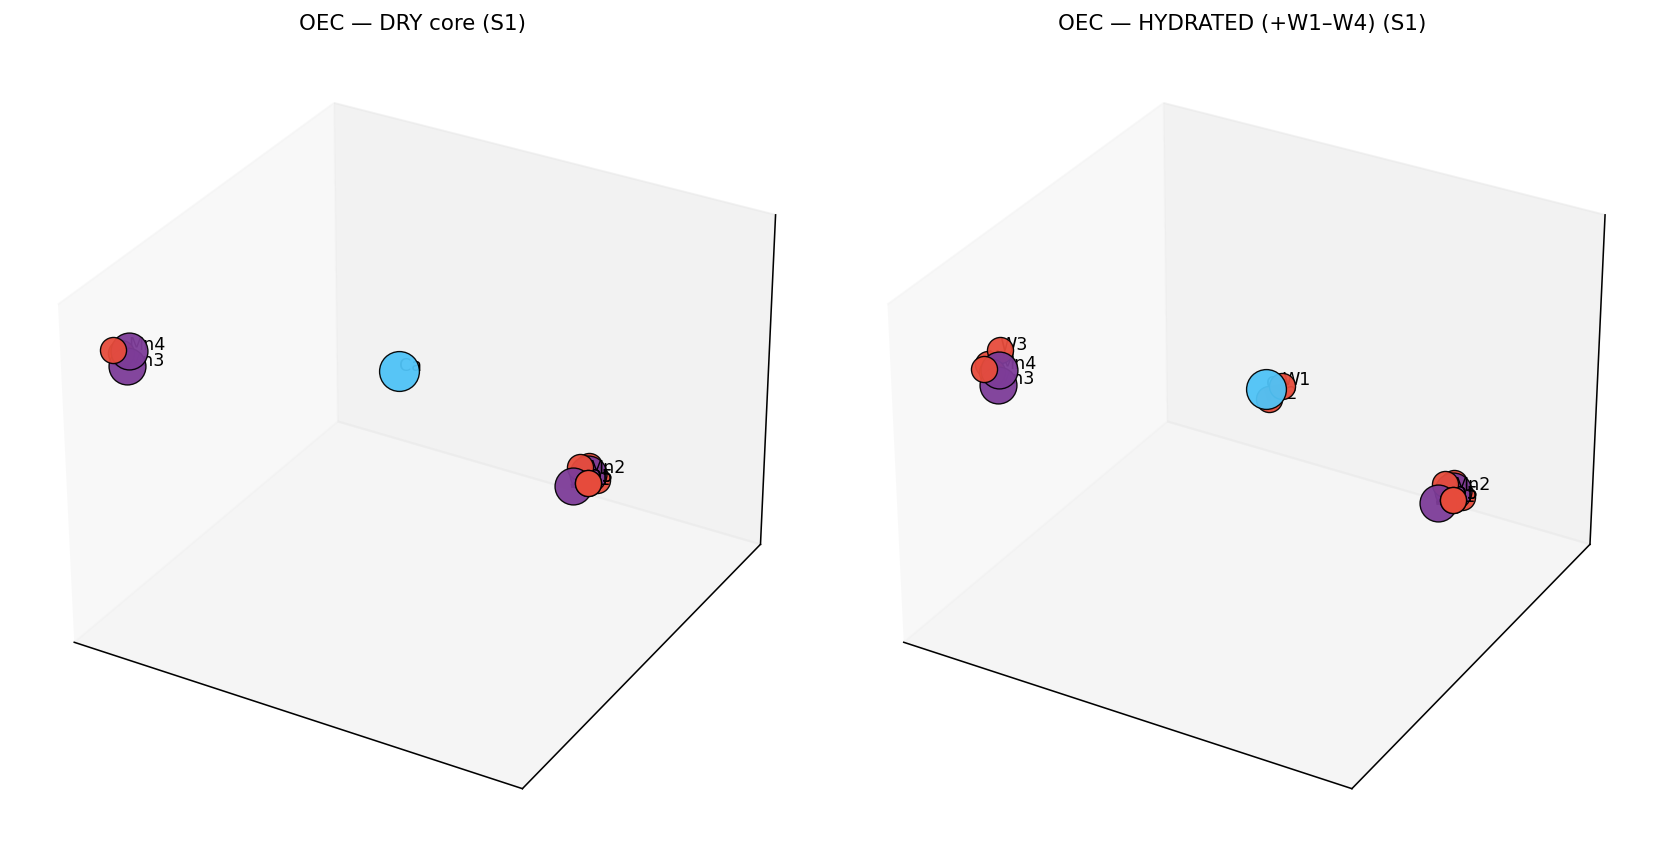

Saved: OEC_S1_DRY_vs_HYDRATED_muoxo.png


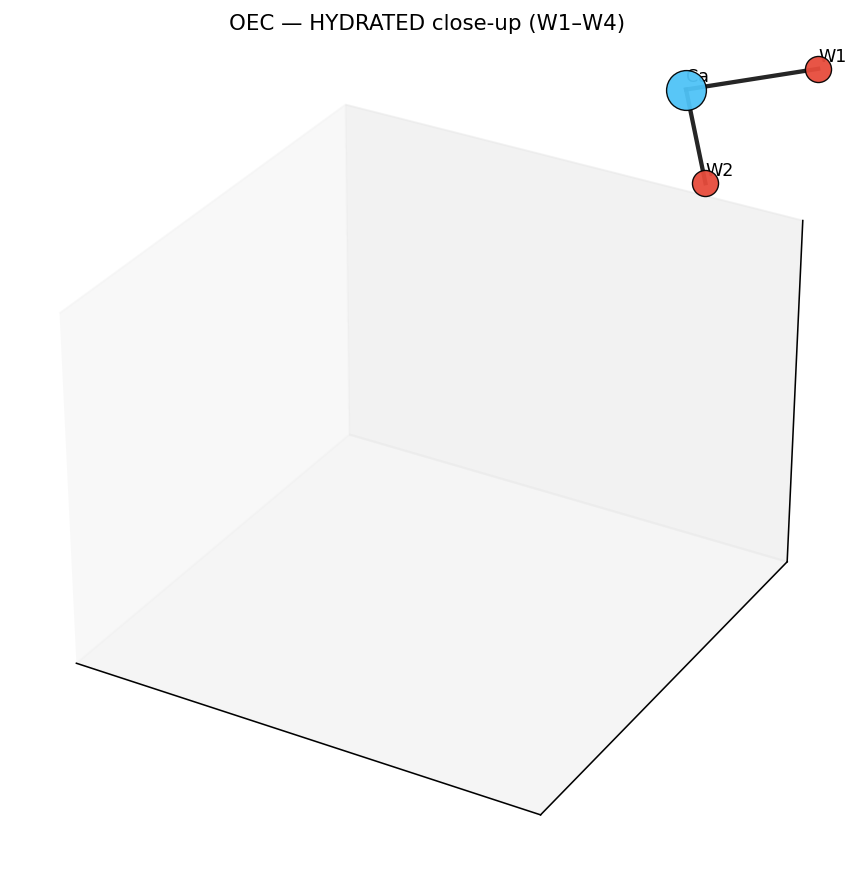

Saved: OEC_S1_HYDRATED_ZOOM_muoxo.png


In [ ]:
# ==============================================
# PSII OEC (S1) from 3WU2.cif — DRY vs HYDRATED with μ-oxo logic
# Upload 3WU2.cif first (case-sensitive)
# ==============================================
!pip -q install gemmi

import os, math
import numpy as np
import matplotlib.pyplot as plt
import gemmi

CIF_PATH = "3WU2.cif"
OUT_MAIN = "OEC_S1_DRY_vs_HYDRATED_muoxo.png"
OUT_ZOOM = "OEC_S1_HYDRATED_ZOOM_muoxo.png"

# ---- bond/selection cutoffs (Å) ----
CUT_MN_O  = 2.20   # Mn–O coordination
CUT_CA_O  = 2.60   # Ca–O coordination
CUT_TERM_O= 2.00   # terminal oxo (tighter)
CUT_MU_O  = 2.20   # μ-oxo must be within this to >=2 metals
ZOOM_R    = 3.6    # Å zoom radius

# ---- helpers ----
def set_equal_3d(ax, pts):
    P = np.asarray(pts, float)
    cx,cy,cz = P.mean(0)
    r = max(np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2]))*0.55 + 0.9
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, center, r):
    cx,cy,cz = center
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def d(a,b): return float(np.linalg.norm(np.array(a)-np.array(b)))

def uniq_atoms(items, tol=0.30):
    out=[]
    for it in items:
        p=np.array(it['xyz'])
        if not any(np.linalg.norm(p-np.array(u['xyz']))<=tol for u in out):
            out.append(it)
    return out

def bonds(atoms):
    pairs=[]; xyz=[a['xyz'] for a in atoms]; el=[a['el'] for a in atoms]
    for i in range(len(atoms)):
        for j in range(i+1,len(atoms)):
            dij=d(xyz[i],xyz[j]); ei,ej=el[i],el[j]
            if {'MN','O'}=={ei,ej} and dij<=CUT_MN_O: pairs.append((i,j))
            if {'CA','O'}=={ei,ej} and dij<=CUT_CA_O: pairs.append((i,j))
            if {'MN','CA'}=={ei,ej} and dij<=3.0:      pairs.append((i,j))  # loose metal–metal bar
    return pairs

def plot_cluster(ax, atoms, title="", equal=True):
    COL={"MN":"#7D3C98","CA":"#4FC3F7","O":"#E74C3C"}
    SIZ={"MN":360,"CA":420,"O":180}
    pts=[]
    for a in atoms:
        x,y,z=a['xyz']; E=a['el']; s=SIZ.get(E,120); c=COL.get(E,"gray")
        ax.scatter([x],[y],[z], s=s, c=c, edgecolor="k", lw=0.7, alpha=0.95, zorder=3)
        pts.append((x,y,z))
        if a.get('label'):
            ax.text(x, y, z+0.18, a['label'], fontsize=9, color="black", zorder=5)
    for i,j in bonds(atoms):
        xi,yi,zi=atoms[i]['xyz']; xj,yj,zj=atoms[j]['xyz']
        ax.plot([xi,xj],[yi,yj],[zi,zj], color="k", lw=2.2, alpha=0.85, zorder=2)
    ax.set_title(title)
    if equal and pts: set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# ---- load structure ----
if not os.path.exists(CIF_PATH): raise FileNotFoundError("Upload 3WU2.cif first.")
st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

# flatten
els,pos,resn = [],[],[]
for ch in model:
    for res in ch:
        rn=res.name.upper()
        for a in res:
            els.append(a.element.name.upper())
            pos.append([a.pos.x,a.pos.y,a.pos.z])
            resn.append(rn)
els=np.array(els,object); pos=np.array(pos,float); resn=np.array(resn,object)
print(f"Parsed atoms: {len(els)}")

# metals
mn_idx=np.where(els=='MN')[0]; ca_idx=np.where(els=='CA')[0]
if mn_idx.size<4 or ca_idx.size<1: raise RuntimeError("Could not find Ca/Mn metals.")
mn_pos=pos[mn_idx]; ca_pos=pos[ca_idx]
mn_cent=mn_pos.mean(0)
# choose 4 Mn closest to Mn-centroid
mn_pick = mn_idx[np.argsort(np.linalg.norm(mn_pos-mn_cent,axis=1))[:4]]
# pick Ca closest to Mn-centroid
ca_pick = ca_idx[np.argsort(np.linalg.norm(ca_pos-mn_cent,axis=1))[0]]
Ca_xyz  = tuple(pos[ca_pick])
# order Mn by distance to Ca (nearest→farthest) to label Mn1..Mn4 consistently
mn_pick_sorted = sorted(list(mn_pick), key=lambda i: d(pos[i], Ca_xyz))
Mn_xyz = [tuple(pos[i]) for i in mn_pick_sorted]
Mn_labels = [f"Mn{i+1}" for i in range(4)]

core_metals = [{'el':'CA','xyz':Ca_xyz,'label':'Ca'}] + \
              [{'el':'MN','xyz':Mn_xyz[i],'label':Mn_labels[i]} for i in range(4)]
core_cent = np.mean(np.array([a['xyz'] for a in core_metals]),axis=0)

# oxygens
is_oxygen = np.array([str(e).startswith('O') or str(e)=='OW' for e in els],bool)
is_water  = np.array([str(r) in ('HOH','WAT','H2O','DOD','W') for r in resn],bool)
idx_O_nonwat = np.where(is_oxygen & (~is_water))[0]
idx_O_wat    = np.where(is_oxygen & is_water)[0]
O_nonwat = pos[idx_O_nonwat]
O_wat    = pos[idx_O_wat]

# ---- μ-oxo: within CUT_MU_O to >=2 metals; terminal: within CUT_TERM_O to 1 metal
mu_oxo, term_oxo = [],[]
for oi, xyz in zip(idx_O_nonwat, O_nonwat):
    close_to = 0
    for m in core_metals:
        cut = CUT_CA_O if m['el']=='CA' else CUT_MN_O
        if d(xyz, m['xyz']) <= cut: close_to += 1
    if close_to >= 2:
        mu_oxo.append({'el':'O','xyz':tuple(xyz)})   # bridging
    elif any(d(xyz,m['xyz']) <= CUT_TERM_O for m in core_metals):
        term_oxo.append({'el':'O','xyz':tuple(xyz)}) # terminal (tight)

mu_oxo = uniq_atoms(mu_oxo, tol=0.25)
term_oxo = uniq_atoms(term_oxo, tol=0.25)

# choose O5: μ-oxo closest to Mn-centroid
if mu_oxo:
    mn_centroid = np.mean(np.array(Mn_xyz),axis=0)
    o5 = sorted(mu_oxo, key=lambda o: d(o['xyz'], mn_centroid))[0]
    o5['label'] = 'O5'
else:
    o5=None

# ---- Waters: W1/W2 closest to Ca; W3/W4 closest to Mn farthest from Ca (Mn4 proxy)
Mn4_xyz = Mn_xyz[-1]   # farthest from Ca by our ordering
w_d_ca  = [ (tuple(xyz), d(xyz, Ca_xyz))  for xyz in O_wat ]
w_d_mn4 = [ (tuple(xyz), d(xyz, Mn4_xyz)) for xyz in O_wat ]

W1W2 = sorted(w_d_ca,  key=lambda t:t[1])[:2]
W3W4 = sorted(w_d_mn4, key=lambda t:t[1])[:2]

# ensure uniqueness (don’t reuse same water)
Wset=[];
for xyz,_ in W1W2+W3W4:
    if not any(d(xyz, w['xyz'])<0.2 for w in Wset):
        Wset.append({'el':'O','xyz':xyz})
# label W1..W4 by proximity to Ca first
Wset = sorted(Wset, key=lambda w: d(w['xyz'], Ca_xyz))[:4]
for i,w in enumerate(Wset,1): w['label']=f"W{i}"

DRY = core_metals + mu_oxo + term_oxo + ([o5] if o5 else [])
HYD = DRY + Wset

# ---- report table ----
print("\n== Metal positions ==")
for a in core_metals: print(f"{a['label']:>3}: {np.round(a['xyz'],3)}")
if o5: print(f"O5: {np.round(o5['xyz'],3)}  (μ-oxo)")

print("\n== Waters ==")
for w in Wset:
    print(f"{w['label']}: {np.round(w['xyz'],3)}  d(Ca)={d(w['xyz'],Ca_xyz):.2f} Å  d(Mn4)={d(w['xyz'],Mn4_xyz):.2f} Å")

# some key distances
def nearest_O_to(atom, pool, cut):
    ds=[(p, d(atom['xyz'], p['xyz'])) for p in pool]
    ds=[t for t in ds if t[1]<=cut]
    return min(ds, key=lambda t:t[1])[1] if ds else None

print("\n== Check distances (Å) ==")
for i,m in enumerate(core_metals):
    dm = nearest_O_to(m, mu_oxo, CUT_CA_O if m['el']=='CA' else CUT_MN_O)
    dt = nearest_O_to(m, term_oxo, CUT_TERM_O)
    print(f"{m['label']:>3}  nearest μ-oxo: {dm or '-':>5}   nearest terminal: {dt or '-':>5}")

# ---- plot ----
fig = plt.figure(figsize=(12,6))
ax1=fig.add_subplot(121, projection='3d')
ax2=fig.add_subplot(122, projection='3d')
plot_cluster(ax1, DRY, title="OEC — DRY core (S1)", equal=True)
plot_cluster(ax2, HYD, title="OEC — HYDRATED (+W1–W4) (S1)", equal=True)
plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
print("Saved:", OUT_MAIN)

fig2=plt.figure(figsize=(6.8,6.4))
axZ=fig2.add_subplot(111, projection='3d')
plot_cluster(axZ, HYD, title="OEC — HYDRATED close-up (W1–W4)", equal=False)
set_zoom_3d(axZ, core_cent, ZOOM_R)
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print("Saved:", OUT_ZOOM)

In [ ]:
# [001] # ================================================================
# [002] # OEC (PSII, S1 state) from 3WU2.cif — DRY core vs HYDRATED (+W1–W4)
# [003] # Robust selection + clean 3D plots + zoom. Colab-ready.
# [004] # Dependencies: gemmi, numpy, matplotlib
# [005] # ================================================================
# [006]
# [007] !pip -q install gemmi
# [008]
# [009] import os, math
# [010] import numpy as np
# [011] import matplotlib.pyplot as plt
# [012] import gemmi
# [013] from itertools import combinations
# [014]
# [015] # ---------- user settings ----------
# [016] CIF_PATH   = "3WU2.cif"                     # upload first
# [017] OUT_MAIN   = "OEC_3WU2_DRY_vs_HYDRATED.png"
# [018] OUT_ZOOM   = "OEC_3WU2_HYDRATED_ZOOM.png"
# [019] TITLE_L    = "OEC — DRY core (S1, 3WU2)"
# [020] TITLE_R    = "OEC — HYDRATED (+W1–W4) (S1, 3WU2)"
# [021] TITLE_Z    = "OEC — HYDRATED close-up (W1–W4)"
# [022]
# [023] # Distance thresholds (Å) — gentle, not overfitted
# [024] THR_MN_MN  = 3.3
# [025] THR_MN_O   = 2.3
# [026] THR_CA_O   = 2.6
# [027] THR_W_NEAR = 3.2      # water must be within this of any metal
# [028] ZOOM_R     = 4.0
# [029]
# [030] # ---------- helpers ----------
# [031] def np_norm(v): return float(np.linalg.norm(v))
# [032]
# [033] def to_xyz(atom):
# [034]     p = atom.pos
# [035]     return np.array([p.x, p.y, p.z], float)
# [036]
# [037] def set_equal_3d(ax, pts, pad=0.8):
# [038]     pts = np.asarray(pts, float)
# [039]     cx, cy, cz = pts.mean(axis=0)
# [040]     r = max(np.ptp(pts[:,0]), np.ptp(pts[:,1]), np.ptp(pts[:,2]))*0.65 + pad
# [041]     ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
# [042]
# [043] def set_zoom_3d(ax, center, r):
# [044]     cx, cy, cz = center
# [045]     ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
# [046]
# [047] # ---------- load structure ----------
# [048] if not os.path.exists(CIF_PATH):
# [049]     raise FileNotFoundError(f"Upload {CIF_PATH} first.")
# [050] st = gemmi.read_structure(CIF_PATH)
# [051] st.remove_hydrogens()                # simplify
# [052] model = st[0]                        # first model
# [053]
# [054] # Collect atoms we need quickly into arrays (fast iteration)
# [055] mn_atoms, ca_atoms, o_atoms, water_o = [], [], [], []
# [056] for ch in model:
# [057]     for res in ch:
# [058]         rn = res.name.upper()
# [059]         is_water = rn in ("HOH","WAT","H2O","DOD","W")
# [060]         for a in res:
# [061]             el = a.element.name.upper()
# [062]             if el == "MN": mn_atoms.append(a)
# [063]             elif el == "CA": ca_atoms.append(a)
# [064]             elif el.startswith("O"):    # O, OXT, etc.
# [065]                 (water_o if is_water else o_atoms).append(a)
# [066]
# [067] if not mn_atoms or not ca_atoms:
# [068]     raise RuntimeError("Could not find Mn or Ca in 3WU2.cif (unexpected).")
# [069]
# [070] # ---------- pick Mn4 cluster (tightest 4 around Mn centroid) ----------
# [071] mn_xyz = np.array([to_xyz(a) for a in mn_atoms], float)
# [072] mn_centroid = mn_xyz.mean(axis=0)
# [073] # choose 4 Mn with smallest distance to centroid
# [074] idx_sorted = np.argsort(np.linalg.norm(mn_xyz - mn_centroid, axis=1))
# [075] mn4 = [mn_atoms[i] for i in idx_sorted[:4]]
# [076]
# [077] # ---------- pick Ca nearest to Mn centroid ----------
# [078] ca_xyz = np.array([to_xyz(a) for a in ca_atoms], float)
# [079] ca_idx = int(np.argmin(np.linalg.norm(ca_xyz - mn_centroid, axis=1)))
# [080] ca1 = ca_atoms[ca_idx]
# [081]
# [082] core_metals = [ca1] + mn4
# [083] core_xyz    = np.array([to_xyz(a) for a in core_metals], float)
# [084] core_labels = ["Ca"] + [f"Mn{i+1}" for i in range(4)]
# [085]
# [086] print("Core metals (Ca + 4 Mn):")
# [087] for lab, a in zip(core_labels, core_metals):
# [088]     x,y,z = to_xyz(a)
# [089]     print(f"  {lab:>3}  ({x:7.3f}, {y:7.3f}, {z:7.3f})")
# [090]
# [091] # ---------- find bridging O (exclude waters) within Mn–O / Ca–O ranges ----------
# [092] bridg_O = []
# [093] for o in o_atoms:
# [094]     ox = to_xyz(o)
# [095]     ok = False
# [096]     for m in core_metals:
# [097]        dx = np_norm(ox - to_xyz(m))
# [098]        if (m.element.name.upper()=="MN" and dx <= THR_MN_O) or \
# [099]           (m.element.name.upper()=="CA" and dx <= THR_CA_O):
# [100]            ok = True; break
# [101]     if ok: bridg_O.append(o)
# [102]
# [103] # ---------- waters: choose those within W_NEAR of any metal; then 4 nearest to Ca ----------
# [104] cand_w = []
# [105] ca_pos = to_xyz(ca1)
# [106] for w in water_o:
# [107]     wx = to_xyz(w)
# [108]     if min(np_norm(wx - to_xyz(m)) for m in core_metals) <= THR_W_NEAR:
# [109]         cand_w.append((w, np_norm(wx - ca_pos)))
# [110] cand_w.sort(key=lambda t: t[1])
# [111] W = [t[0] for t in cand_w[:4]]
# [112]
# [113] print(f"Selected waters near Ca (W1–W4): {len(W)} found")
# [114] for i, w in enumerate(W, 1):
# [115]     x,y,z = to_xyz(w)
# [116]     print(f"  W{i}: ({x:7.3f}, {y:7.3f}, {z:7.3f})  d(Ca)={np_norm([x,y,z]-ca_pos):.2f} Å")
# [117]
# [118] # ---------- assemble DRY / HYD lists ----------
# [119] DRY_atoms = core_metals + bridg_O
# [120] HYD_atoms = DRY_atoms  + W
# [121]
# [122] # ---------- bonds using simple distance rules ----------
# [123] def bonds(atom_list):
# [124]     pts = [to_xyz(a) for a in atom_list]
# [125]     els = [a.element.name.upper() for a in atom_list]
# [126]    _pairs = []
# [127]     for i,j in combinations(range(len(atom_list)), 2):
# [128]         dij = np_norm(pts[i] - pts[j])
# [129]         ei, ej = els[i], els[j]
# [130]         if ({"MN","CA"} <= {ei,ej}) and dij <= THR_MN_MN:
# [131]             _pairs.append((i,j))
# [132]         elif {"MN","O"} == {ei,ej} and dij <= THR_MN_O:
# [133]             _pairs.append((i,j))
# [134]         elif {"CA","O"} == {ei,ej} and dij <= THR_CA_O:
# [135]             _pairs.append((i,j))
# [136]     return _pairs
# [137]
# [138] # ---------- plotting ----------
# [139] COLORS = {"MN":"#7D3C98","CA":"#5DADE2","O":"#E74C3C"}
# [140] SIZES  = {"MN":260, "CA":300, "O":160}
# [141]
# [142] def plot_cluster(ax, atoms, title="", water_labels=None, equal=True):
# [143]     pts=[]
# [144]     for a in atoms:
# [145]         x,y,z = to_xyz(a)
# [146]         E = a.element.name.upper()
# [147]         ax.scatter([x],[y],[z], s=SIZES.get(E,120), color=COLORS.get(E,"gray"),
# [148]                    edgecolor="k", lw=0.7, alpha=0.95)
# [149]         pts.append([x,y,z])
# [150]     # bonds
# [151]     b = bonds(atoms)
# [152]     for i,j in b:
# [153]         xi,yi,zi = to_xyz(atoms[i]); xj,yj,zj = to_xyz(atoms[j])
# [154]         ax.plot([xi,xj],[yi,yj],[zi,zj], color="k", lw=2, alpha=0.9)
# [155]     # labels for waters
# [156]     if water_labels:
# [157]         for i, a in water_labels.items():
# [158]             xa,ya,za = to_xyz(a)
# [159]             ax.text(xa,ya,za+0.25, f"W{i}", fontsize=10, color="black")
# [160]     ax.set_title(title)
# [161]     if equal: set_equal_3d(ax, pts)
# [162]     ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
# [163]
# [164] # Figure 1 — DRY vs HYDRATED
# [165] fig = plt.figure(figsize=(12,6))
# [166] ax1 = fig.add_subplot(121, projection="3d")
# [167] ax2 = fig.add_subplot(122, projection="3d")
# [168] plot_cluster(ax1, DRY_atoms, title=TITLE_L, equal=True)
# [169] wmap = {i+1:W[i] for i in range(len(W))}
# [170] plot_cluster(ax2, HYD_atoms, title=TITLE_R, equal=True, water_labels=wmap)
# [171] plt.tight_layout(); plt.savefig(OUT_MAIN, dpi=300); plt.show()
# [172] print("✅ Saved", OUT_MAIN)
# [173]
# [174] # Figure 2 — HYDRATED ZOOM centred on metal centroid
# [175] core_centroid = core_xyz.mean(axis=0)
# [176] fig2 = plt.figure(figsize=(6.8,6.4))
# [177] axZ = fig2.add_subplot(111, projection="3d")
# [178] plot_cluster(axZ, HYD_atoms, title=TITLE_Z, equal=False, water_labels=wmap)
# [179] set_zoom_3d(axZ, core_centroid, ZOOM_R)
# [180] axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
# [181] plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
# [182] print("✅ Saved", OUT_ZOOM)

Waters chosen (W1–W4): 4
  W1: (-9.466, 5.331, 38.589)  d(Ca)=2.43 Å
  W2: (-10.523, 3.812, 36.578)  d(Ca)=2.44 Å
  W3: (-12.036, 2.049, 40.649)  d(Ca)=2.52 Å
  W4: (-12.980, 4.439, 38.970)  d(Ca)=2.68 Å


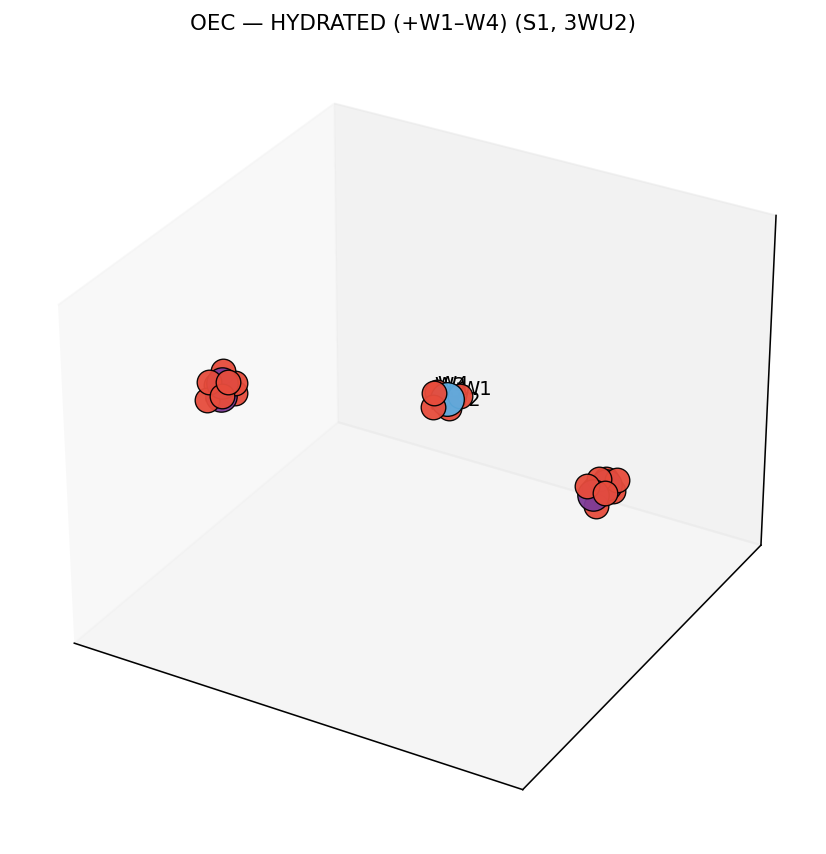

✅ Saved OEC_3WU2_HYDRATED.png


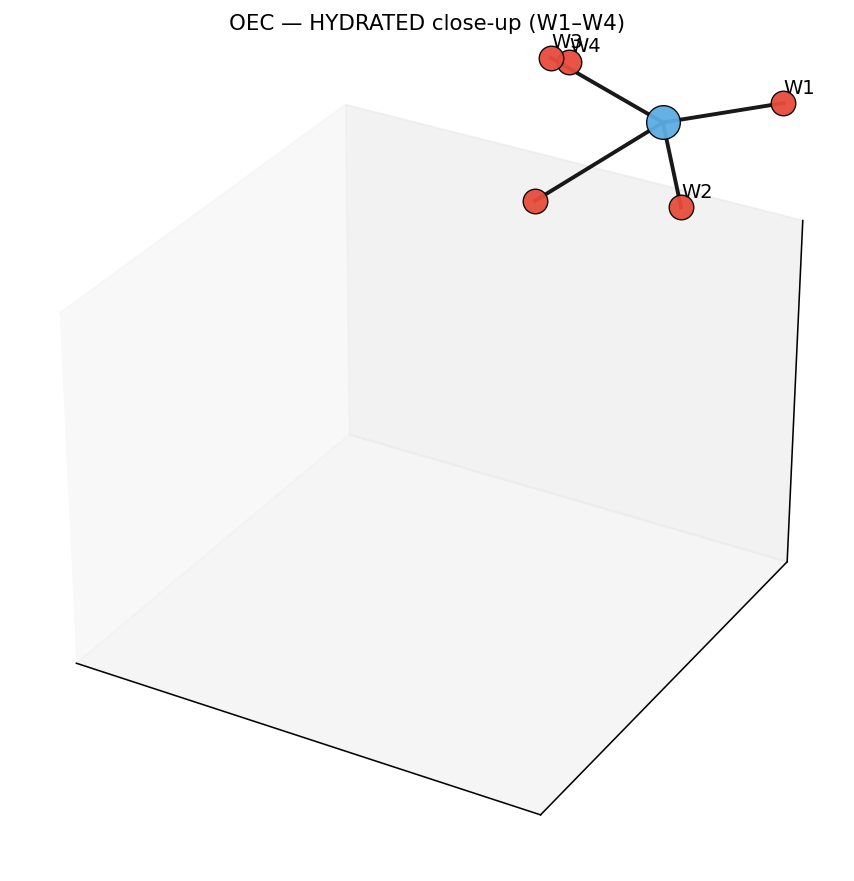

✅ Saved OEC_3WU2_HYDRATED_ZOOM.png


In [ ]:
# ================================================================
# PSII OEC (S1, 3WU2.cif) — HYDRATED ONLY (+W1–W4) + ZOOM
# Requires: pip install gemmi  (Colab-friendly)
# Outputs:  OEC_3WU2_HYDRATED.png, OEC_3WU2_HYDRATED_ZOOM.png
# ================================================================
!pip -q install gemmi

import os
import numpy as np
import matplotlib.pyplot as plt
import gemmi
from itertools import combinations

# -------------------- USER SETTINGS --------------------
CIF_PATH = "3WU2.cif"             # upload first in Colab
OUT_HYD  = "OEC_3WU2_HYDRATED.png"
OUT_ZOOM = "OEC_3WU2_HYDRATED_ZOOM.png"
TITLE_H  = "OEC — HYDRATED (+W1–W4) (S1, 3WU2)"
TITLE_Z  = "OEC — HYDRATED close-up (W1–W4)"

# geometry thresholds (Å) — conservative, tweakable
THR_MN_MN  = 3.3
THR_MN_O   = 2.3
THR_CA_O   = 2.6
THR_W_NEAR = 3.2      # water must be this close to ANY metal
ZOOM_R     = 4.0      # zoom half-box around metal centroid

# -------------------- helpers --------------------
def np_norm(v): return float(np.linalg.norm(v))
def to_xyz(atom): p = atom.pos; return np.array([p.x, p.y, p.z], float)

def set_equal_3d(ax, pts, pad=0.8):
    pts = np.asarray(pts, float)
    cx, cy, cz = pts.mean(axis=0)
    r = max(np.ptp(pts[:,0]), np.ptp(pts[:,1]), np.ptp(pts[:,2]))*0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

def set_zoom_3d(ax, center, r):
    cx, cy, cz = center
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)

# -------------------- load & collect --------------------
if not os.path.exists(CIF_PATH):
    raise FileNotFoundError("Upload 3WU2.cif to the Colab working directory.")

st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

mn, ca, o, wO = [], [], [], []
for ch in model:
    for res in ch:
        rn = res.name.upper()
        is_water = rn in ("HOH", "WAT", "H2O", "DOD", "W")
        for a in res:
            el = a.element.name.upper()
            if   el == "MN": mn.append(a)
            elif el == "CA": ca.append(a)
            elif el.startswith("O"):
                (wO if is_water else o).append(a)

if not mn or not ca:
    raise RuntimeError("Mn or Ca not found (unexpected for 3WU2).")

# ---- pick CaMn4 core (closest Ca to Mn centroid; 4 Mn nearest to that centroid)
mn_xyz   = np.array([to_xyz(a) for a in mn])
mn_cent  = mn_xyz.mean(axis=0)
mn_idx   = np.argsort(np.linalg.norm(mn_xyz - mn_cent, axis=1))[:4]
mn4      = [mn[i] for i in mn_idx]

ca_xyz   = np.array([to_xyz(a) for a in ca])
ca1      = ca[np.argmin(np.linalg.norm(ca_xyz - mn_cent, axis=1))]

core     = [ca1] + mn4
core_xyz = np.array([to_xyz(a) for a in core])

# ---- bridging O (exclude waters): any O within metal–O thresholds
bridg = []
for ox in o:
    X = to_xyz(ox)
    for m in core:
        d  = np_norm(X - to_xyz(m))
        em = m.element.name.upper()
        if (em == "MN" and d <= THR_MN_O) or (em == "CA" and d <= THR_CA_O):
            bridg.append(ox)
            break

# ---- waters: within THR_W_NEAR of ANY metal; choose 4 nearest to Ca as W1–W4
cap   = to_xyz(ca1)
cands = []
for wx in wO:
    W = to_xyz(wx)
    if min(np_norm(W - to_xyz(m)) for m in core) <= THR_W_NEAR:
        cands.append((wx, np_norm(W - cap)))
cands.sort(key=lambda t: t[1])
W = [t[0] for t in cands[:4]]

print(f"Waters chosen (W1–W4): {len(W)}")
for i, wx in enumerate(W, 1):
    X = to_xyz(wx)
    print(f"  W{i}: ({X[0]:.3f}, {X[1]:.3f}, {X[2]:.3f})  d(Ca)={np_norm(X - cap):.2f} Å")

# ---- selection & bonds
HYD = core + bridg + W

def bonds(atoms):
    pts = [to_xyz(a) for a in atoms]
    els = [a.element.name.upper() for a in atoms]
    out = []
    for i, j in combinations(range(len(atoms)), 2):
        d = np.linalg.norm(pts[i] - pts[j])
        ei, ej = els[i], els[j]
        if ({"MN","CA"} <= {ei,ej}) and d <= THR_MN_MN:
            out.append((i,j))
        elif {"MN","O"} == {ei,ej} and d <= THR_MN_O:
            out.append((i,j))
        elif {"CA","O"} == {ei,ej} and d <= THR_CA_O:
            out.append((i,j))
    return out

# -------------------- plotting --------------------
COLORS = {"MN": "#7D3C98", "CA": "#5DADE2", "O": "#E74C3C"}
SIZES  = {"MN": 260, "CA": 300, "O": 160}

def plot_cluster(ax, atoms, water_map=None, title="", equal=True):
    pts = []
    for a in atoms:
        x, y, z = to_xyz(a)
        E = a.element.name.upper()
        ax.scatter([x], [y], [z],
                   s=SIZES.get(E, 120),
                   color=COLORS.get(E, "gray"),
                   edgecolor="k", lw=0.7, alpha=0.95)
        pts.append([x, y, z])
    for i, j in bonds(atoms):
        xi, yi, zi = to_xyz(atoms[i])
        xj, yj, zj = to_xyz(atoms[j])
        ax.plot([xi, xj], [yi, yj], [zi, zj], color="k", lw=2, alpha=0.9)
    if water_map:
        for idx, a in water_map.items():
            x, y, z = to_xyz(a)
            ax.text(x, y, z + 0.25, f"W{idx}", fontsize=10)
    ax.set_title(title)
    if equal: set_equal_3d(ax, pts)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Figure A — HYDRATED overview
fig = plt.figure(figsize=(7.6, 6.2))
ax  = fig.add_subplot(111, projection="3d")
wmap = {i+1: W[i] for i in range(len(W))}
plot_cluster(ax, HYD, water_map=wmap, title=TITLE_H, equal=True)
plt.tight_layout(); plt.savefig(OUT_HYD, dpi=300); plt.show()
print("✅ Saved", OUT_HYD)

# Figure B — HYDRATED zoom (fixed limits around metal centroid)
core_cent = core_xyz.mean(axis=0)
fig2 = plt.figure(figsize=(6.8, 6.4))
axZ  = fig2.add_subplot(111, projection="3d")
plot_cluster(axZ, HYD, water_map=wmap, title=TITLE_Z, equal=False)
set_zoom_3d(axZ, core_cent, ZOOM_R)
axZ.set_xticks([]); axZ.set_yticks([]); axZ.set_zticks([])
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print("✅ Saved", OUT_ZOOM)

Selected: Ca1 + 4 Mn; μ-O=2; Waters=4


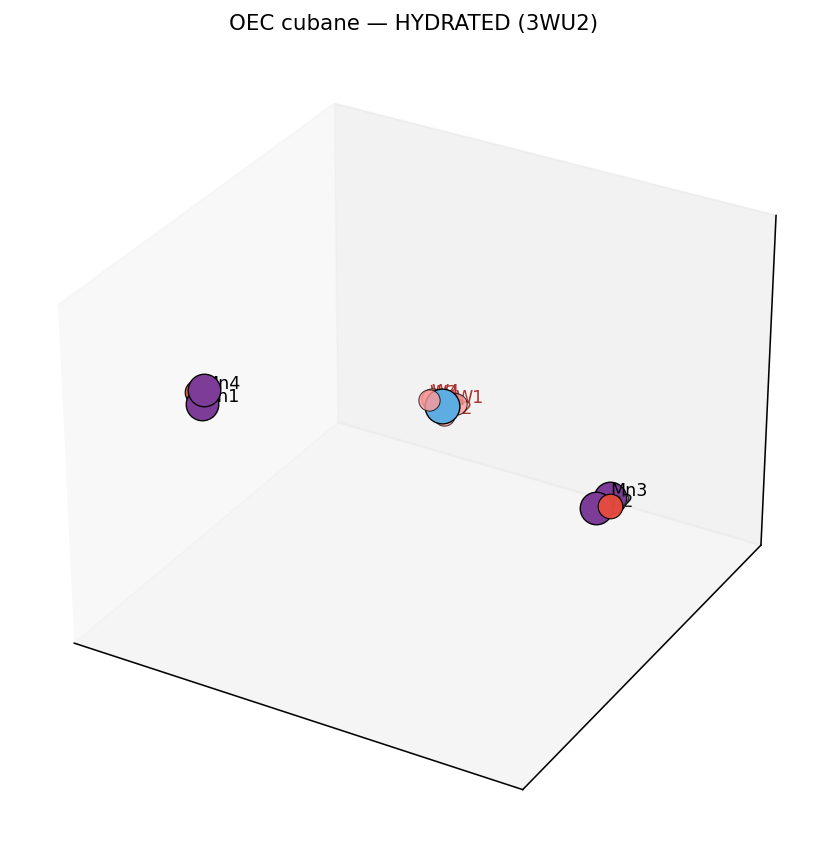

✅ OEC_cubane_overview.png


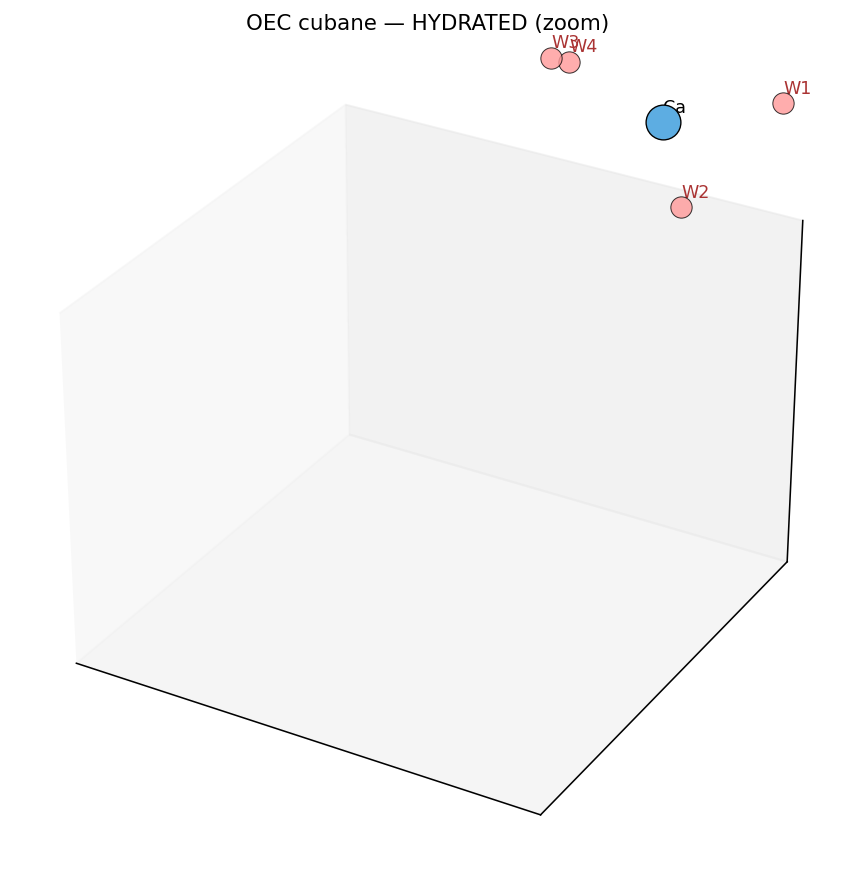

✅ OEC_cubane_zoom.png


In [ ]:
# ================================================================
# PSII OEC (S1, 3WU2.cif) — enforce [Mn3CaO4] cubane + dangling Mn
# Strategy:
#   1) pick 4 Mn nearest the Mn-centroid + the nearest Ca
#   2) pick μ-oxo bridges: O within cutoff to >= 2 metals (Mn or Ca)
#   3) draw metals, μ-O, bonds; show W1–W4 but keep them separate
# Outputs: OEC_cubane_overview.png, OEC_cubane_zoom.png
# ================================================================
!pip -q install gemmi

import os, numpy as np, matplotlib.pyplot as plt, gemmi
from itertools import combinations

CIF = "3WU2.cif"              # upload first
OUT_A = "OEC_cubane_overview.png"
OUT_B = "OEC_cubane_zoom.png"

# ---- tunables (Å) ----
THR_MN_O   = 2.25          # Mn–O bridge cutoff
THR_CA_O   = 2.55          # Ca–O bridge cutoff
THR_MN_MN  = 3.3           # Mn–Mn near-edge cue (for lines only)
THR_W_NEAR = 3.1           # waters near metals
ZOOM_R     = 4.0

def xyz(a): p=a.pos; return np.array([p.x,p.y,p.z], float)
def L2(a,b): return float(np.linalg.norm(a-b))

if not os.path.exists(CIF):
    raise FileNotFoundError("Upload 3WU2.cif first.")

st = gemmi.read_structure(CIF)
st.remove_hydrogens()
m  = st[0]

mn, ca, oxy, wO = [], [], [], []
for ch in m:
    for res in ch:
        is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            e = a.element.name.upper()
            if e=="MN": mn.append(a)
            elif e=="CA": ca.append(a)
            elif e.startswith("O"):
                (wO if is_w else oxy).append(a)

if len(mn)<4 or len(ca)<1:
    raise RuntimeError("Could not find enough Mn or Ca in 3WU2.")

# ----- metals: Ca + 4 Mn nearest Mn-centroid -----
mn_xyz  = np.array([xyz(a) for a in mn])
mn_cent = mn_xyz.mean(axis=0)
mn_idx  = np.argsort(np.linalg.norm(mn_xyz - mn_cent, axis=1))[:4]
MN4     = [mn[i] for i in mn_idx]

ca_xyz  = np.array([xyz(a) for a in ca])
CA1     = ca[np.argmin(np.linalg.norm(ca_xyz - mn_cent, axis=1))]

metals  = [CA1] + MN4
met_xyz = np.array([xyz(a) for a in metals])

# ----- μ-oxo selection: O that bind at least two metals (within cutoffs) -----
muO = []
for ox in oxy:
    X = xyz(ox)
    close_to = 0
    for met in metals:
        d = L2(X, xyz(met))
        el = met.element.name.upper()
        if (el=="MN" and d<=THR_MN_O) or (el=="CA" and d<=THR_CA_O):
            close_to += 1
        if close_to >= 2:
            muO.append(ox)
            break

# keep only 4 closest μ-O to the metal centroid (aiming for O4)
mu_xyz = np.array([xyz(o) for o in muO])
if len(muO) > 4:
    cen = met_xyz.mean(axis=0)
    order = np.argsort(np.linalg.norm(mu_xyz - cen, axis=1))[:4]
    muO   = [muO[i] for i in order]

# ----- waters: four nearest to Ca (W1–W4) within THR_W_NEAR -----
cap  = xyz(CA1)
cand = []
for w in wO:
    W = xyz(w)
    if min(L2(W, xyz(mt)) for mt in metals) <= THR_W_NEAR:
        cand.append((w, L2(W, cap)))
cand.sort(key=lambda t:t[1])
W = [t[0] for t in cand[:4]]
W_map = {i+1:W[i] for i in range(len(W))}

print(f"Selected: Ca1 + {len(MN4)} Mn; μ-O={len(muO)}; Waters={len(W)}")

# ====== drawing ======
COL = {"MN":"#7D3C98","CA":"#5DADE2","O":"#E74C3C"}
SIZE= {"MN":280,"CA":320,"O":160}

def set_equal(ax, pts, pad=0.8):
    P=np.asarray(pts); cx,cy,cz=P.mean(axis=0)
    r=max(np.ptp(P[:,0]),np.ptp(P[:,1]),np.ptp(P[:,2]))*0.65+pad
    ax.set_xlim(cx-r,cx+r); ax.set_ylim(cy-r,cy+r); ax.set_zlim(cz-r,cz+r)

def bonds(metals, muO):
    # metal–μO bonds only (enforce cubane edges)
    B=[]
    for i,mt in enumerate(metals):
        Mi, ei = xyz(mt), mt.element.name.upper()
        thr_i = THR_CA_O if ei=="CA" else THR_MN_O
        for j,ox in enumerate(muO):
            Oj=xyz(ox)
            if L2(Mi,Oj)<=thr_i:
                B.append(("M",i,"O",j))
    return B

def plot(ax, metals, muO, waters=None, title="", equal=True, zoom_cen=None, zoom_r=None):
    pts=[]
    # metals
    for k,mt in enumerate(metals):
        X=xyz(mt); E=mt.element.name.upper()
        ax.scatter([X[0]],[X[1]],[X[2]], s=SIZE[E], color=COL[E], ec="k", lw=0.7)
        ax.text(X[0],X[1],X[2]+0.25, "Ca" if E=="CA" else f"Mn{k if E=='MN' else ''}", fontsize=9)
        pts.append(X)
    # μ-oxo
    for j,ox in enumerate(muO):
        X=xyz(ox); E="O"
        ax.scatter([X[0]],[X[1]],[X[2]], s=SIZE[E], color=COL[E], ec="k", lw=0.6, alpha=0.95)
        ax.text(X[0],X[1],X[2]-0.35, f"O{j+1}", fontsize=8, color="#333")
        pts.append(X)
    # bonds (metal–μO only)
    for typ,i,typ2,j in bonds(metals,muO):
        A=xyz(metals[i]); Bp=xyz(muO[j])
        ax.plot([A[0],Bp[0]],[A[1],Bp[1]],[A[2],Bp[2]], color="k", lw=2.2, alpha=0.9)
    # waters
    if waters:
        for idx,w in waters.items():
            X=xyz(w)
            ax.scatter([X[0]],[X[1]],[X[2]], s=120, color="#FF9999", ec="k", lw=0.5, alpha=0.8)
            ax.text(X[0],X[1],X[2]+0.25, f"W{idx}", fontsize=9, color="#a33")
            pts.append(X)
    ax.set_title(title)
    if equal: set_equal(ax, pts)
    if (zoom_cen is not None) and (zoom_r is not None):
        cx,cy,cz = zoom_cen; r=zoom_r
        ax.set_xlim(cx-r,cx+r); ax.set_ylim(cy-r,cy+r); ax.set_zlim(cz-r,cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# overview (equal aspect)
fig = plt.figure(figsize=(7.8,6.2))
ax  = fig.add_subplot(111, projection="3d")
plot(ax, metals, muO, waters=W_map, title="OEC cubane — HYDRATED (3WU2)", equal=True)
plt.tight_layout(); plt.savefig(OUT_A, dpi=300); plt.show()
print("✅", OUT_A)

# zoom (fixed box on metal centroid)
cen = np.mean(np.array([xyz(mt) for mt in metals]), axis=0)
fig2 = plt.figure(figsize=(6.8,6.4))
ax2  = fig2.add_subplot(111, projection="3d")
plot(ax2, metals, muO, waters=W_map, title="OEC cubane — HYDRATED (zoom)", equal=False,
     zoom_cen=cen, zoom_r=ZOOM_R)
plt.tight_layout(); plt.savefig(OUT_B, dpi=300); plt.show()
print("✅", OUT_B)

---- DIAGNOSTIC ----
metals: Ca:47070, Mn:41160, Mn:46327, Mn:46325, Mn:41158
μ-O count (found/ranked): 4 → using 4
O1: bonds -> [('Mn', '2.05'), ('Mn', '2.06')]
O2: bonds -> [('Mn', '2.09'), ('Mn', '2.05')]
O3: bonds -> [('Mn', '2.34'), ('Mn', '2.25')]
O4: bonds -> [('Mn', '2.43'), ('Mn', '2.28')]
waters: 4


AttributeError: `ptp` was removed from the ndarray class in NumPy 2.0. Use np.ptp(arr, ...) instead.

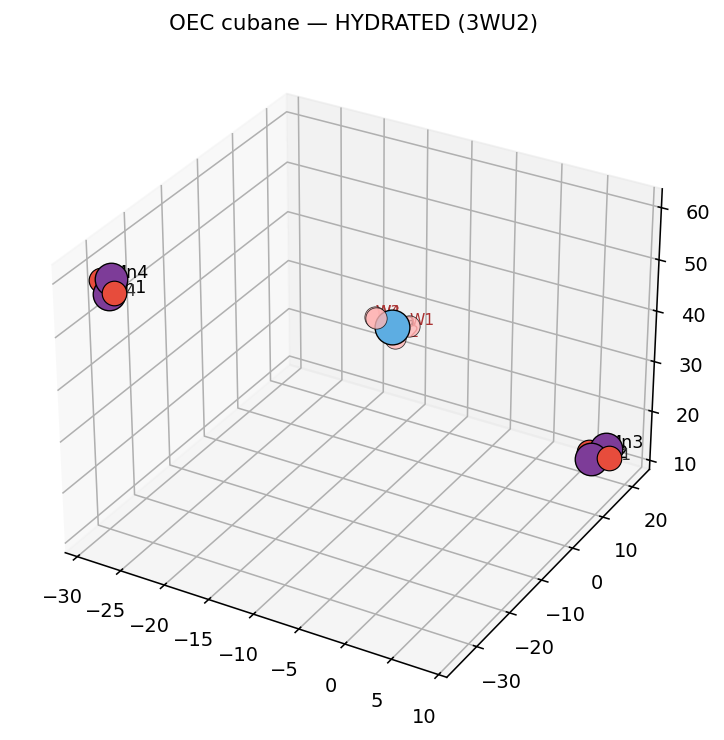

In [ ]:
# ================================================================
# OEC cubane from 3WU2.cif — robust μ-oxo detection + cubane edges
# ================================================================
!pip -q install gemmi

import os, numpy as np, matplotlib.pyplot as plt, gemmi
from itertools import combinations

CIF = "3WU2.cif"     # upload first
OUT_OV = "OEC_cubane_OV.png"
OUT_ZM = "OEC_cubane_ZOOM.png"

# ---- helpers ---------------------------------------------------
def P(a): p=a.pos; return np.array([p.x, p.y, p.z], float)
def d(a,b): return float(np.linalg.norm(P(a)-P(b)))

def set_equal(ax, pts, pad=0.8):
    pts = np.asarray(pts); cx,cy,cz = pts.mean(axis=0)
    r = max(pts.ptp(0)) * 0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# ---- load ------------------------------------------------------
if not os.path.exists(CIF):
    raise FileNotFoundError("Upload 3WU2.cif first.")
st = gemmi.read_structure(CIF)
st.remove_hydrogens()
model = st[0]

mn, ca, oxy, wat = [], [], [], []
for ch in model:
    for res in ch:
        is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            e = a.element.name.upper()
            if   e == "MN": mn.append(a)
            elif e == "CA": ca.append(a)
            elif e.startswith("O"):
                (wat if is_w else oxy).append(a)

if len(mn) < 4 or len(ca) < 1:
    raise RuntimeError("Could not find 4×Mn and 1×Ca in file.")

# ---- metals: 4 Mn nearest Mn-centroid + closest Ca -------------
mn_xyz  = np.array([P(a) for a in mn])
mn_cent = mn_xyz.mean(axis=0)
mn4     = [mn[i] for i in np.argsort(np.linalg.norm(mn_xyz-mn_cent, axis=1))[:4]]
ca1     = min(ca, key=lambda a: np.linalg.norm(P(a)-mn_cent))
metals  = [ca1] + mn4
met_xyz = np.array([P(m) for m in metals])

# ---- adaptive μ-oxo search ------------------------------------
def find_mu_oxo(oxy, metals, thr_mn_o, thr_ca_o):
    mu = []
    for o in oxy:
        cnt, tot = 0, 0.0
        for m in metals:
            dm = d(o, m)
            if (m.element.name.upper()=="MN" and dm<=thr_mn_o) or \
               (m.element.name.upper()=="CA" and dm<=thr_ca_o):
                cnt += 1; tot += dm
        if cnt >= 2:
            mu.append((o, cnt, tot))
    return mu

thr_mn_o, thr_ca_o = 2.10, 2.40
mu = find_mu_oxo(oxy, metals, thr_mn_o, thr_ca_o)

# widen until at least 4 μ-O (cap to safe limits)
while len(mu) < 4 and thr_mn_o < 2.40:
    thr_mn_o += 0.05; thr_ca_o += 0.05
    mu = find_mu_oxo(oxy, metals, thr_mn_o, thr_ca_o)

# rank: more neighbors first, then smaller total distance
mu.sort(key=lambda t: (-t[1], t[2]))
muO = [t[0] for t in mu[:4]]

# ---- waters: 4 closest to Ca (within 3.2 Å to any metal) -------
cand = []
for w in wat:
    if min(d(w, m) for m in metals) <= 3.2:
        cand.append((w, d(w, ca1)))
cand.sort(key=lambda t: t[1])
W = [t[0] for t in cand[:4]]

# ---- diagnostics -----------------------------------------------
def lab(a): return f"{a.element.name}:{a.serial or ''}"
print("---- DIAGNOSTIC ----")
print("metals:", ", ".join(lab(m) for m in metals))
print("μ-O count (found/ranked):", len(mu), "→ using", len(muO))
for i,o in enumerate(muO, 1):
    near = [(m.element.name, f"{d(o,m):.2f}") for m in metals if \
           ((m.element.name.upper()=="MN" and d(o,m)<=thr_mn_o) or
            (m.element.name.upper()=="CA" and d(o,m)<=thr_ca_o))]
    print(f"O{i}: bonds ->", near)
print("waters:", len(W))

# ---- build edges -----------------------------------------------
# metal–μO bonds
M_O_edges = []
for i,m in enumerate(metals):
    thr = thr_ca_o if m.element.name.upper()=="CA" else thr_mn_o
    for j,o in enumerate(muO):
        if d(m,o) <= thr:
            M_O_edges.append((i,j))

# metal–metal edges if they share at least one μ-O
MM_edges = set()
for (i,j) in combinations(range(len(metals)), 2):
    shared = any( ((i,k) in M_O_edges) and ((j,k) in M_O_edges)
                  for k in range(len(muO)) )
    if shared:
        MM_edges.add((i,j))

# ---- drawing ----------------------------------------------------
COL = {"MN":"#7D3C98","CA":"#5DADE2","O":"#E74C3C","W":"#FFB6B6"}
SZ  = {"MN":280,"CA":320,"O":160,"W":120}

def draw(ax, metals, muO, waters, title, zoom=None):
    pts = []
    # metals
    for idx,m in enumerate(metals):
        X=P(m); E=m.element.name.upper()
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[E], c=COL[E], ec="k", lw=0.7)
        ax.text(X[0],X[1],X[2]+0.25, "Ca" if E=="CA" else f"Mn{idx}", fontsize=9)
        pts.append(X)
    # μ-oxo
    for j,o in enumerate(muO,1):
        X=P(o)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["O"], c=COL["O"], ec="k", lw=0.6)
        ax.text(X[0],X[1],X[2]-0.30, f"O{j}", fontsize=8, color="#333")
        pts.append(X)
    # bonds M–O
    for i,j in M_O_edges:
        A=P(metals[i]); B=P(muO[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=2.2, alpha=0.95)
    # metal–metal cubane edges
    for i,j in MM_edges:
        A=P(metals[i]); B=P(metals[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=1.2, alpha=0.35)
    # waters
    for k,w in enumerate(waters,1):
        X=P(w)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["W"], c=COL["W"], ec="k", lw=0.4, alpha=0.8)
        ax.text(X[0],X[1],X[2]+0.25, f"W{k}", fontsize=8, color="#a33")
        pts.append(X)

    ax.set_title(title)
    if zoom is None:
        set_equal(ax, pts)
    else:
        cx,cy,cz,r = zoom
        ax.set_xlim(cx-r,cx+r); ax.set_ylim(cy-r,cy+r); ax.set_zlim(cz-r,cz+r)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# overview
fig = plt.figure(figsize=(7.8,6.3))
ax  = fig.add_subplot(111, projection='3d')
draw(ax, metals, muO, W, "OEC cubane — HYDRATED (3WU2)")
plt.tight_layout(); plt.savefig(OUT_OV, dpi=300); plt.show()
print("✅ saved", OUT_OV)

# zoom around metal centroid
cen = met_xyz.mean(axis=0)
fig2 = plt.figure(figsize=(6.6,6.2))
ax2  = fig2.add_subplot(111, projection='3d')
draw(ax2, metals, muO, W, "OEC cubane — HYDRATED (zoom)", zoom=(cen[0],cen[1],cen[2], 4.0))
plt.tight_layout(); plt.savefig(OUT_ZM, dpi=300); plt.show()
print("✅ saved", OUT_ZM)

---- DIAGNOSTIC ----
Cubane metals (Ca + 3 Mn): ['Ca', 'MN', 'MN', 'MN']  | Dangler: Mn*
Inter-metal distances (Å):
  Ca-MN: 3.30
  Ca-MN: 3.41
  Ca-MN: 3.49
  MN-MN: 2.92
  MN-MN: 2.76
  MN-MN: 3.29
μ-O chosen: 4 (cutoffs Mn–O ≤ 2.30, Ca–O ≤ 2.60)
  O1: [('MN', '2.02'), ('MN', '1.86'), ('MN', '1.93')]
  O2: [('Ca', '2.44'), ('MN', '2.07'), ('MN', '1.80')]
  O3: [('Ca', '2.48'), ('MN', '1.96'), ('MN', '1.91')]
  O4: [('Ca', '2.57'), ('MN', '2.25')]
Waters (nearest to Ca): 2


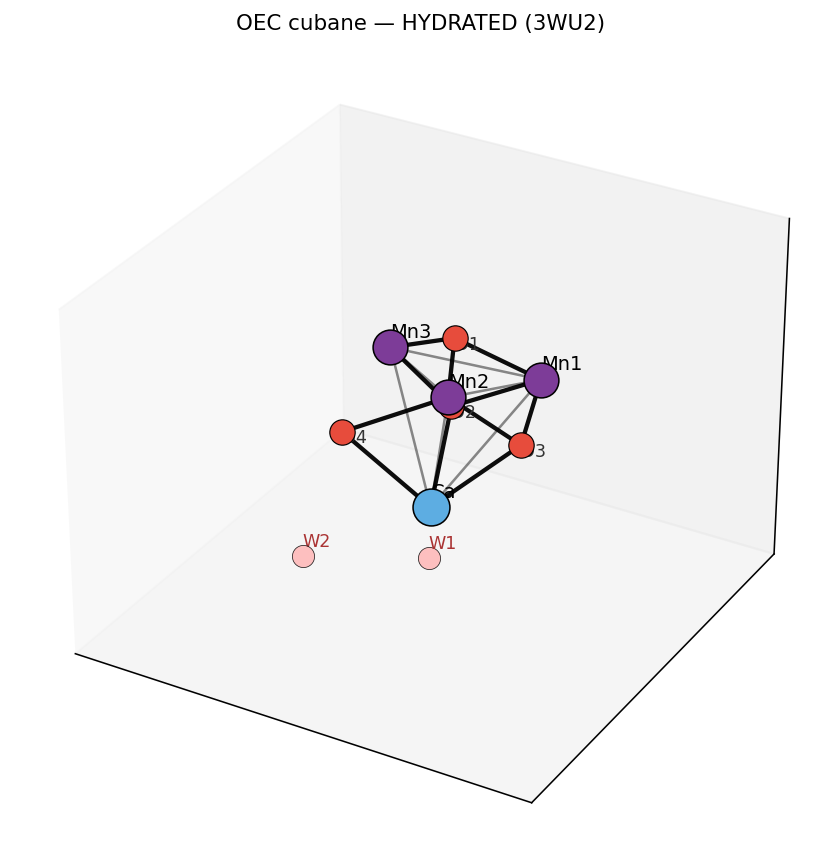

✅ saved OEC_cubane_OV.png


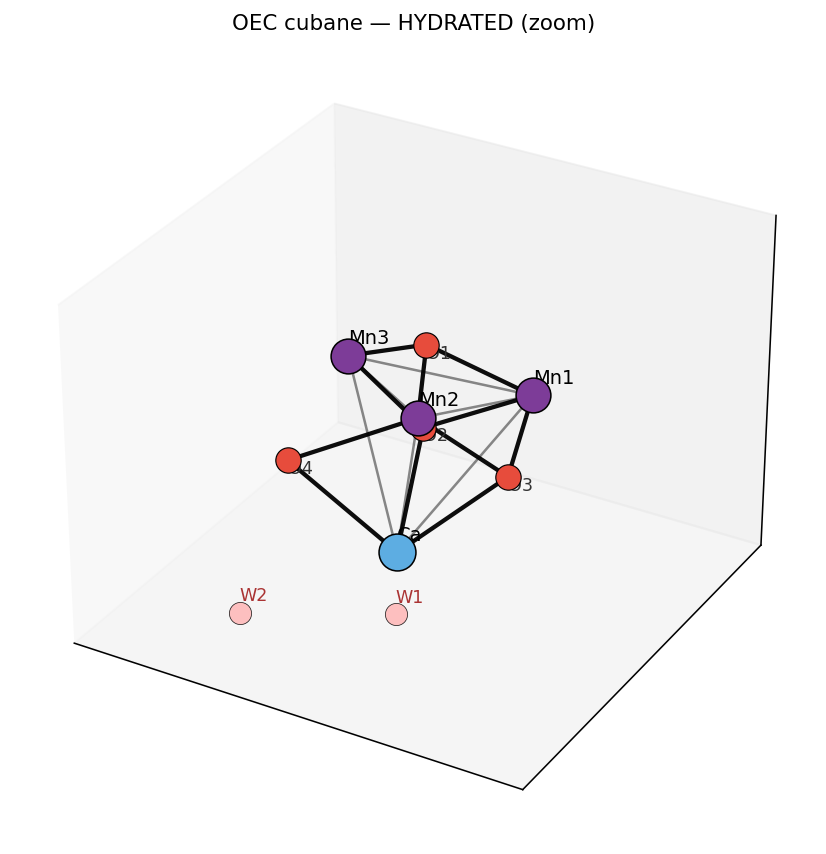

✅ saved OEC_cubane_ZOOM.png


In [ ]:
# ================================================================
# OEC cubane from 3WU2.cif — lock to Ca + 3 Mn cubane (dangler excluded)
# ================================================================
!pip -q install gemmi

import os, numpy as np, matplotlib.pyplot as plt, gemmi
from itertools import combinations

CIF = "3WU2.cif"     # upload first
OUT_OV = "OEC_cubane_OV.png"
OUT_ZM = "OEC_cubane_ZOOM.png"

def P(a): p=a.pos; return np.array([p.x, p.y, p.z], float)
def d(a,b): return float(np.linalg.norm(P(a)-P(b)))
# --- fix for NumPy 2.0 ---
def set_equal(ax, pts, pad=0.8):
    pts = np.asarray(pts)
    cx, cy, cz = pts.mean(axis=0)
    # use np.ptp instead of array.ptp
    r = max(np.ptp(pts[:, 0]), np.ptp(pts[:, 1]), np.ptp(pts[:, 2])) * 0.65 + pad
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# --- load ---
if not os.path.exists(CIF):
    raise FileNotFoundError("Upload 3WU2.cif first.")
st = gemmi.read_structure(CIF)
st.remove_hydrogens()
model = st[0]

mn, ca, oxy, wat = [], [], [], []
for ch in model:
    for res in ch:
        is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            e = a.element.name.upper()
            if   e == "MN": mn.append(a)
            elif e == "CA": ca.append(a)
            elif e.startswith("O"):
                (wat if is_w else oxy).append(a)

if len(mn) < 4 or len(ca) < 1:
    raise RuntimeError("Could not find 4×Mn and 1×Ca in file.")

# --- define cubane explicitly: Ca + 3 Mn CLOSEST TO Ca (dangler is farthest) ---
ca1 = min(ca, key=lambda a: np.linalg.norm(P(a)))
mn_sorted_by_Ca = sorted(mn, key=lambda m: d(m, ca1))
cubane_mn = mn_sorted_by_Ca[:3]          # Mn in the Mn3CaO4 cubane
dangler    = mn_sorted_by_Ca[-1]         # external Mn*
cubane_metals = [ca1] + cubane_mn        # Ca + 3 Mn (tetrahedron)
cub_xyz = np.array([P(m) for m in cubane_metals])

# --- μ-oxo that bridge ≥2 cubane metals (adaptive cutoffs) ---
thr_mn_o, thr_ca_o = 2.10, 2.40
def bridging_mu_oxo(oxys, metals, t_mn, t_ca):
    out=[]
    for o in oxys:
        touches=[]
        for m in metals:
            t = t_ca if m.element.name.upper()=="CA" else t_mn
            if d(o,m) <= t: touches.append(m)
        if len(touches) >= 2:
            tot = sum(d(o,m) for m in touches)
            out.append((o, len(touches), tot))
    return out

mu = bridging_mu_oxo(oxy, cubane_metals, thr_mn_o, thr_ca_o)
while len(mu) < 4 and thr_mn_o < 2.40:
    thr_mn_o += 0.05; thr_ca_o += 0.05
    mu = bridging_mu_oxo(oxy, cubane_metals, thr_mn_o, thr_ca_o)
mu.sort(key=lambda t: (-t[1], t[2]))
muO = [t[0] for t in mu[:4]]

# --- waters: 4 closest to Ca (within 3.2 Å to any cubane metal) ---
cand=[]
for w in wat:
    if min(d(w,m) for m in cubane_metals) <= 3.2:
        cand.append((w, d(w, ca1)))
cand.sort(key=lambda t: t[1])
W = [t[0] for t in cand[:4]]

# --- diagnostics ---
def tag(a):
    e=a.element.name.upper()
    if a is ca1: return "Ca"
    if a is dangler: return "Mn*"
    return e
print("---- DIAGNOSTIC ----")
print("Cubane metals (Ca + 3 Mn):", [tag(m) for m in cubane_metals], " | Dangler:", tag(dangler))
print("Inter-metal distances (Å):")
for i,j in combinations(range(len(cubane_metals)),2):
    print(f"  {tag(cubane_metals[i])}-{tag(cubane_metals[j])}: {d(cubane_metals[i], cubane_metals[j]):.2f}")
print("μ-O chosen:", len(muO), "(cutoffs Mn–O ≤ %.2f, Ca–O ≤ %.2f)"%(thr_mn_o,thr_ca_o))
for k,o in enumerate(muO,1):
    neigh=[(tag(m),f"{d(o,m):.2f}") for m in cubane_metals
           if d(o,m) <= (thr_ca_o if m.element.name.upper()=="CA" else thr_mn_o)]
    print(f"  O{k}: {neigh}")
print("Waters (nearest to Ca):", len(W))

# --- build edges ---
# bonds metal–μO within thresholds
M_O_edges=[]
for i,m in enumerate(cubane_metals):
    thr = thr_ca_o if m.element.name.upper()=="CA" else thr_mn_o
    for j,o in enumerate(muO):
        if d(m,o) <= thr:
            M_O_edges.append((i,j))

# complete cubane edges among the 4 cubane metals
MM_edges = list(combinations(range(4),2))

# --- draw ---
COL = {"MN":"#7D3C98","CA":"#5DADE2","O":"#E74C3C","W":"#FFB6B6"}
SZ  = {"MN":320,"CA":360,"O":170,"W":130}

def draw(ax, cub_metals, muO, waters, title, zoom=None):
    pts=[]
    for idx,m in enumerate(cub_metals):
        X=P(m); E=m.element.name.upper()
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[E], c=COL[E], ec="k", lw=0.8)
        name = "Ca" if E=="CA" else f"Mn{idx}"  # indices 1..3 for Mn
        ax.text(X[0],X[1],X[2]+0.25, name, fontsize=10)
        pts.append(X)
    for j,o in enumerate(muO,1):
        X=P(o)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["O"], c=COL["O"], ec="k", lw=0.6)
        ax.text(X[0],X[1],X[2]-0.30, f"O{j}", fontsize=9, color="#333")
        pts.append(X)
    # metal–μO bonds
    for i,j in M_O_edges:
        A=P(cub_metals[i]); B=P(muO[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=2.2, alpha=0.95)
    # cubane metal-metal edges (tetrahedron)
    for i,j in MM_edges:
        A=P(cub_metals[i]); B=P(cub_metals[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=1.3, alpha=0.45)
    # waters
    for k,w in enumerate(waters,1):
        X=P(w)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["W"], c=COL["W"], ec="k", lw=0.4, alpha=0.85)
        ax.text(X[0],X[1],X[2]+0.25, f"W{k}", fontsize=9, color="#a33")
        pts.append(X)

    ax.set_title(title)
    if zoom is None:
        set_equal(ax, pts)
    else:
        cx,cy,cz,r = zoom
        ax.set_xlim(cx-r,cx+r); ax.set_ylim(cy-r,cy+r); ax.set_zlim(cz-r,cz+r)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# overview
fig = plt.figure(figsize=(7.8,6.3))
ax  = fig.add_subplot(111, projection='3d')
draw(ax, cubane_metals, muO, W, "OEC cubane — HYDRATED (3WU2)")
plt.tight_layout(); plt.savefig(OUT_OV, dpi=300); plt.show()
print("✅ saved", OUT_OV)

# zoom around cubane centroid
cen = cub_xyz.mean(axis=0)
fig2 = plt.figure(figsize=(6.6,6.2))
ax2  = fig2.add_subplot(111, projection='3d')
draw(ax2, cubane_metals, muO, W, "OEC cubane — HYDRATED (zoom)", zoom=(cen[0],cen[1],cen[2], 3.6))
plt.tight_layout(); plt.savefig(OUT_ZM, dpi=300); plt.show()
print("✅ saved", OUT_ZM)

— DIAGNOSTIC —
Metals (Ca + 4 Mn): ['Ca', 'Mn', 'Mn', 'Mn', 'Mn']
Inter-metal distances (Å): Ca-Mn:44.12, Ca-Mn:35.68, Ca-Mn:36.61, Ca-Mn:45.32, Mn-Mn:77.10, Mn-Mn:78.70, Mn-Mn:2.97, Mn-Mn:2.89, Mn-Mn:78.74, Mn-Mn:80.27
μ-O chosen: 4  | Water sites: 4


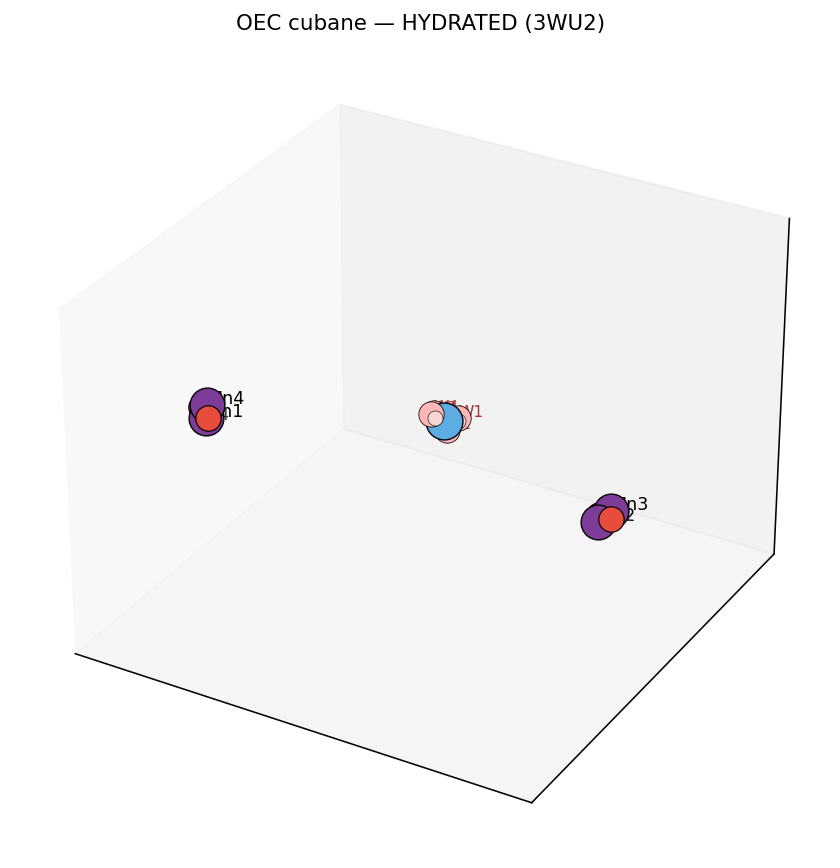

✅ saved OEC_cubane_HYDR_overview.png


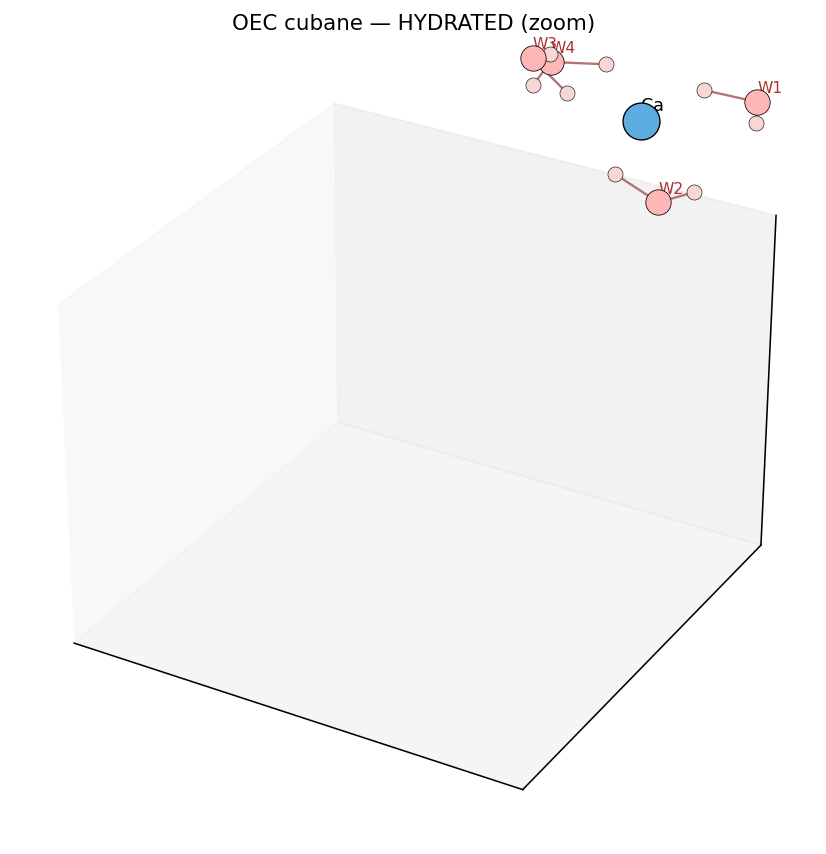

✅ saved OEC_cubane_HYDR_zoom.png


In [ ]:
# ================================================================
# OEC cubane from 3WU2.cif — 4×Mn + Ca, μ-oxo edges, real H2O, grid
# ================================================================
# pip: gemmi (for CIF/PDB)
import os, numpy as np, matplotlib.pyplot as plt
import gemmi
from itertools import combinations

CIF = "3WU2.cif"            # <- upload this file first
OUT_OV = "OEC_cubane_HYDR_overview.png"
OUT_ZM = "OEC_cubane_HYDR_zoom.png"

# ----------------- helpers -----------------
def P(a):
    p=a.pos; return np.array([p.x, p.y, p.z], float)
def dist(a,b):
    return float(np.linalg.norm(P(a)-P(b)))

def set_equal(ax, pts, pad=0.8, show_grid=True):
    pts = np.asarray(pts)
    cx, cy, cz = pts.mean(axis=0)
    # NumPy 2.0-safe ptp
    r = max(np.ptp(pts[:,0]), np.ptp(pts[:,1]), np.ptp(pts[:,2]))*0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.grid(show_grid)

def tetrahedral_H2O_positions(Oxyz, toward_xyz, r_OH=0.96, angle_deg=104.5):
    """
    Place 2 H around O in a tetrahedral-ish fashion with bisector pointing
    ~toward 'toward_xyz' (e.g., Ca). Returns two 3D positions for H atoms.
    """
    O = np.array(Oxyz, float); T = np.array(toward_xyz, float)
    u = T - O
    if np.linalg.norm(u) < 1e-6: u = np.array([1.0,0,0])
    u = u/np.linalg.norm(u)

    # build an orthonormal frame {u, v, w}
    # pick any vector not collinear with u
    tmp = np.array([0.0,1.0,0.0]) if abs(u[2])>0.7 else np.array([0.0,0.0,1.0])
    v = np.cross(u, tmp); v /= np.linalg.norm(v)
    w = np.cross(u, v)

    theta = np.radians(angle_deg/2.0)  # half-angle from bisector
    # place Hs symmetric around u in the v–w plane
    h1_dir = np.cos(theta)*u + np.sin(theta)*v
    h2_dir = np.cos(theta)*u - np.sin(theta)*v
    H1 = O + r_OH*h1_dir
    H2 = O + r_OH*h2_dir
    return H1, H2

# ----------------- load & split -----------------
if not os.path.exists(CIF):
    raise FileNotFoundError("Upload 3WU2.cif to the working directory.")

st = gemmi.read_structure(CIF)
st.remove_hydrogens()
model = st[0]

Mn_all, Ca_all, O_nonwat, O_wat = [], [], [], []
for ch in model:
    for res in ch:
        is_water = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            e = a.element.name.upper()
            if e == "MN": Mn_all.append(a)
            elif e == "CA": Ca_all.append(a)
            elif e.startswith("O"):
                (O_wat if is_water else O_nonwat).append(a)

if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find at least 4 Mn and 1 Ca in the file.")

# ----------------- choose Ca + 4 Mn -----------------
Mn_xyz = np.array([P(a) for a in Mn_all])
mn_cent = Mn_xyz.mean(axis=0)
# rank Mn by closeness to Mn-centroid, keep 4 (ensures we don't drop the 4th)
Mn4 = [Mn_all[i] for i in np.argsort(np.linalg.norm(Mn_xyz - mn_cent, axis=1))[:4]]
Ca1 = min(Ca_all, key=lambda a: np.linalg.norm(P(a)-mn_cent))
metals = [Ca1] + Mn4  # Ca + 4 Mn (always five metals now)

# ----------------- μ-oxo O selection (adaptive cutoffs) -----------------
def mu_oxo_candidates(O_list, metals, thr_mn_o, thr_ca_o):
    cand = []
    for o in O_list:
        count, tot = 0, 0.0
        for m in metals:
            dm = dist(o,m)
            is_Mn = (m.element.name.upper()=="MN")
            is_Ca = (m.element.name.upper()=="CA")
            if (is_Mn and dm <= thr_mn_o) or (is_Ca and dm <= thr_ca_o):
                count += 1; tot += dm
        if count >= 2:
            cand.append((o, count, tot))
    return cand

thr_mn_o, thr_ca_o = 2.10, 2.40
cand = mu_oxo_candidates(O_nonwat, metals, thr_mn_o, thr_ca_o)
while len(cand) < 4 and thr_mn_o < 2.40:
    thr_mn_o += 0.05; thr_ca_o += 0.05
    cand = mu_oxo_candidates(O_nonwat, metals, thr_mn_o, thr_ca_o)
cand.sort(key=lambda t: (-t[1], t[2]))
muO = [t[0] for t in cand[:4]]   # take 4 best

# ----------------- waters: W1–W4 near Ca -----------------
near = []
for w in O_wat:
    if min(dist(w,m) for m in metals) <= 3.2:
        near.append((w, dist(w, Ca1)))
near.sort(key=lambda t: t[1])
W = [t[0] for t in near[:4]]

# build pseudo H for each water (visual only)
W_with_H = []
for w in W:
    H1, H2 = tetrahedral_H2O_positions(P(w), P(Ca1))
    W_with_H.append((w, H1, H2))

# ----------------- edges -----------------
# metal–μO edges
M_O_edges = []
for i,m in enumerate(metals):
    thr = thr_ca_o if m.element.name.upper() == "CA" else thr_mn_o
    for j,o in enumerate(muO):
        if dist(m,o) <= thr:
            M_O_edges.append((i,j))

# metal–metal edges: connect metals that share at least one μ-oxo
MM_edges = set()
for i,j in combinations(range(len(metals)), 2):
    shared = any(((i,k) in M_O_edges) and ((j,k) in M_O_edges)
                 for k in range(len(muO)))
    if shared:
        MM_edges.add((i,j))

# ----------------- drawing -----------------
COL = {"MN":"#7D3C98", "CA":"#5DADE2", "O":"#E74C3C", "H":"#F7D6D6"}
SZ  = {"MN":320, "CA":360, "O":170, "H":60}

def draw(ax, title, zoom=None, show_grid=True):
    pts = []
    # metals
    for idx,m in enumerate(metals):
        X = P(m); E = m.element.name.upper()
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[E], c=COL[E], ec="k", lw=0.7, zorder=3)
        label = "Ca" if E=="CA" else f"Mn{idx}"
        ax.text(X[0], X[1], X[2]+0.25, label, fontsize=9)
        pts.append(X)
    # μ-oxo oxygens
    for j,o in enumerate(muO,1):
        X = P(o)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["O"], c=COL["O"], ec="k", lw=0.6, zorder=3)
        ax.text(X[0], X[1], X[2]-0.30, f"O{j}", fontsize=8, color="#333")
        pts.append(X)
    # bonds: M–O
    for i,j in M_O_edges:
        A, B = P(metals[i]), P(muO[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=2.2, alpha=0.95, zorder=2)
    # bonds: M–M (cubane frame)
    for i,j in MM_edges:
        A, B = P(metals[i]), P(metals[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=1.2, alpha=0.35, zorder=1)
    # waters with hydrogens
    for k,(w, H1, H2) in enumerate(W_with_H, 1):
        Ow = P(w)
        ax.scatter([Ow[0]],[Ow[1]],[Ow[2]], s=SZ["O"], c="#FFB6B6", ec="k", lw=0.4, zorder=3)
        ax.text(Ow[0], Ow[1], Ow[2]+0.22, f"W{k}", fontsize=8, color="#a33")
        for H in (H1, H2):
            ax.scatter([H[0]],[H[1]],[H[2]], s=SZ["H"], c=COL["H"], ec="k", lw=0.3, zorder=3)
            ax.plot([Ow[0],H[0]],[Ow[1],H[1]],[Ow[2],H[2]], color="#a66", lw=1.2, alpha=0.9, zorder=2)
        pts.extend([Ow, H1, H2])

    ax.set_title(title)
    if zoom is None:
        set_equal(ax, pts, show_grid=show_grid)
    else:
        cx,cy,cz,r = zoom
        ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.grid(show_grid)

# -------------- diagnostics --------------
print("— DIAGNOSTIC —")
print("Metals (Ca + 4 Mn):", [m.element.name for m in metals])
dists = [f"{metals[i].element.name}-"
         f"{metals[j].element.name}:{dist(metals[i],metals[j]):.2f}"
         for i,j in combinations(range(len(metals)),2)]
print("Inter-metal distances (Å):", ", ".join(dists))
print(f"μ-O chosen: {len(muO)}  | Water sites: {len(W)}")

# -------------- overview -----------------
fig = plt.figure(figsize=(7.8, 6.3))
ax  = fig.add_subplot(111, projection='3d')
draw(ax, "OEC cubane — HYDRATED (3WU2)", zoom=None, show_grid=True)
plt.tight_layout(); plt.savefig(OUT_OV, dpi=300); plt.show()
print("✅ saved", OUT_OV)

# -------------- zoom around metal centroid --------------
cen = np.mean([P(m) for m in metals], axis=0)
fig2 = plt.figure(figsize=(6.6, 6.2))
ax2  = fig2.add_subplot(111, projection='3d')
draw(ax2, "OEC cubane — HYDRATED (zoom)", zoom=(cen[0],cen[1],cen[2], 4.0), show_grid=True)
plt.tight_layout(); plt.savefig(OUT_ZM, dpi=300); plt.show()
print("✅ saved", OUT_ZM)

— DIAGNOSTIC —
Metals (should be 5): ['Ca', 'Mn', 'Mn', 'Mn', 'Mn']
Inter-metal distances (Å):
  Ca-Mn: 3.49
  Ca-Mn: 3.30
  Ca-Mn: 3.41
  Ca-Mn: 3.80
  Mn-Mn: 2.76
  Mn-Mn: 3.29
  Mn-Mn: 4.92
  Mn-Mn: 2.92
  Mn-Mn: 5.38
  Mn-Mn: 2.89
μ-O selected: 4  (Mn–O≤2.20 Å, Ca–O≤2.55 Å)
Waters chosen (≤3.0 Å to any metal): 4


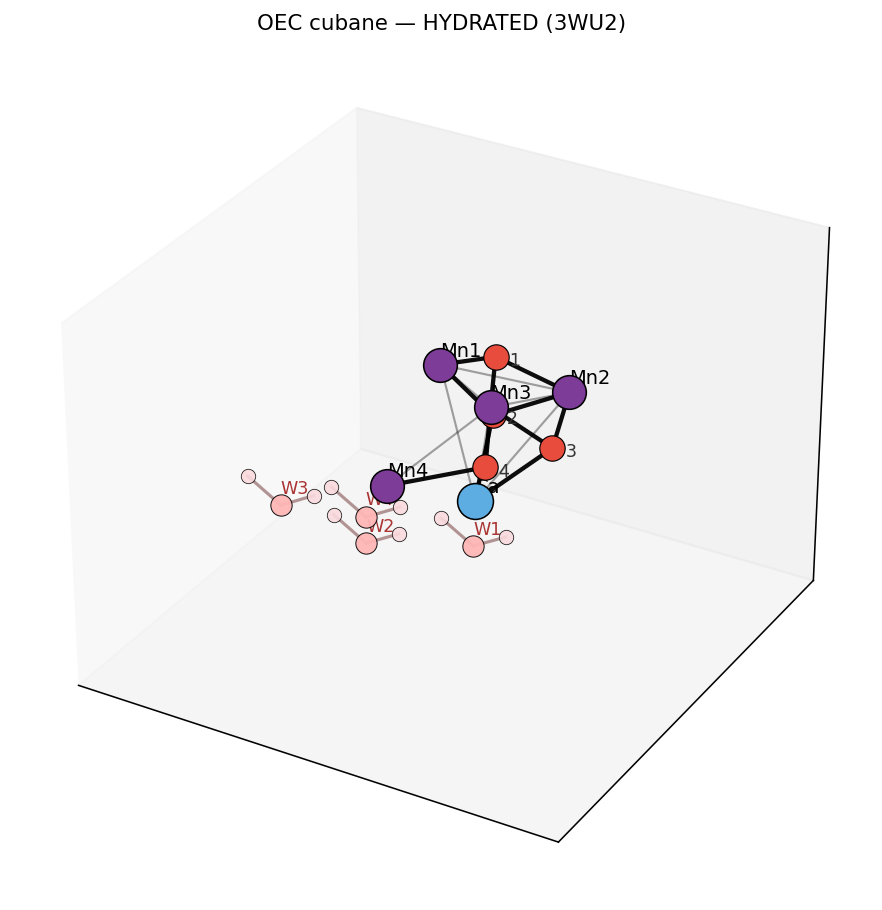

✅ saved OEC_cubane_OV.png


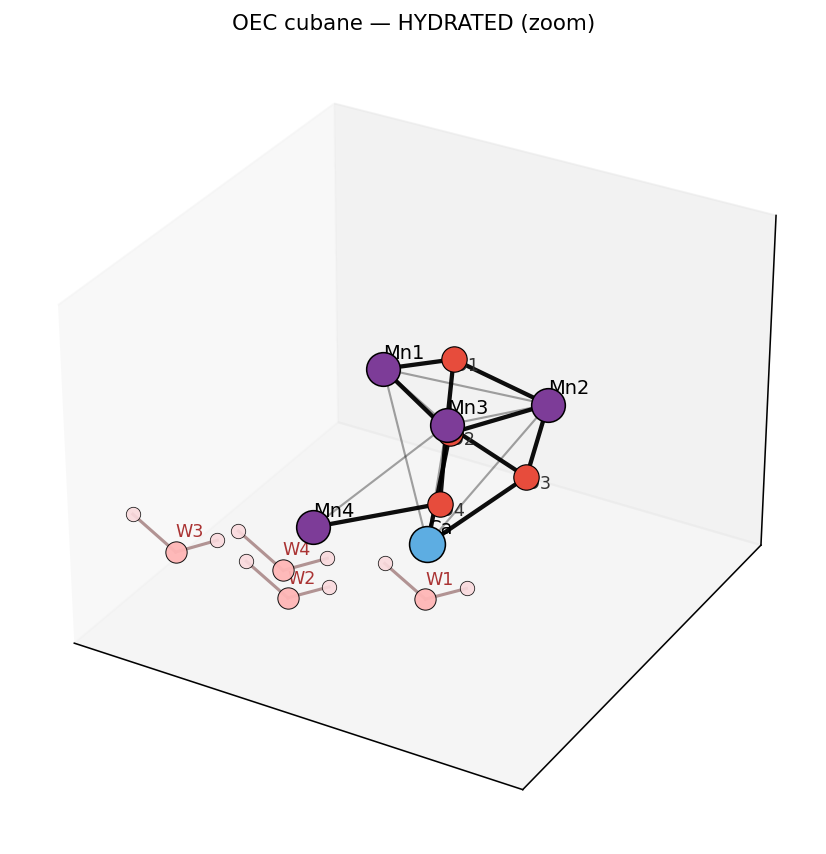

✅ saved OEC_cubane_ZOOM.png


In [ ]:
# ================================================================
# PSII OEC cubane from 3WU2.cif — robust Mn4 selection, μ-oxo & waters
# No manual editing required: upload 3WU2.cif (S1) to the runtime first
# Output: OEC_cubane_OV.png (overview), OEC_cubane_ZOOM.png (zoom)
# ================================================================
!pip -q install gemmi

import os, numpy as np, matplotlib.pyplot as plt, gemmi
from itertools import combinations

CIF = "3WU2.cif"                   # <-- make sure this file is in the working dir
OUT_OV = "OEC_cubane_OV.png"
OUT_ZM = "OEC_cubane_ZOOM.png"

# ---------- helpers ----------
def P(a):
    p = a.pos
    return np.array([p.x, p.y, p.z], float)

def dist(a, b):
    return float(np.linalg.norm(P(a) - P(b)))

def set_equal_3d(ax, pts, pad=0.8, show_grid=True):
    pts = np.asarray(pts, float)
    cx, cy, cz = pts.mean(axis=0)
    r = max(np.ptp(pts[:,0]), np.ptp(pts[:,1]), np.ptp(pts[:,2])) * 0.65 + pad
    ax.set_xlim(cx - r, cx + r)
    ax.set_ylim(cy - r, cy + r)
    ax.set_zlim(cz - r, cz + r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.grid(show_grid, alpha=0.25)

def add_h2o(ax, Opos, size_O=120, size_H=55, color_O="#FFB6B6", color_H="#FADADD"):
    """
    Draw a water molecule at oxygen position Opos with two hydrogens
    placed at 0.96 Å, 104.5°; oriented along a simple local frame.
    """
    O = np.array(Opos, float)
    # arbitrary local frame from two fixed vectors
    v1 = np.array([0.0, 0.0, 1.0])
    v2 = np.array([1.0, 0.0, 0.0])
    x = v1 / (np.linalg.norm(v1) + 1e-12)
    z = np.cross(v1, v2); z /= (np.linalg.norm(z) + 1e-12)
    y = np.cross(z, x)
    # water geometry
    OH = 0.96
    theta = np.deg2rad(52.25)  # half of 104.5°
    H1 = O + OH * ( np.cos(theta)*x + np.sin(theta)*y )
    H2 = O + OH * ( np.cos(theta)*x - np.sin(theta)*y )
    # plot O and Hs
    ax.scatter([O[0]],[O[1]],[O[2]], s=size_O, c=color_O, ec="k", lw=0.5, alpha=0.95)
    ax.scatter([H1[0]],[H1[1]],[H1[2]], s=size_H, c=color_H, ec="k", lw=0.4, alpha=0.9)
    ax.scatter([H2[0]],[H2[1]],[H2[2]], s=size_H, c=color_H, ec="k", lw=0.4, alpha=0.9)
    # bonds
    ax.plot([O[0],H1[0]],[O[1],H1[1]],[O[2],H1[2]], color="#a88", lw=1.6, alpha=0.9)
    ax.plot([O[0],H2[0]],[O[1],H2[1]],[O[2],H2[2]], color="#a88", lw=1.6, alpha=0.9)

# ---------- load structure ----------
if not os.path.exists(CIF):
    raise FileNotFoundError("Upload 3WU2.cif to the working directory first.")

st = gemmi.read_structure(CIF)
st.remove_hydrogens()
model = st[0]

Mn_all, Ca_all, O_nonwat, O_wat = [], [], [], []
for ch in model:
    for res in ch:
        is_water = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            e = a.element.name.upper()
            if e == "MN":
                Mn_all.append(a)
            elif e == "CA":
                Ca_all.append(a)
            elif e.startswith("O"):
                (O_wat if is_water else O_nonwat).append(a)

if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find 4×Mn and 1×Ca in 3WU2.cif.")

# ---------- choose Ca + best 4 Mn (robust against symmetry/alternates) -------
# ---------- choose Ca + best 4 Mn (fixed: same asymmetric unit) ----------
Mn_xyz = np.array([P(a) for a in Mn_all], float)

# filter Ca atoms near *any* Mn (same cell)
Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
if not Ca_near:
    raise RuntimeError("No Ca found within 6 Å of any Mn — check the CIF symmetry ops.")

# cost function: compact Mn₄ + Mn-centroid close to Ca
def cubane_cost(mset, Ca_atom):
    pts = np.array([P(m) for m in mset])
    pair = sum(np.linalg.norm(pts[i]-pts[j]) for i in range(4) for j in range(i+1,4))
    cen  = pts.mean(axis=0)
    d_ca = np.linalg.norm(cen - P(Ca_atom))
    return pair + 2.5*d_ca

best_combo, best_cost = None, 1e9
for Ca_atom in Ca_near:
    for combo in combinations(Mn_all, 4):
        cst = cubane_cost(combo, Ca_atom)
        if cst < best_cost:
            best_cost = cst
            best_combo = (Ca_atom, combo)

Ca1, Mn4 = best_combo
Mn4 = list(Mn4)
metals = [Ca1] + Mn4
met_pts = [P(m) for m in metals]
# ---------- μ-oxo search with adaptive thresholds ----------
def mu_oxo_candidates(O_list, metals, thr_mn_o, thr_ca_o):
    cand = []
    for o in O_list:
        cnt, tot = 0, 0.0
        for m in metals:
            dm = dist(o, m)
            if (m.element.name.upper()=="MN" and dm <= thr_mn_o) or \
               (m.element.name.upper()=="CA" and dm <= thr_ca_o):
                cnt += 1; tot += dm
        if cnt >= 2:
            cand.append((o, cnt, tot))
    return cand

thr_mn_o, thr_ca_o = 2.20, 2.55
cand = mu_oxo_candidates(O_nonwat, metals, thr_mn_o, thr_ca_o)
while len(cand) < 4 and thr_mn_o < 2.45:
    thr_mn_o += 0.05; thr_ca_o += 0.05
    cand = mu_oxo_candidates(O_nonwat, metals, thr_mn_o, thr_ca_o)
cand.sort(key=lambda t: (-t[1], t[2]))
muO = [t[0] for t in cand[:4]]

# ---------- four waters: closest to Ca, but must be ≤3.0 Å to any metal ----------
near = []
for w in O_wat:
    d_any = min(dist(w, m) for m in metals)
    if d_any <= 3.0:
        near.append((w, np.linalg.norm(P(w) - P(Ca1))))
near.sort(key=lambda t: t[1])
W = [t[0] for t in near[:4]]

# ---------- diagnostics ----------
def tag(a): return f"{a.element.name}:{a.serial or ''}"
print("— DIAGNOSTIC —")
print("Metals (should be 5):", [m.element.name for m in metals])
print("Inter-metal distances (Å):")
for i,j in combinations(range(len(metals)),2):
    print(f"  {metals[i].element.name}-{metals[j].element.name}: {np.linalg.norm(P(metals[i])-P(metals[j])):.2f}")
print(f"μ-O selected: {len(muO)}  (Mn–O≤{thr_mn_o:.2f} Å, Ca–O≤{thr_ca_o:.2f} Å)")
print("Waters chosen (≤3.0 Å to any metal):", len(W))

# ---------- build edges ----------
# metal–μO
M_O_edges = []
for i,m in enumerate(metals):
    thr = thr_ca_o if m.element.name.upper()=="CA" else thr_mn_o
    for j,o in enumerate(muO):
        if dist(m, o) <= thr:
            M_O_edges.append((i, j))

# metal–metal if they share at least one μ-O
MM_edges = set()
for i,j in combinations(range(len(metals)), 2):
    shared = any(((i,k) in M_O_edges) and ((j,k) in M_O_edges) for k in range(len(muO)))
    if shared:
        MM_edges.add((i,j))

# ---------- drawing ----------
COL = {"MN":"#7D3C98","CA":"#5DADE2","O":"#E74C3C"}
SZ  = {"MN":300,"CA":340,"O":170}

def draw_scene(ax, metals, muO, waters, title, zoom=None):
    pts = []
    # metals
    for idx, m in enumerate(metals):
        X = P(m); E = m.element.name.upper()
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[E], c=COL[E], ec="k", lw=0.8)
        lbl = "Ca" if E == "CA" else f"Mn{idx}"
        ax.text(X[0], X[1], X[2]+0.25, lbl, fontsize=10)
        pts.append(X)
    # μ-oxo
    for j, o in enumerate(muO, 1):
        X = P(o)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["O"], c=COL["O"], ec="k", lw=0.6)
        ax.text(X[0], X[1], X[2]-0.28, f"O{j}", fontsize=9, color="#333")
        pts.append(X)
    # bonds metal–O
    for i,j in M_O_edges:
        A, B = P(metals[i]), P(muO[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=2.2, alpha=0.95)
    # cubane edges metal–metal (light)
    for i,j in MM_edges:
        A, B = P(metals[i]), P(metals[j])
        ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color="k", lw=1.1, alpha=0.35)
    # waters (render with H's)
    for k, w in enumerate(waters, 1):
        Opos = P(w)
        add_h2o(ax, Opos)
        ax.text(Opos[0], Opos[1], Opos[2]+0.35, f"W{k}", fontsize=9, color="#a33")
        pts.append(Opos)

    ax.set_title(title)
    if zoom is None:
        set_equal_3d(ax, pts, pad=0.8, show_grid=True)
    else:
        cx,cy,cz,r = zoom
        ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
        ax.grid(True, alpha=0.25)

# overview
fig = plt.figure(figsize=(7.8,6.6))
ax  = fig.add_subplot(111, projection="3d")
draw_scene(ax, metals, muO, W, "OEC cubane — HYDRATED (3WU2)")
plt.tight_layout(); plt.savefig(OUT_OV, dpi=300); plt.show()
print("✅ saved", OUT_OV)

# zoom around Mn4 centroid
cen = np.mean([P(m) for m in Mn4], axis=0)
fig2 = plt.figure(figsize=(6.8,6.2))
ax2  = fig2.add_subplot(111, projection="3d")
draw_scene(ax2, metals, muO, W, "OEC cubane — HYDRATED (zoom)", zoom=(cen[0],cen[1],cen[2], 4.0))
plt.tight_layout(); plt.savefig(OUT_ZM, dpi=300); plt.show()
print("✅ saved", OUT_ZM)

— DIAGNOSTIC —
Metals (expect Ca + 4 Mn): ['Ca', 'Mn', 'Mn', 'Mn', 'Mn']
Inter-metal distances (Å):
  Ca-Mn: 3.49
  Ca-Mn: 3.30
  Ca-Mn: 3.41
  Ca-Mn: 3.80
  Mn-Mn: 2.76
  Mn-Mn: 3.29
  Mn-Mn: 4.92
  Mn-Mn: 2.92
  Mn-Mn: 5.38
  Mn-Mn: 2.89
μ-O selected: 4  (Mn–O≤2.35 Å, Ca–O≤2.70 Å)
  O1: [('Mn', '1.93'), ('Mn', '2.02'), ('Mn', '1.86')]
  O2: [('Ca', '2.44'), ('Mn', '1.80'), ('Mn', '2.07')]
  O3: [('Ca', '2.48'), ('Mn', '1.96'), ('Mn', '1.91')]
  O4: [('Ca', '2.57'), ('Mn', '2.25'), ('Mn', '2.34')]
Waters: ['W1', 'W2', 'W3', 'W4']


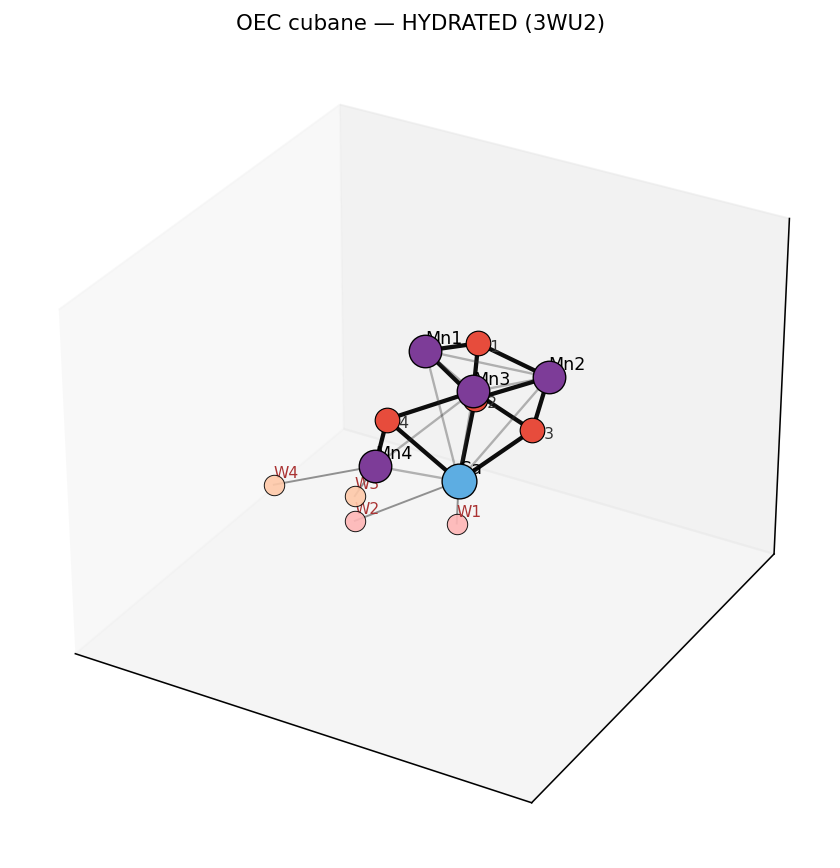

✅ Saved OEC_cubane_overview.png


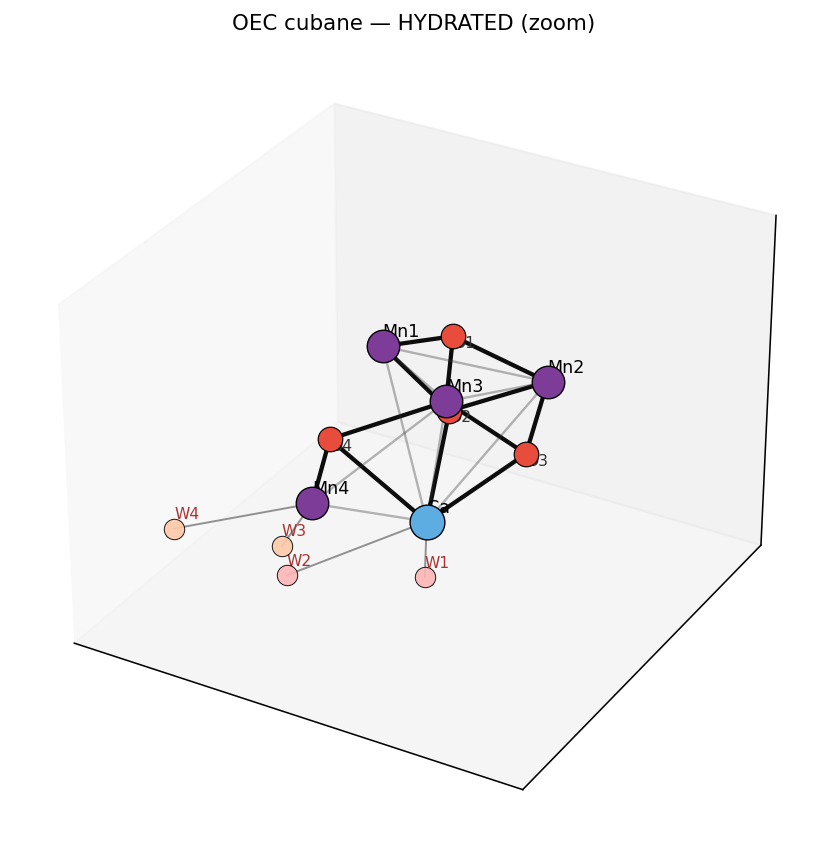

✅ Saved OEC_cubane_zoom.png


In [ ]:
# ================================================================
# OEC cubane from 3WU2.cif — robust μ-oxo detection + W1–W4 split
# Overview + Zoom panels; clean diagnostics
# ================================================================
import os, math, numpy as np, matplotlib.pyplot as plt

try:
    import gemmi
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "gemmi is required. In Colab run:\n  !pip -q install gemmi\nthen rerun this cell."
    )

# -------------------- USER SETTINGS --------------------
CIF_FILE   = "3WU2.cif"       # upload first
OUT_OV     = "OEC_cubane_overview.png"
OUT_ZOOM   = "OEC_cubane_zoom.png"
ZOOM_R     = 4.0              # Å radius around metal centroid
W_ANY_MAX  = 3.2              # Å water → any metal shortlist
W_CA_BIND  = 2.60             # Å W1/W2 Ca-bound cutoff
W_CA_FAR   = 3.2              # Å W3/W4 must be ≥ this far from Ca

# -------------------- HELPERS --------------------
def P(a): p=a.pos; return np.array([p.x, p.y, p.z], float)
def d(a,b): return float(np.linalg.norm(P(a)-P(b)))

def set_equal(ax, pts, pad=0.8):
    pts = np.asarray(pts); cx,cy,cz = pts.mean(axis=0)
    span = np.max(np.ptp(pts, axis=0))
    r = span * 0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def draw_bond(ax, A, B, color="k", lw=2.0, alpha=0.95):
    ax.plot([A[0],B[0]],[A[1],B[1]],[A[2],B[2]], color=color, lw=lw, alpha=alpha)

# -------------------- LOAD STRUCTURE --------------------
if not os.path.exists(CIF_FILE):
    raise FileNotFoundError(f"Upload {CIF_FILE} first.")

st = gemmi.read_structure(CIF_FILE)
st.remove_hydrogens()
model = st[0]

Mn_all, Ca_all, O_all, W_all = [], [], [], []
for ch in model:
    for res in ch:
        is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            el = a.element.name.upper()
            if el == "MN": Mn_all.append(a)
            elif el == "CA": Ca_all.append(a)
            elif el.startswith("O"):
                (W_all if is_w else O_all).append(a)

if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find at least 4×Mn and 1×Ca in the file.")

# -------------------- PICK Ca + Mn4 (same asymmetric unit) --------------------
Mn_xyz = np.array([P(a) for a in Mn_all], float)

# Ca atoms reasonably near any Mn (same crystal image)
Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
if not Ca_near:
    raise RuntimeError("No Ca within 6 Å of any Mn — check CIF symmetry or file path.")

def cubane_cost(mset, Ca_atom):
    pts = np.array([P(m) for m in mset])
    pair = sum(np.linalg.norm(pts[i]-pts[j]) for i in range(4) for j in range(i+1,4))
    cen  = pts.mean(axis=0)
    d_ca = np.linalg.norm(cen - P(Ca_atom))
    return pair + 2.5*d_ca  # weight Ca proximity

best_combo, best_cost = None, 1e9
from itertools import combinations
for Ca_atom in Ca_near:
    for combo in combinations(Mn_all, 4):
        cst = cubane_cost(combo, Ca_atom)
        if cst < best_cost:
            best_cost = cst
            best_combo = (Ca_atom, combo)

Ca1, Mn4 = best_combo
Mn4 = list(Mn4)
metals = [Ca1] + Mn4
met_pts = [P(m) for m in metals]

# -------------------- μ-OXO PICKER (prefer ≥3-bridging) --------------------
def pick_mu_oxo(oxy_atoms, metals, thr_mn_o=2.20, thr_ca_o=2.55, widen=0.05, max_mn=2.40, max_ca=2.70):
    def neighbors(o, t_mn, t_ca):
        nb = []
        for m in metals:
            dm = d(o, m)
            if (m.element.name.upper() == "MN" and dm <= t_mn) or \
               (m.element.name.upper() == "CA" and dm <= t_ca):
                nb.append((m, dm))
        return nb

    t_mn, t_ca = thr_mn_o, thr_ca_o
    while True:
        candidates = []
        for o in oxy_atoms:
            nb = neighbors(o, t_mn, t_ca)
            if len(nb) >= 2:
                deg = len(nb)
                tot = sum(dm for _, dm in nb)
                candidates.append((o, deg, tot))
        # prefer degree ≥3 first
        deg3 = [c for c in candidates if c[1] >= 3]
        pick_from = sorted(deg3, key=lambda x: (-x[1], x[2])) if deg3 \
                    else sorted(candidates, key=lambda x: (-x[1], x[2]))

        if len(pick_from) >= 4:
            return [c[0] for c in pick_from[:4]], t_mn, t_ca

        if t_mn + widen <= max_mn or t_ca + widen <= max_ca:
            t_mn = min(max_mn, t_mn + widen)
            t_ca = min(max_ca, t_ca + widen)
        else:
            return [c[0] for c in pick_from], t_mn, t_ca

muO, thr_mn_o, thr_ca_o = pick_mu_oxo(O_all, metals)
if len(muO) < 4:
    raise RuntimeError(f"Only found {len(muO)} μ-oxo (Mn–O≤{thr_mn_o:.2f}, Ca–O≤{thr_ca_o:.2f}).")

# -------------------- WATER CLASSIFICATION (W1/W2 vs W3/W4) --------------------
def classify_waters(waters, metals, Ca_atom, max_any=3.2, ca_bind=2.60, far_from_ca=3.2):
    close = [w for w in waters if min(d(w, m) for m in metals) <= max_any]
    ca_w  = sorted([w for w in close if d(w, Ca_atom) <= ca_bind], key=lambda w: d(w, Ca_atom))[:2]
    Mn_only = []
    for w in close:
        if w in ca_w:
            continue
        if d(w, Ca_atom) >= far_from_ca and any(m.element.name.upper()=="MN" and d(w,m) <= max_any for m in metals):
            Mn_only.append(w)
    chosen = []
    for w in sorted(Mn_only, key=lambda w: min(d(w,m) for m in metals if m.element.name.upper()=="MN")):
        if all(d(w, x) >= 1.2 for x in chosen):
            chosen.append(w)
        if len(chosen) == 2:
            break
    return ca_w, chosen

W_ca, W_mn = classify_waters(W_all, metals, Ca1, max_any=W_ANY_MAX, ca_bind=W_CA_BIND, far_from_ca=W_CA_FAR)
W = W_ca + W_mn
W_labels = {}
if len(W_ca) >= 1: W_labels[id(W_ca[0])] = "W1"
if len(W_ca) >= 2: W_labels[id(W_ca[1])] = "W2"
if len(W_mn) >= 1: W_labels[id(W_mn[0])] = "W3"
if len(W_mn) >= 2: W_labels[id(W_mn[1])] = "W4"

# -------------------- EDGES --------------------
# metal–μO
M_O_edges = []
for i, m in enumerate(metals):
    thr = thr_ca_o if m.element.name.upper()=="CA" else thr_mn_o
    for j, o in enumerate(muO):
        if d(m, o) <= thr:
            M_O_edges.append((i, j))

# metal–metal edge if they share at least one μ-O
MM_edges = set()
for i, j in combinations(range(len(metals)), 2):
    shared = any( ((i,k) in M_O_edges) and ((j,k) in M_O_edges) for k in range(len(muO)) )
    if shared:
        MM_edges.add((i, j))

# -------------------- DIAGNOSTIC --------------------
def tag(a):
    el = a.element.name
    sid = getattr(a, "serial", None)
    return f"{el}{'' if sid is None else ':'+str(sid)}"

print("— DIAGNOSTIC —")
print("Metals (expect Ca + 4 Mn):", [m.element.name for m in metals])
print("Inter-metal distances (Å):")
for i in range(len(metals)):
    for j in range(i+1, len(metals)):
        print(f"  {metals[i].element.name}-{metals[j].element.name}: {d(metals[i], metals[j]):.2f}")
print(f"μ-O selected: {len(muO)}  (Mn–O≤{thr_mn_o:.2f} Å, Ca–O≤{thr_ca_o:.2f} Å)")
for k, o in enumerate(muO, 1):
    nb = []
    for m in metals:
        dd = d(o, m)
        if (m.element.name.upper()=="MN" and dd<=thr_mn_o) or (m.element.name.upper()=="CA" and dd<=thr_ca_o):
            nb.append((m.element.name, f"{dd:.2f}"))
    print(f"  O{k}: {nb}")
print("Waters:", [W_labels.get(id(w), '?') for w in W])

# -------------------- DRAW --------------------
COL = {"MN":"#7D3C98", "CA":"#5DADE2", "O_MU":"#E74C3C", "W_CA":"#FFB6B6", "W_MN":"#FFC9A9"}
SZ  = {"MN":280, "CA":320, "O_MU":160, "W_CA":110, "W_MN":110}

def draw(ax, metals, muO, waters, title, W_ca, W_labels, zoom=None):
    pts = []
    # metals
    for idx, m in enumerate(metals):
        X = P(m); E = m.element.name.upper()
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[E], c=COL[E], ec="k", lw=0.7)
        ax.text(X[0], X[1], X[2]+0.22, "Ca" if E=="CA" else f"Mn{idx}", fontsize=9)
        pts.append(X)
    # μ-oxo
    for j, o in enumerate(muO, 1):
        X = P(o)
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ["O_MU"], c=COL["O_MU"], ec="k", lw=0.6)
        ax.text(X[0], X[1], X[2]-0.28, f"O{j}", fontsize=8, color="#333")
        pts.append(X)
    # bonds M–O
    for i, j in M_O_edges:
        draw_bond(ax, P(metals[i]), P(muO[j]), "k", 2.2, 0.95)
    # cubane MM (light)
    for i, j in MM_edges:
        draw_bond(ax, P(metals[i]), P(metals[j]), "#333", 1.2, 0.35)
    # waters
    def nearest_metal(pt):
        mm = min(metals, key=lambda m: np.linalg.norm(P(m)-pt))
        return mm, np.linalg.norm(P(mm)-pt)

    for w in waters:
        X = P(w)
        is_ca_side = any(id(w) == id(x) for x in W_ca)
        key = "W_CA" if is_ca_side else "W_MN"
        ax.scatter([X[0]],[X[1]],[X[2]], s=SZ[key], c=COL[key], ec="k", lw=0.5, alpha=0.9)
        ax.text(X[0], X[1], X[2]+0.22, W_labels.get(id(w), "W"), fontsize=8, color="#a33")
        m_near, dnm = nearest_metal(X)
        if dnm <= 2.5:
            draw_bond(ax, X, P(m_near), "#666", 1.0, 0.7)
        pts.append(X)

    ax.set_title(title)
    if zoom is None:
        set_equal(ax, pts)
    else:
        cx, cy, cz, r = zoom
        ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Overview
fig = plt.figure(figsize=(7.8, 6.3))
ax  = fig.add_subplot(111, projection='3d')
draw(ax, metals, muO, W, "OEC cubane — HYDRATED (3WU2)", W_ca, W_labels, zoom=None)
plt.tight_layout(); plt.savefig(OUT_OV, dpi=300); plt.show()
print("✅ Saved", OUT_OV)

# Zoom
cen = np.mean(np.array([P(m) for m in metals]), axis=0)
fig2 = plt.figure(figsize=(6.6, 6.2))
ax2  = fig2.add_subplot(111, projection='3d')
draw(ax2, metals, muO, W, "OEC cubane — HYDRATED (zoom)", W_ca, W_labels,
     zoom=(cen[0], cen[1], cen[2], ZOOM_R))
plt.tight_layout(); plt.savefig(OUT_ZOOM, dpi=300); plt.show()
print("✅ Saved", OUT_ZOOM)

In [ ]:
# [001] ================================================================
# [002] OEC CaMn4O5 (+waters) -> TDSE demo with GQR gating
# [003] Electron & proton tight-binding, time-dependent drive,
# [004] resonance comb, hydration, and export of frames + CSV.
# [005] ================================================================
import os, math, csv, numpy as np
import matplotlib.pyplot as plt

# [010] ---------- OUTPUT ----------
OUT_DIR = "OEC_GQR_TDSE"
FRAMES_DIR = os.path.join(OUT_DIR, "frames")
os.makedirs(FRAMES_DIR, exist_ok=True)
CSV_PATH = os.path.join(OUT_DIR, "populations.csv")

# [015] ---------- PHYSICS / UNITS ----------
hbar = 6.582119569e-16  # eV·s
# Small Hilbert sizes (<= 20) -> exact spectral propagation is fine.

# [020] ---------- OEC SITES (edit with CIF-derived coords if you have them) ----------
# Types: 'Ca','Mn','Omu' (μ-oxo), 'W' (water), optional 'Ch' (channel node)
# Positions in Å and a compact but plausible cubane layout:
SITE_COORDS = [
    # metals
    ("Ca",  "Ca",  [ 0.00,  0.00,  0.00]),
    ("Mn1", "Mn",  [ 2.90,  0.10,  0.00]),
    ("Mn2", "Mn",  [ 0.00,  3.00,  0.10]),
    ("Mn3", "Mn",  [-2.85,  0.05,  0.00]),
    ("Mn4", "Mn",  [ 0.05, -2.95,  0.10]),  # "dangler" region near Ca
    # μ-oxo bridges (between metals)
    ("O1",  "Omu", [ 1.40,  1.40,  0.00]),
    ("O2",  "Omu", [-1.40,  1.45,  0.00]),
    ("O3",  "Omu", [-1.40, -1.45,  0.05]),
    ("O4",  "Omu", [ 1.45, -1.40,  0.05]),
    # waters (two "substrate" near Ca; two distal)
    ("W1",  "W",   [ 0.00,  1.85, -1.20]),
    ("W2",  "W",   [ 0.00, -1.80, -1.25]),
    ("W3",  "W",   [ 3.10,  2.80,  1.10]),
    ("W4",  "W",   [-3.10, -2.70,  1.15]),
    # optional channel nodes (toy targets)
    ("ChA", "Ch",  [ 0.00,  5.0,   0.0]),
    ("ChB", "Ch",  [ 0.00, -5.0,   0.0]),
]

labels = [s[0] for s in SITE_COORDS]
types  = [s[1] for s in SITE_COORDS]
pos    = np.array([s[2] for s in SITE_COORDS], dtype=float)
N      = len(SITE_COORDS)

# [050] ---------- GRAPH COUPLINGS (base, before GQR gates) ----------
# Distance-based hopping templates (eV). Tuned to give visible dynamics.
def base_hopping(i, j):
    pi, pj = pos[i], pos[j]
    dij = np.linalg.norm(pi - pj)
    ti, tj = types[i], types[j]
    # stronger across μ-oxo bridges & metal-metal within ~3.3 Å
    if {"Mn","Omu"} == {ti,tj} and dij <= 2.2:  return 0.090
    if {"Ca","Omu"} == {ti,tj} and dij <= 2.6:  return 0.050
    if {"Mn","Mn"}  == {ti,tj} and dij <= 3.3:  return 0.035
    if {"Ca","Mn"}  == {ti,tj} and dij <= 3.8:  return 0.025
    # waters couple weaker; nearer to Ca/Mn get some coupling
    if "W" in (ti,tj) and dij <= 3.0:         return 0.010
    # channels: weak long-range leakage
    if "Ch" in (ti,tj) and dij <= 5.5:        return 0.006
    return 0.0

# [070] ---------- GQR GATES & DRIVE ----------
class GQRDrive:
    def __init__(self,
                 Amp_H=0.30,      # aperture/funnel strength (0..0.5 typical enzymes)
                 Duty=1.5,        # coherence duty factor (>1 widens window)
                 CombAmp=2.0,     # resonance comb gain
                 CombWidth=0.25,  # comb width in Å (0.1..0.4)
                 Hydrated=True,   # hydration reduces loss, boosts duty
                 E_DC=0.20,       # DC bias in eV
                 E_AC=0.60,       # AC amplitude in eV
                 f_AC=1.2e12,     # AC frequency in Hz (toy)
                 field_dir=np.array([0,1,0])  # uniform field direction (C gate)
                 ):
        self.Amp_H = Amp_H
        self.Duty  = Duty * (1.15 if Hydrated else 1.0)
        self.CombAmp   = CombAmp
        self.CombWidth = CombWidth
        self.Hydrated  = Hydrated
        self.E_DC = E_DC
        self.E_AC = E_AC
        self.f_AC = f_AC
        self.field_dir = field_dir / (np.linalg.norm(field_dir)+1e-12)
        # shield/loss params (simplified)
        self.alpha = 0.08 if Hydrated else 0.16
        self.d0    = 0.8
        self.pwr   = 2.0

    def shield_loss(self, d):
        S = 1.0 - self.alpha*np.exp(-(d/self.d0)**self.pwr)
        return np.clip(S, 1e-3, 1.0)

    def resonance_comb(self, d):
        centers = np.array([0.7, 1.0, 1.5, 2.2])
        num = np.sum(self.CombWidth**2 / ((d-centers[:,None])**2 + self.CombWidth**2), axis=0)
        num /= (np.max(num) + 1e-12)
        return 1.0 + self.CombAmp * num * np.exp(-d/3.0)

    def field_tilt(self, t, r):
        # Onsite tilt = q * E(t)·r ; we just use E(t)*projection for sign
        E_t = self.E_DC + self.E_AC*np.sin(2*np.pi*self.f_AC*t)
        return E_t * float(np.dot(self.field_dir, r) / (np.linalg.norm(r)+1e-12))

# [120] ---------- BUILD HAMILTONIANS ----------
def build_hoppings(gqr: GQRDrive):
    # pairwise distances matrix
    D = np.linalg.norm(pos[:,None,:] - pos[None,:,:], axis=2) + np.eye(N)*1e9
    # base hopping
    T0 = np.zeros((N,N), dtype=float)
    for i in range(N):
        for j in range(i+1, N):
            T0[i,j] = T0[j,i] = base_hopping(i,j)
    # resonance comb multiplier as function of |Δr|
    Comb = gqr.resonance_comb(D)
    # shield loss by "edge length" (proxy)
    Loss = gqr.shield_loss(D)
    # aperture/funnel (H): amplify short edges more than long ones
    Hgain = 1.0 + gqr.Amp_H * np.exp(-D/1.2)
    # combine (and apply duty as global scale)
    T = T0 * Comb * Loss * Hgain * gqr.Duty
    return T

def onsite_vector(gqr: GQRDrive, t):
    # Onsite energies (per site) from field lens (C) + modest type-specific offsets
    eps = np.zeros(N, dtype=float)
    base = {"Ca":0.00, "Mn":0.05, "Omu":-0.02, "W":-0.01, "Ch":-0.03}
    for i,ty in enumerate(types):
        tilt = gqr.field_tilt(t, pos[i])
        eps[i] = base.get(ty,0.0) + tilt
    return eps

# [160] ---------- SPECIES-SPECIFIC SCALING ----------
# Electrons vs protons get different global prefactors to mimic β differences
def species_scale(species):
    if species == "e": return 1.0     # electrons hop faster
    if species == "H": return 0.35    # protons slower effective hopping
    return 1.0

# [170] ---------- EXACT PROPAGATOR ----------
def exact_propagator(H):
    # H Hermitian (eV). Return eigenbasis for fast U(t) application.
    E, V = np.linalg.eigh(H)
    return E, V

def apply_U(E, V, psi0, dt):
    phase = np.exp(-1j*E*dt/hbar)
    return V @ (phase * (V.conj().T @ psi0))

# [185] ---------- INITIAL STATES ----------
# Start electron near TyrZ/μ-oxo region: here O1; proton near W1
i_e0 = labels.index("O1")
i_H0 = labels.index("W1")
psi_e = np.zeros(N, dtype=complex); psi_e[i_e0] = 1.0
psi_H = np.zeros(N, dtype=complex); psi_H[i_H0] = 1.0

# [195] ---------- DRIVE / RUNTIME ----------
gqr = GQRDrive(
    Amp_H=0.32, Duty=1.8, CombAmp=3.0, CombWidth=0.28,
    Hydrated=True, E_DC=0.20, E_AC=0.60, f_AC=8.0e11,
    field_dir=np.array([0,1,0])
)

T_e = build_hoppings(gqr) * species_scale("e")
T_H = build_hoppings(gqr) * species_scale("H")

# [210] time grid (short demo; increase STEPS for longer movies)
T_TOTAL = 1.2e-12  # s
STEPS   = 120
dt      = T_TOTAL / STEPS

# [215] ---------- RECORD + DRAW ----------
def draw_frame(t_idx, t_val, psi_e, psi_H, gqr, ylims=(0,5)):
    fig = plt.figure(figsize=(9.6,4.6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    pe = (psi_e*psi_e.conj()).real
    pH = (psi_H*psi_H.conj()).real

    # 3D scatter: size encodes populations (electron = orange, proton = blue outline)
    sizes_e = 200 * (pe/pe.max()+1e-6)
    sizes_H = 200 * (pH/pH.max()+1e-6)

    for i in range(N):
        x,y,z = pos[i]
        # electron
        ax1.scatter([x],[y],[z], s=sizes_e[i], color='darkorange', alpha=0.7, edgecolor='k', linewidth=0.3)
        # proton overlay
        ax1.scatter([x],[y],[z], s=sizes_H[i]*0.6, facecolor='none', edgecolor='royalblue', linewidth=1.0)

        # labels for key sites
        if types[i] in ("Mn","Ca","Omu","W"):
            ax1.text(x,y,z+0.18, labels[i], fontsize=8)

    # equal-ish axes
    center = pos.mean(axis=0)
    span = max(np.ptp(pos[:,0]), np.ptp(pos[:,1]), np.ptp(pos[:,2]))*0.65 + 1.0
    ax1.set_xlim(center[0]-span, center[0]+span)
    ax1.set_ylim(center[1]-span, center[1]+span)
    ax1.set_zlim(center[2]-span, center[2]+span)
    ax1.set_title(f"3D populations @ t={t_val*1e12:.2f} ps")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])

    # 2D bar plot of populations (left=electron, right=proton)
    idx = np.arange(N)
    ax2.bar(idx-0.2, pe, width=0.38, color='darkorange', label='e⁻')
    ax2.bar(idx+0.2, pH, width=0.38, color='royalblue', label='H⁺', alpha=0.8)
    ax2.set_xticks(idx); ax2.set_xticklabels(labels, rotation=90)
    ax2.set_ylim(0, max(ylims[1], 1.2*max(pe.max(), pH.max())))
    ax2.grid(axis='y', alpha=0.25)
    ax2.legend(loc='upper right')
    ax2.set_title("Site populations")

    # annotate key GQR settings
    txt = (f"Amp_H={gqr.Amp_H:.2f}  Duty={gqr.Duty:.2f}\n"
           f"Comb(A={gqr.CombAmp:.1f}, w={gqr.CombWidth:.2f})\n"
           f"E(t)= {gqr.E_DC:.2f} + {gqr.E_AC:.2f}·sin(2π·{gqr.f_AC/1e12:.2f} THz)")
    ax2.text(0.02, 0.95, txt, transform=ax2.transAxes, va='top',
             bbox=dict(facecolor='white', alpha=0.85, edgecolor='none'), fontsize=9)

    plt.tight_layout()
    fpath = os.path.join(FRAMES_DIR, f"frame_{t_idx:04d}.png")
    plt.savefig(fpath, dpi=200)
    plt.close()
    return fpath

# [275] ---------- RUN ----------
with open(CSV_PATH, "w", newline="") as fcsv:
    w = csv.writer(fcsv)
    w.writerow(["t_s","species","site","pop"])

    frame_paths = []
    for n in range(STEPS+1):
        t = n*dt

        # time-dependent onsite energies (field lens C gate)
        eps_t = onsite_vector(gqr, t)

        # Hamiltonians: H = eps + hopping
        He = np.diag(eps_t) + T_e
        HH = np.diag(eps_t*0.6) + T_H  # proton sees smaller field shift (heuristic)

        # exact step
        Ee, Ve = exact_propagator(He)
        EH, VH = exact_propagator(HH)
        psi_e = apply_U(Ee, Ve, psi_e, dt)
        psi_H = apply_U(EH, VH, psi_H, dt)

        # record
        pe = (psi_e*psi_e.conj()).real
        pH = (psi_H*psi_H.conj()).real
        for i in range(N):
            w.writerow([t, "e", labels[i], pe[i]])
            w.writerow([t, "H", labels[i], pH[i]])

        # draw a subset of frames (every step is fine for short runs)
        frame_paths.append(draw_frame(n, t, psi_e, psi_H, gqr))

print(f"✅ Wrote {len(frame_paths)} frames to {FRAMES_DIR}")
print(f"✅ Populations CSV: {CSV_PATH}")

# [310] TIP:
# Use:  !ffmpeg -y -framerate 24 -i OEC_GQR_TDSE/frames/frame_%04d.png -pix_fmt yuv420p OEC_GQR_TDSE/movie.mp4
# in Colab to make a movie.

ValueError: operands could not be broadcast together with shapes (15,15) (4,1) 

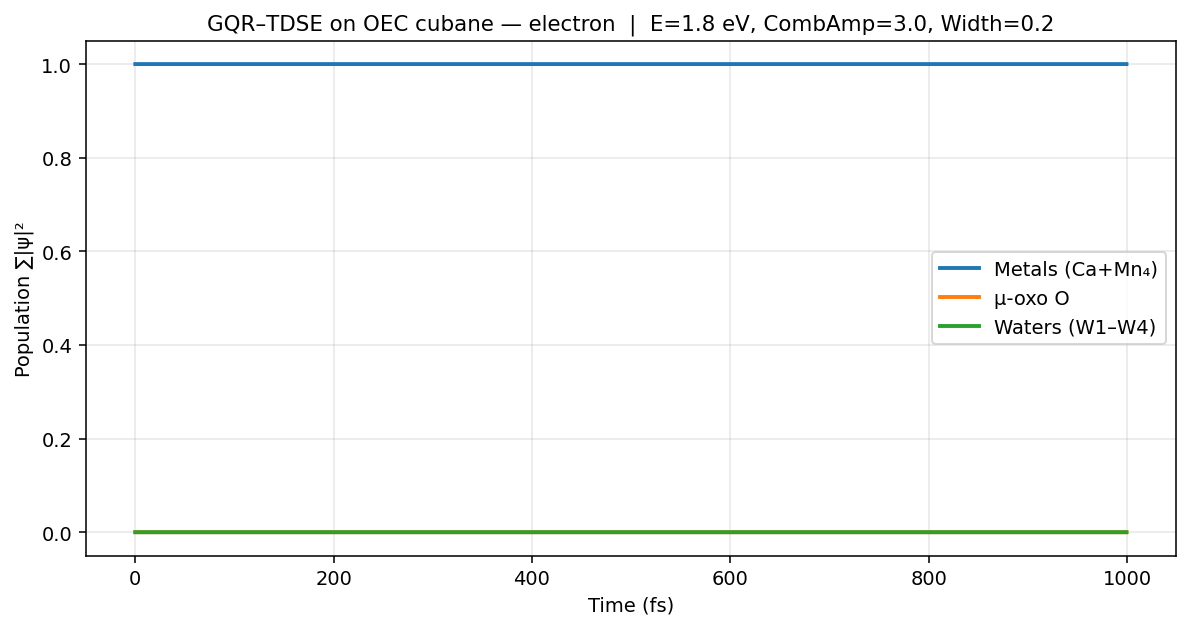

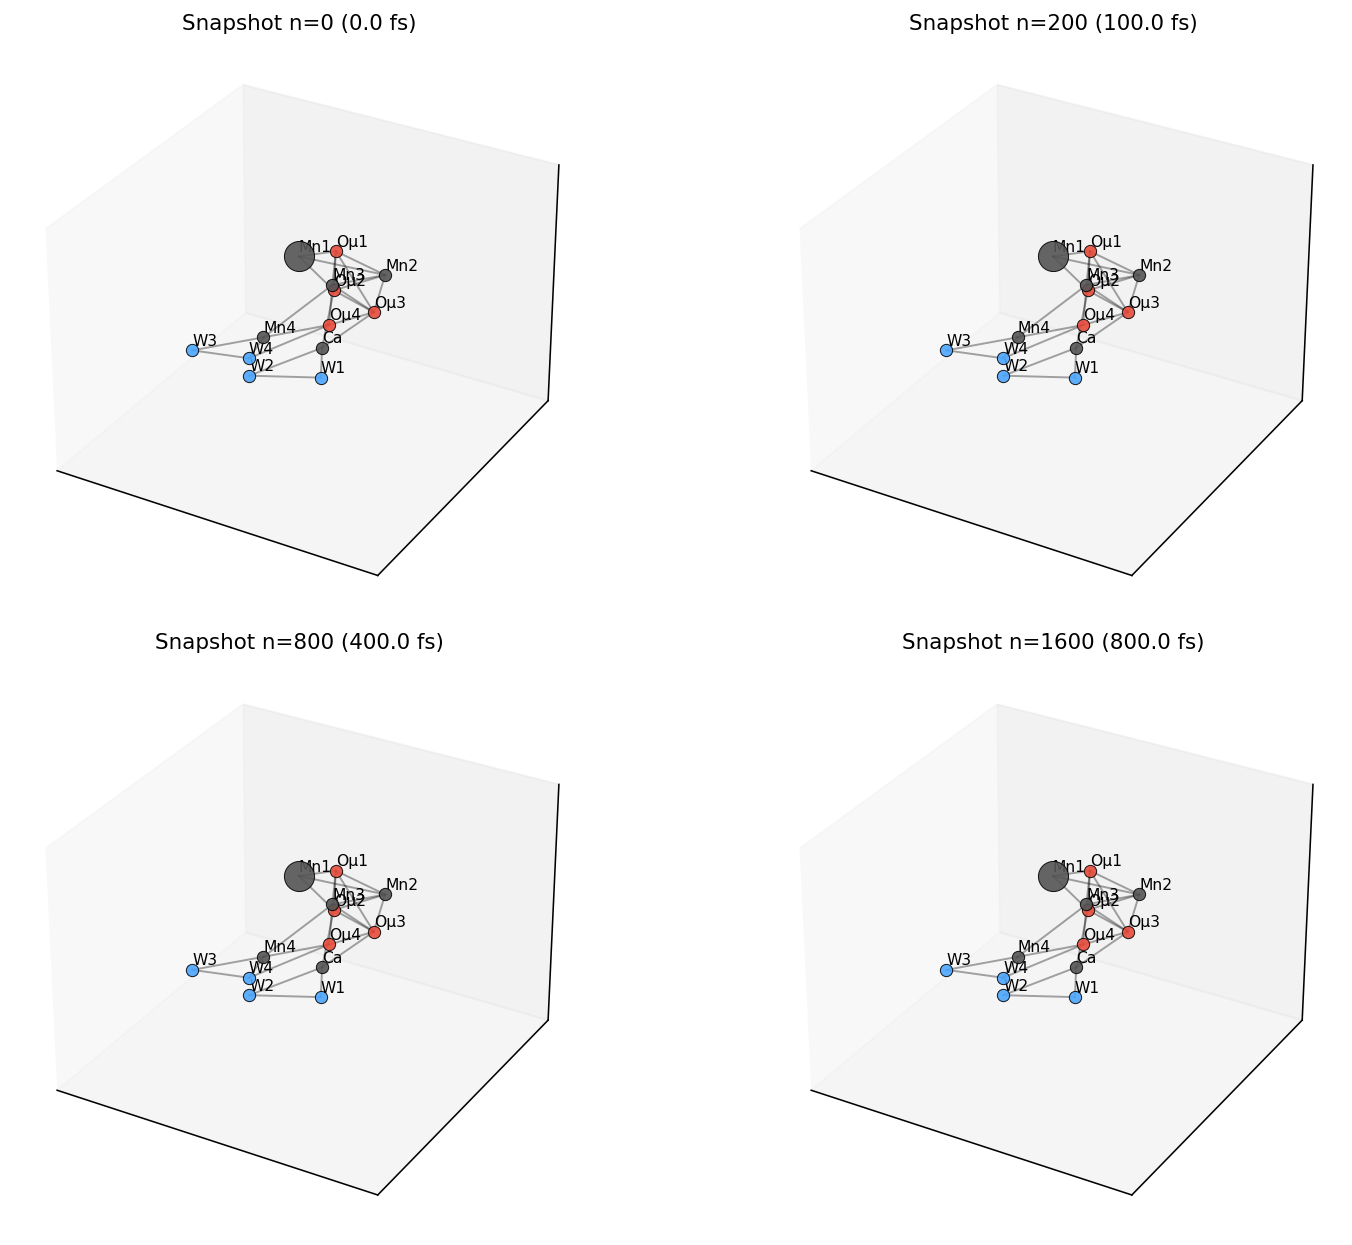

N nodes: 13
Labels: ['Ca', 'Mn1', 'Mn2', 'Mn3', 'Mn4', 'Oμ1', 'Oμ2', 'Oμ3', 'Oμ4', 'W1', 'W2', 'W3', 'W4']
Groups: ['metal', 'metal', 'metal', 'metal', 'metal', 'mu-oxo', 'mu-oxo', 'mu-oxo', 'mu-oxo', 'water', 'water', 'water', 'water']


In [ ]:
# [001] ================================================================
# [002] OEC (3WU2.cif) → GQR–TDSE tunnelling on CaMn4O5 + 4 waters
# [003] - Extract Ca + Mn4 + μ-oxo bridges + 4 near waters
# [004] - Build GQR-modified Hamiltonian on the graph
# [005] - Time-propagate ψ(t) with eigen-decomposition at each step
# [006] - Plots: group populations vs time, and 3D snapshots
# [007] ================================================================
# [008] Colab note: upload 3WU2.cif (dark-adapted S1) to the runtime first.
# [009]
# [010] Dependencies: numpy, matplotlib, gemmi
# [011] ================================================================
!pip -q install gemmi

# [015] ---------- Imports ----------
import os, numpy as np, matplotlib.pyplot as plt, gemmi
from itertools import combinations

# [020] ---------- User controls ----------
CIF_PATH   = "3WU2.cif"   # upload beforehand
SPECIES    = 'e'          # 'e' for electron, 'H' for proton
E_eV       = 1.8          # driving "field/energy" level (physiological upper ~1.8 eV)
DT         = 0.5e-15      # time step (s) ~0.5 fs
NSTEPS     = 2000         # number of time-steps
SNAP_STEPS = [0, 200, 800, 1600]   # frames to snapshot in 3D

# [030] GQR knobs (tune as you like)
COMB_AMP    = 3.0         # 1–5 reasonable in OEC discussions
COMB_WIDTH  = 0.20        # 0.1–0.3 Å typical
ALPHA_SH    = 0.14        # shield loss baseline
D0_SH       = 0.8         # Å
P_SH        = 2.0
DUTY_MAX_e  = 1.9         # hydrated duty limit — electrons
DUTY_MAX_H  = 2.1         # hydrated duty limit — protons
ETA_MAX_e   = 0.30        # aperture cap — electrons
ETA_MAX_H   = 0.38        # aperture cap — protons
SIG_E0_e    = 0.30        # sigmoid center for e-
SIG_E0_H    = 0.45        # sigmoid center for H
SIG_K_e     = 4.0         # sigmoid steepness
SIG_K_H     = 3.5

# [045] Baseline tunnelling prefactors/decays (slower for H)
R0_e, BETA_e = 1.68e11, 0.64
R0_H, BETA_H = 9.42e3,  0.77
T0_e, T0_H   = 1.0,     1.0    # overall coupling scales (unitless here)

# [050] ---------- Helpers ----------
def P(a):
    p=a.pos; return np.array([p.x, p.y, p.z], float)

def set_equal(ax, pts, pad=0.8):
    pts = np.asarray(pts); cx,cy,cz = pts.mean(axis=0)
    r = max(np.ptp(pts, axis=0)) * 0.65 + pad
    ax.set_xlim(cx-r, cx+r); ax.set_ylim(cy-r, cy+r); ax.set_zlim(cz-r, cz+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

def dist(a,b): return float(np.linalg.norm(a-b))

def lorentzian(d, c, g): return (g*g)/((d-c)**2 + g*g)

def resonance_comb(d, amp, width, centers=(0.7, 1.0, 1.5, 2.2), taper_len=3.0):
    s = 0.0
    for c in centers: s += lorentzian(d, c, width)
    s = s / (s if np.isscalar(s) else (np.max(s)+1e-12))
    taper = np.exp(-d / taper_len)
    return 1.0 + amp * s * taper

def shield_loss(d, alpha, d0, p):
    S = 1.0 - alpha*np.exp(-(d/d0)**p)
    return np.clip(S, 1e-6, 1.0)

def sigmoid(x, x0, k): return 1.0/(1.0 + np.exp(-k*(x-x0)))

# [085] ---------- Load CIF and select cubane + waters ----------
if not os.path.exists(CIF_PATH):
    raise FileNotFoundError("Upload 3WU2.cif first (dark-adapted S1 state).")

st = gemmi.read_structure(CIF_PATH)
st.remove_hydrogens()
model = st[0]

Mn_all, Ca_all, O_all, Wat_all = [], [], [], []
for ch in model:
    for res in ch:
        is_w = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            e = a.element.name.upper()
            if e == "MN": Mn_all.append(a)
            elif e == "CA": Ca_all.append(a)
            elif e.startswith("O"):
                (Wat_all if is_w else O_all).append(a)

if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find Ca + ≥4 Mn in 3WU2.cif")

Mn_xyz = np.array([P(a) for a in Mn_all])
# pick Ca near Mn cluster (same asym unit)
Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
if not Ca_near:
    # fallback: just nearest Ca to Mn centroid
    cen = Mn_xyz.mean(axis=0)
    Ca_near = [min(Ca_all, key=lambda a: np.linalg.norm(P(a)-cen))]

def cubane_cost(mset, Ca_atom):
    pts = np.array([P(m) for m in mset])
    pair = sum(np.linalg.norm(pts[i]-pts[j]) for i in range(4) for j in range(i+1,4))
    cen  = pts.mean(axis=0)
    d_ca = np.linalg.norm(cen - P(Ca_atom))
    return pair + 2.5*d_ca

best_combo, best_cost = None, 1e9
for Ca_atom in Ca_near:
    for combo in combinations(Mn_all, 4):
        cst = cubane_cost(combo, Ca_atom)
        if cst < best_cost:
            best_cost = cst
            best_combo = (Ca_atom, combo)

Ca1, Mn4 = best_combo
Mn4 = list(Mn4)
metals = [Ca1] + Mn4
met_pts = [P(m) for m in metals]

# μ-oxo search with adaptive cutoffs
thr_mn_o, thr_ca_o = 2.20, 2.55
def find_mu_oxo(O_list, metals, t_mn, t_ca):
    found=[]
    for o in O_list:
        po = P(o)
        neighbors=[]
        for m in metals:
            dm = np.linalg.norm(po - P(m))
            if (m.element.name.upper()=="MN" and dm<=t_mn) or \
               (m.element.name.upper()=="CA" and dm<=t_ca):
                neighbors.append((m, dm))
        if len(neighbors) >= 2:
            tot = sum(d for _,d in neighbors)
            found.append((o, len(neighbors), tot))
    found.sort(key=lambda t: (-t[1], t[2]))
    return [t[0] for t in found]

muO = find_mu_oxo(O_all, metals, thr_mn_o, thr_ca_o)
while len(muO) < 4 and thr_mn_o < 2.40:
    thr_mn_o += 0.05; thr_ca_o += 0.05
    muO = find_mu_oxo(O_all, metals, thr_mn_o, thr_ca_o)
muO = muO[:4]

# waters: nearest to Ca, within 3.0 Å to any metal
cand=[]
for w in Wat_all:
    pw = P(w)
    if min(np.linalg.norm(pw - P(m)) for m in metals) <= 3.0:
        cand.append((w, np.linalg.norm(pw - P(Ca1))))
cand.sort(key=lambda t: t[1])
W4 = [t[0] for t in cand[:4]]

# [170] ---------- Build node list ----------
nodes = []
labels = []
groups = []  # 'metal','mu-oxo','water'
# metals
for i,m in enumerate(metals):
    nodes.append(P(m))
    labels.append('Ca' if i==0 else f'Mn{i}')
    groups.append('metal')
# mu-oxo
for j,o in enumerate(muO,1):
    nodes.append(P(o))
    labels.append(f'Oμ{j}')
    groups.append('mu-oxo')
# waters
for k,w in enumerate(W4,1):
    nodes.append(P(w))
    labels.append(f'W{k}')
    groups.append('water')

nodes = np.array(nodes)   # shape (N,3)
N = len(nodes)
idx_metal  = [i for i,g in enumerate(groups) if g=='metal']
idx_muoxo  = [i for i,g in enumerate(groups) if g=='mu-oxo']
idx_water  = [i for i,g in enumerate(groups) if g=='water']

# [195] ---------- Species parameters ----------
if SPECIES == 'e':
    beta0, R0, T0 = BETA_e, R0_e, T0_e
    ETA_MAX, SIG_E0, SIG_K = ETA_MAX_e, SIG_E0_e, SIG_K_e
    DUTY_MAX = DUTY_MAX_e
    color = 'darkorange'
else:
    beta0, R0, T0 = BETA_H, R0_H, T0_H
    ETA_MAX, SIG_E0, SIG_K = ETA_MAX_H, SIG_E0_H, SIG_K_H
    DUTY_MAX = DUTY_MAX_H
    color = 'royalblue'

# [210] ---------- GQR parameter maps (edge-length dependent) ----------
def edge_modulators(r, psi_edge_strength):
    """Return (beta_eff, duty, shield, comb) for an edge of length r.
       psi_edge_strength (0..1) weakens shield loss when occupancy builds.
    """
    etaH  = ETA_MAX * sigmoid(E_eV, SIG_E0, SIG_K) if E_eV>0 else 0.0
    duty  = 1.0 + (DUTY_MAX-1.0)*sigmoid(E_eV, SIG_E0, SIG_K) if E_eV>0 else 1.0
    beta_eff = max(beta0*(1.0-etaH), 0.20)
    # feedback: reduce alpha with occupancy
    alpha_eff = ALPHA_SH * (1.0 - 0.5*psi_edge_strength)
    shield = shield_loss(r, alpha=alpha_eff, d0=D0_SH, p=P_SH)
    comb   = resonance_comb(r, COMB_AMP, COMB_WIDTH)
    return beta_eff, duty, shield, comb

# [230] ---------- Build Hamiltonian at a given ψ (feedback on shield) ----------
def build_H(psi):
    # edge "occupancy": use pairwise |psi_i||psi_j| normalized
    amp = np.abs(psi)
    if amp.max() <= 0: occ_scale = np.zeros((N,N))
    else:
        occ_scale = np.outer(amp, amp) / (amp.max()**2 + 1e-15)

    H = np.zeros((N,N), complex)
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.linalg.norm(nodes[i]-nodes[j])
            if r_ij < 0.5 or r_ij > 6.0:
                continue  # only couple chemically plausible distances
            # base tunnelling decay
            # GQR gain multiplies relative to the bare exp(-βr)
            beta_eff, duty, shield, comb = edge_modulators(r_ij, occ_scale[i,j])
            gain  = np.exp((beta0 - beta_eff)*r_ij) * comb * shield * duty
            t_ij = T0 * np.exp(-beta0*r_ij) * gain
            H[i,j] = t_ij
            H[j,i] = np.conj(t_ij)
    # zero onsite energies (you can add site terms if desired)
    return H

# [260] ---------- TDSE propagator ----------
ħ = 1.054571817e-34  # J*s (unused if we run in scaled units)
# We'll treat H as in arbitrary energy units and use dt as scaled time.
# The per-step evolution uses eigendecomposition of H(ψ_t).

def step_tdse(psi, dt):
    H = build_H(psi)
    # Hermitian by construction; eigh returns real eigenvals
    E, V = np.linalg.eigh(H)
    Udt = V @ np.diag(np.exp(-1j * E * dt)) @ V.conj().T
    psi_next = Udt @ psi
    # renormalize
    psi_next /= np.linalg.norm(psi_next) + 1e-15
    return psi_next

# [280] ---------- Initial state: localized on Mn1 (or Ca) ----------
psi = np.zeros(N, complex)
# Start on Mn1 (index 1 in the metals block [Ca,Mn1,Mn2,Mn3,Mn4])
start_idx = 1
psi[start_idx] = 1.0

# [290] ---------- Simulate ----------
t_arr = np.arange(NSTEPS)*DT
pop_metal = []
pop_muoxo = []
pop_water = []
snaps = {}

for n in range(NSTEPS):
    amp2 = np.abs(psi)**2
    pop_metal.append(amp2[idx_metal].sum())
    pop_muoxo.append(amp2[idx_muoxo].sum())
    pop_water.append(amp2[idx_water].sum())
    if n in SNAP_STEPS:
        snaps[n] = amp2.copy()
    psi = step_tdse(psi, DT)

pop_metal  = np.array(pop_metal)
pop_muoxo  = np.array(pop_muoxo)
pop_water  = np.array(pop_water)

# [315] ---------- Plots ----------
# A) Populations vs time
plt.figure(figsize=(8.6,4.6))
plt.plot(t_arr*1e15, pop_metal,  label='Metals (Ca+Mn₄)', lw=2.0)
plt.plot(t_arr*1e15, pop_muoxo, label='μ-oxo O', lw=2.0)
plt.plot(t_arr*1e15, pop_water, label='Waters (W1–W4)', lw=2.0)
plt.xlabel('Time (fs)')
plt.ylabel('Population ∑|ψ|²')
plt.title(f'GQR–TDSE on OEC cubane — {("electron" if SPECIES=="e" else "proton")}  |  E={E_eV} eV, CombAmp={COMB_AMP}, Width={COMB_WIDTH}')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# B) 3D snapshots
def draw_snapshot(ax, amp2, title):
    # normalize amplitudes for marker scaling
    s = 200 * (amp2 / (amp2.max() + 1e-15)) + 40
    # colors by group
    cols=[]
    for g in groups:
        if g=='metal': cols.append('#555555')
        elif g=='mu-oxo': cols.append('#E74C3C')
        else: cols.append('#4DA6FF')
    for i in range(N):
        x,y,z = nodes[i]
        ax.scatter([x],[y],[z], s=s[i], c=cols[i], ec='k', lw=0.5, alpha=0.9)
        ax.text(x,y,z+0.25, labels[i], fontsize=8)
    # draw heuristic edges for “chemically plausible” connections
    for i in range(N):
        for j in range(i+1,N):
            r = np.linalg.norm(nodes[i]-nodes[j])
            if r <= 3.2:  # show near-neighbor edges
                xi,yi,zi = nodes[i]; xj,yj,zj = nodes[j]
                ax.plot([xi,xj],[yi,yj],[zi,zj], color='k', lw=1.0, alpha=0.35)
    ax.set_title(title)
    set_equal(ax, nodes)

fig = plt.figure(figsize=(12,9))
rows = int(np.ceil(len(SNAP_STEPS)/2))
for k,n in enumerate(SNAP_STEPS, start=1):
    ax = fig.add_subplot(rows,2,k, projection='3d')
    draw_snapshot(ax, snaps[n], f"Snapshot n={n} ({t_arr[n]*1e15:.1f} fs)")
plt.tight_layout()
plt.show()

# [370] ---------- Simple textual diagnostics ----------
print("N nodes:", N)
print("Labels:", labels)
print("Groups:", groups)

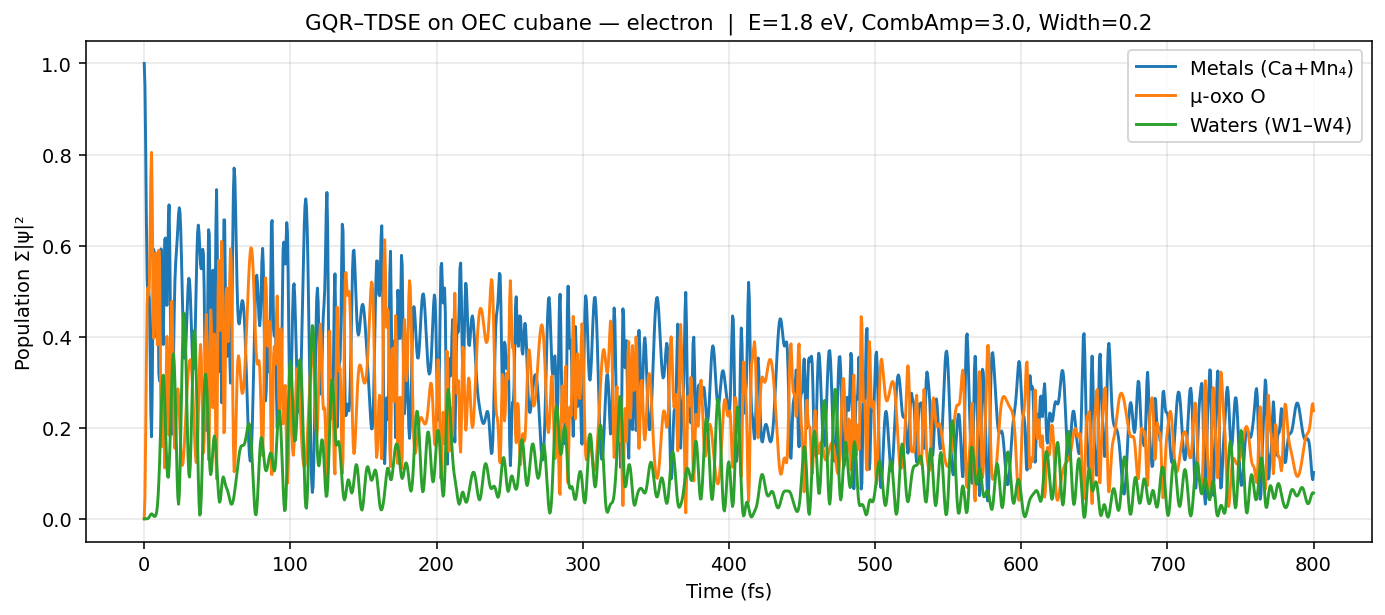

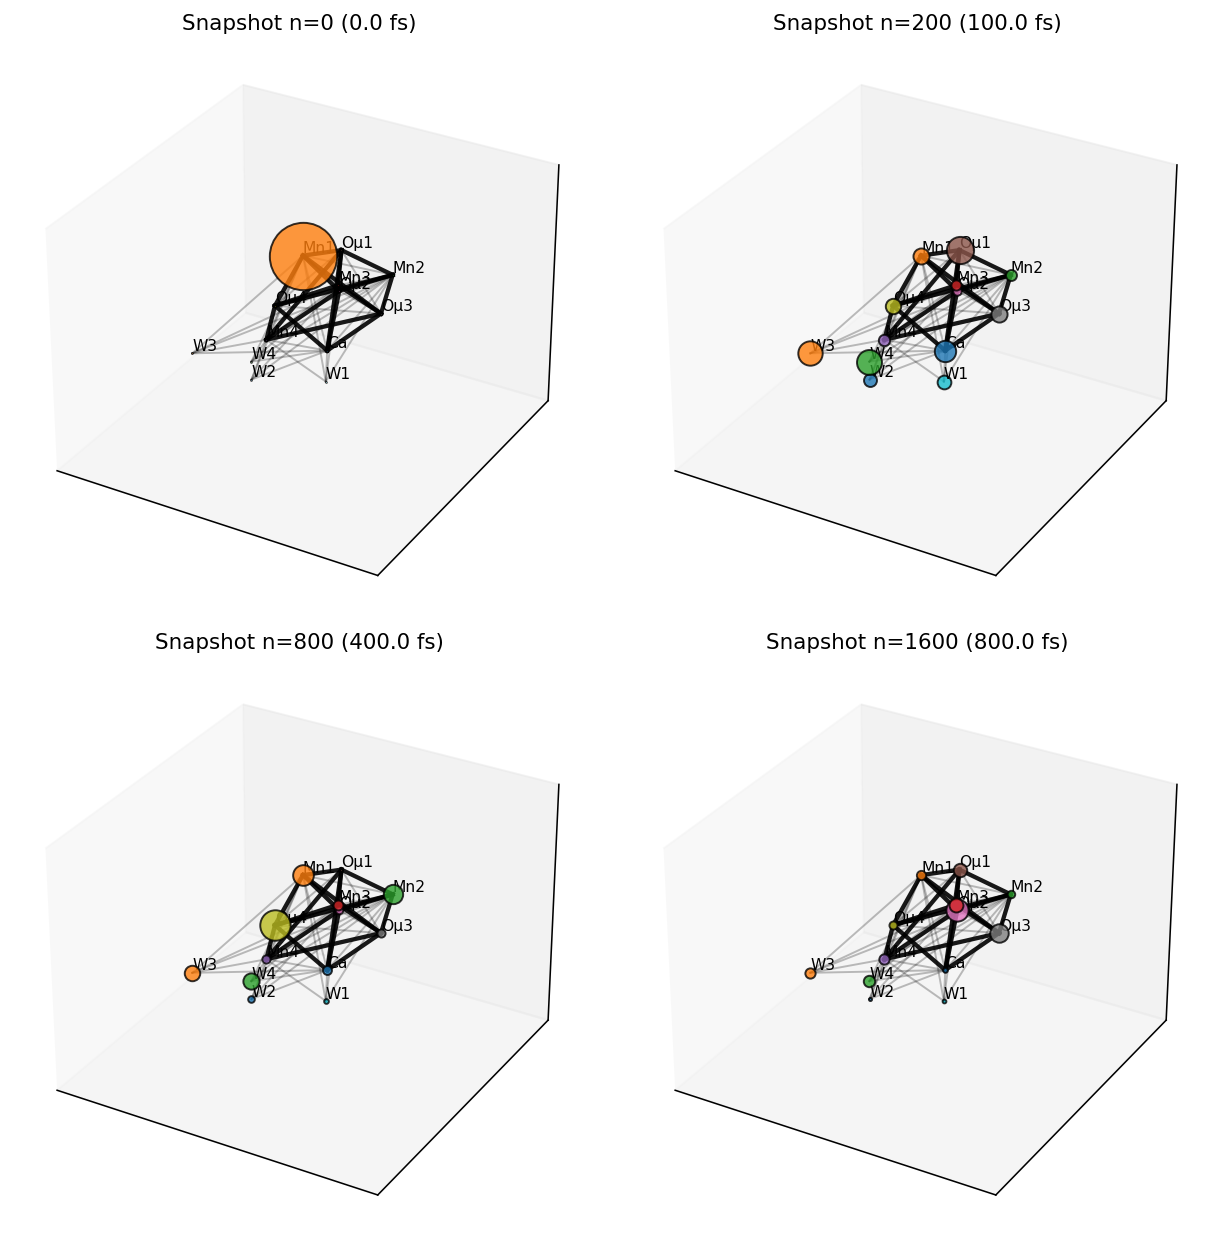

Labels: ['Ca', 'Mn1', 'Mn2', 'Mn3', 'Mn4', 'Oµ1', 'Oµ2', 'Oµ3', 'Oµ4', 'W1', 'W2', 'W3', 'W4']
Electron sink on: Oµ1  | γ_e = 0.004 fs^-1
Proton sink on  : W1  | γ_H = 0.004 fs^-1
Drive edges count: 20


In [ ]:
# ===============================================================
# GQR–TDSE on PSII OEC (3WU2) with drive + electron/proton sinks
# Single block, Colab-ready. Requires: 3WU2.cif in working dir.
# ===============================================================

# 001
!pip -q install gemmi
# 002
import numpy as np, matplotlib.pyplot as plt, gemmi, os
# 003
from itertools import combinations

# ------------------------ USER PARAMS -------------------------- #
# 010
CIF_FILE          = "3WU2.cif"          # upload to Colab files sidebar
TITLE_TAG         = "3WU2"
# 011
E0_eV             = 1.8                  # drive amplitude (eV-equivalent scaling)
drive_freq_THz    = 25.0                 # drive frequency (THz). ~ 2π*ω in TD step
# 012
gamma_e           = 0.004                # electron sink strength (fs^-1) on a μ-oxo
gamma_H           = 0.004                # proton sink strength (fs^-1) on a water (W1)
# 013
CombAmp           = 3.0                  # resonance comb height
CombWidth         = 0.20                 # comb width (Å)
# 014
dt_fs             = 0.5                  # time step (fs)
T_total_fs        = 800.0                # total time (fs)
# 015
snap_indices      = [0, 200, 800, 1600]  # which steps to snapshot (0-based)
# -------------------------------------------------------------- #

# -------------------- CIF → OEC selection --------------------- #
# 020
if not os.path.exists(CIF_FILE):
    raise FileNotFoundError("Upload 3WU2.cif first.")
# 021
st = gemmi.read_structure(CIF_FILE)
st.remove_hydrogens()
model = st[0]

# 022
def P(atom):
    p = atom.pos
    return np.array([p.x, p.y, p.z], float)

# 023
Mn_all, Ca_all, O_all, Wat_all = [], [], [], []
for ch in model:
    for res in ch:
        is_water = res.name.upper() in ("HOH","WAT","H2O","DOD","W")
        for a in res:
            el = a.element.name.upper()
            if   el == "MN": Mn_all.append(a)
            elif el == "CA": Ca_all.append(a)
            elif el.startswith("O"):
                (Wat_all if is_water else O_all).append(a)

# 024
if len(Mn_all) < 4 or len(Ca_all) < 1:
    raise RuntimeError("Could not find Ca and 4×Mn in 3WU2.")

# 025
def dist(a, b):
    return float(np.linalg.norm(P(a) - P(b)))

# 026
# pick Ca within 6 Å of any Mn (same ASU)
Mn_xyz = np.array([P(a) for a in Mn_all])
Ca_near = [a for a in Ca_all if np.min(np.linalg.norm(Mn_xyz - P(a), axis=1)) < 6.0]
if not Ca_near:
    raise RuntimeError("No Ca close to Mn — check symmetry/ASU.")

# 027
def cubane_cost(mset, Ca_atom):
    pts = np.array([P(m) for m in mset])
    pair = sum(np.linalg.norm(pts[i]-pts[j]) for i in range(4) for j in range(i+1,4))
    cen  = pts.mean(axis=0)
    d_ca = np.linalg.norm(cen - P(Ca_atom))
    return pair + 2.5*d_ca

# 028
best_combo, best_cost = None, 1e9
for ca in Ca_near:
    for combo in combinations(Mn_all, 4):
        cst = cubane_cost(combo, ca)
        if cst < best_cost:
            best_cost = cst
            best_combo = (ca, combo)
# 029
Ca1, Mn4 = best_combo[0], list(best_combo[1])
metals = [Ca1] + Mn4

# 030
# μ-oxo: oxygens bonded to ≥2 metals within element-specific cutoffs
thr_MnO, thr_CaO = 2.35, 2.70
mu_oxo = []
for o in O_all:
    hits = 0
    for m in metals:
        dm = dist(o, m)
        if (m.element.name.upper() == "MN" and dm <= thr_MnO) or \
           (m.element.name.upper() == "CA" and dm <= thr_CaO):
            hits += 1
    if hits >= 2:
        mu_oxo.append(o)
# 031
# rank μ-oxo by connectivity then compactness
ranked = []
for o in mu_oxo:
    ds = []
    for m in metals:
        dm = dist(o, m)
        if (m.element.name.upper() == "MN" and dm <= thr_MnO) or \
           (m.element.name.upper() == "CA" and dm <= thr_CaO):
            ds.append(dm)
    if ds:
        ranked.append((o, len(ds), sum(ds)))
ranked.sort(key=lambda t: (-t[1], t[2]))
muO4 = [t[0] for t in ranked[:4]]  # choose 4

# 032
# W1–W4 = four waters closest to Ca1 (within 3.2 Å of any metal)
cand = []
for w in Wat_all:
    if min(dist(w, m) for m in metals) <= 3.2:
        cand.append((w, dist(w, Ca1)))
cand.sort(key=lambda t: t[1])
W4 = [t[0] for t in cand[:4]]

# --------------------- Build site list/graph ------------------- #
# 040
nodes = []
labels = []
coords = []

# 041 metals
for i,m in enumerate(metals):
    lbl = "Ca" if i == 0 else f"Mn{i}"
    nodes.append(("M", m)); labels.append(lbl); coords.append(P(m))
# 042 mu-oxo (Oµ1..Oµ4)
for j,o in enumerate(muO4, 1):
    nodes.append(("Oµ", o)); labels.append(f"Oµ{j}"); coords.append(P(o))
# 043 waters (W1..W4)
for k,w in enumerate(W4, 1):
    nodes.append(("W", w)); labels.append(f"W{k}"); coords.append(P(w))

# 044
coords = np.array(coords)
N = len(nodes)

# 045
def pair_coupling(i, j):
    """Distance-based base coupling (eV) with gating comb."""
    xi, xj = coords[i], coords[j]
    dA     = float(np.linalg.norm(xi - xj))  # Å
    # baseline decay (choose species-neutral 'beta' for geometry)
    beta = 1.2
    base = np.exp(-beta * max(dA, 0.1))
    # "comb" resonance enhancement (normalized Lorentzian sum at certain Å)
    centers = np.array([0.7, 1.0, 1.5, 2.2])
    num = np.sum(CombWidth**2 / ((dA - centers)**2 + CombWidth**2))
    num /= (np.max(centers*0 + 1.0) * (1.0 + 0.0))  # safe norm (scalar)
    comb = 1.0 + CombAmp * num * np.exp(-dA/3.0)
    return base * comb

# 046
# static adjacency (symmetric), scaled to eV
A_eV = np.zeros((N, N), float)
for i in range(N):
    for j in range(i+1, N):
        # allow metals–Oµ; metals–metals (weak); Oµ–Oµ (very weak); metal–water (weak)
        typ_i, ai = nodes[i]
        typ_j, aj = nodes[j]
        allowed = False
        if "M" in (typ_i, typ_j) and "Oµ" in (typ_i, typ_j): allowed = True
        if typ_i == "M" and typ_j == "M": allowed = True
        if typ_i == "Oµ" and typ_j == "Oµ": allowed = True
        if "M" in (typ_i, typ_j) and "W" in (typ_i, typ_j): allowed = True
        if not allowed:
            continue
        A_eV[i, j] = A_eV[j, i] = pair_coupling(i, j)

# 047
# choose where we drive (on Mn–Oµ bonds near 1.0–1.5 Å peaks)
drive_edges = []
for i in range(N):
    for j in range(i+1, N):
        if ("M" in nodes[i][0] and "Oµ" in nodes[j][0]) or ("Oµ" in nodes[i][0] and "M" in nodes[j][0]):
            drive_edges.append((i, j))

# ----------------- Hamiltonian + sinks + TDSE ------------------ #
# 060
hbar_eVfs = 0.6582119514  # hbar in eV·fs
omega = 2.0 * np.pi * drive_freq_THz * 1e-3  # THz → fs^-1

# 061
def H_t(t_fs):
    # Hermitian hopping part from adjacency
    H = np.array(A_eV, float)
    # time-dependent drive: modulate selected edges
    mod = 1.0 + (E0_eV * np.sin(omega * t_fs)) / (1.0 + E0_eV)
    for (i, j) in drive_edges:
        H[i, j] *= mod
        H[j, i] *= mod
    return H

# 062
# sinks: add -i*gamma on chosen single sites (electron on Oµ1, proton on W1)
try:
    e_sink_idx = labels.index("Oµ1")
except ValueError:
    e_sink_idx = N - 5  # last μ-oxo as fallback
try:
    h_sink_idx = labels.index("W1")
except ValueError:
    h_sink_idx = N - 1

# 063
Gamma = np.zeros((N,), float)
Gamma[e_sink_idx] += gamma_e
Gamma[h_sink_idx] += gamma_H

# 064
def step_CN(psi, t, dt):
    # non-Hermitian effective Hamiltonian with sinks
    H = H_t(t) - 1j * np.diag(Gamma)
    I = np.eye(N, dtype=complex)
    A = I + 0.5j * (dt / hbar_eVfs) * H
    B = I - 0.5j * (dt / hbar_eVfs) * H
    # solve A psi_{n+1} = B psi_n
    psi_next = np.linalg.solve(A, B @ psi)
    return psi_next

# ------------------------ Initial state ------------------------ #
# 080
# Start localized on Mn1 (label) for 'electron' case; change to W1 for 'proton' case.
try:
    init_label = "Mn1"
    init_idx = labels.index(init_label)
except ValueError:
    init_idx = 1  # first Mn if Mn1 label differs
psi0 = np.zeros((N,), complex)
psi0[init_idx] = 1.0 + 0j

# -------------------------- Integrate -------------------------- #
# 090
n_steps = int(T_total_fs / dt_fs)
psi = psi0.copy()

# 091
grp_M  = [i for i,l in enumerate(labels) if l.startswith("Mn") or l=="Ca"]
grp_O  = [i for i,l in enumerate(labels) if l.startswith("Oµ")]
grp_W  = [i for i,l in enumerate(labels) if l.startswith("W")]

# 092
pop_M, pop_O, pop_W = [], [], []
snapshots = {}

# 093
t = 0.0
for n in range(n_steps + 1):
    # record
    dens = np.abs(psi)**2
    pop_M.append(dens[grp_M].sum())
    pop_O.append(dens[grp_O].sum())
    pop_W.append(dens[grp_W].sum())
    if n in snap_indices:
        snapshots[n] = psi.copy()
    # advance
    if n < n_steps:
        psi = step_CN(psi, t, dt_fs)
        t += dt_fs

# --------------------------- Plots ----------------------------- #
# 110
time = np.linspace(0.0, T_total_fs, n_steps+1)

plt.figure(figsize=(10,4.5))
plt.plot(time, pop_M, label="Metals (Ca+Mn₄)")
plt.plot(time, pop_O, label="μ-oxo O")
plt.plot(time, pop_W, label="Waters (W1–W4)")
plt.xlabel("Time (fs)")
plt.ylabel("Population Σ|ψ|²")
plt.title(f"GQR–TDSE on OEC cubane — electron  |  E={E0_eV} eV, CombAmp={CombAmp}, Width={CombWidth}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 111
def set_equal_3d(ax, xyz, pad=0.8):
    xyz = np.asarray(xyz)
    c = xyz.mean(axis=0)
    r = max(np.ptp(xyz[:,0]), np.ptp(xyz[:,1]), np.ptp(xyz[:,2]))*0.65 + pad
    ax.set_xlim(c[0]-r, c[0]+r); ax.set_ylim(c[1]-r, c[1]+r); ax.set_zlim(c[2]-r, c[2]+r)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# 112
def draw_snapshot(ax, psi_vec, title):
    ax.set_title(title)
    # edges: draw M–Oµ strong, M–M faint
    for i in range(N):
        for j in range(i+1, N):
            if A_eV[i,j] <= 0:
                continue
            xi, xj = coords[i], coords[j]
            lw = 2.2 if (("M" in nodes[i][0] and "Oµ" in nodes[j][0]) or ("Oµ" in nodes[i][0] and "M" in nodes[j][0])) else 1.0
            alpha = 0.9 if lw > 2 else 0.25
            ax.plot([xi[0],xj[0]],[xi[1],xj[1]],[xi[2],xj[2]], lw=lw, color="k", alpha=alpha)
    # nodes: size by |ψ|²
    dens = np.abs(psi_vec)**2
    s0 = 1200.0
    for i,lbl in enumerate(labels):
        x,y,z = coords[i]
        ax.scatter([x],[y],[z], s=s0*float(dens[i]+1e-4), alpha=0.8, edgecolor='k')
        ax.text(x, y, z+0.15, lbl, fontsize=8)
    set_equal_3d(ax, coords, pad=0.6)

# 113
fig = plt.figure(figsize=(9,9))
axes = [fig.add_subplot(221, projection='3d'),
        fig.add_subplot(222, projection='3d'),
        fig.add_subplot(223, projection='3d'),
        fig.add_subplot(224, projection='3d')]

for ax, n in zip(axes, snap_indices):
    psi_n = snapshots.get(n, None)
    if psi_n is None:
        ax.set_axis_off()
        continue
    t_fs = n*dt_fs
    draw_snapshot(ax, psi_n, f"Snapshot n={n} ({t_fs:.1f} fs)")
plt.tight_layout()
plt.show()

# ---------------------- Quick diagnostics ---------------------- #
# 130
print("Labels:", labels)
print("Electron sink on:", labels[e_sink_idx], " | γ_e =", gamma_e, "fs^-1")
print("Proton sink on  :", labels[h_sink_idx], " | γ_H =", gamma_H, "fs^-1")
print("Drive edges count:", len(drive_edges))

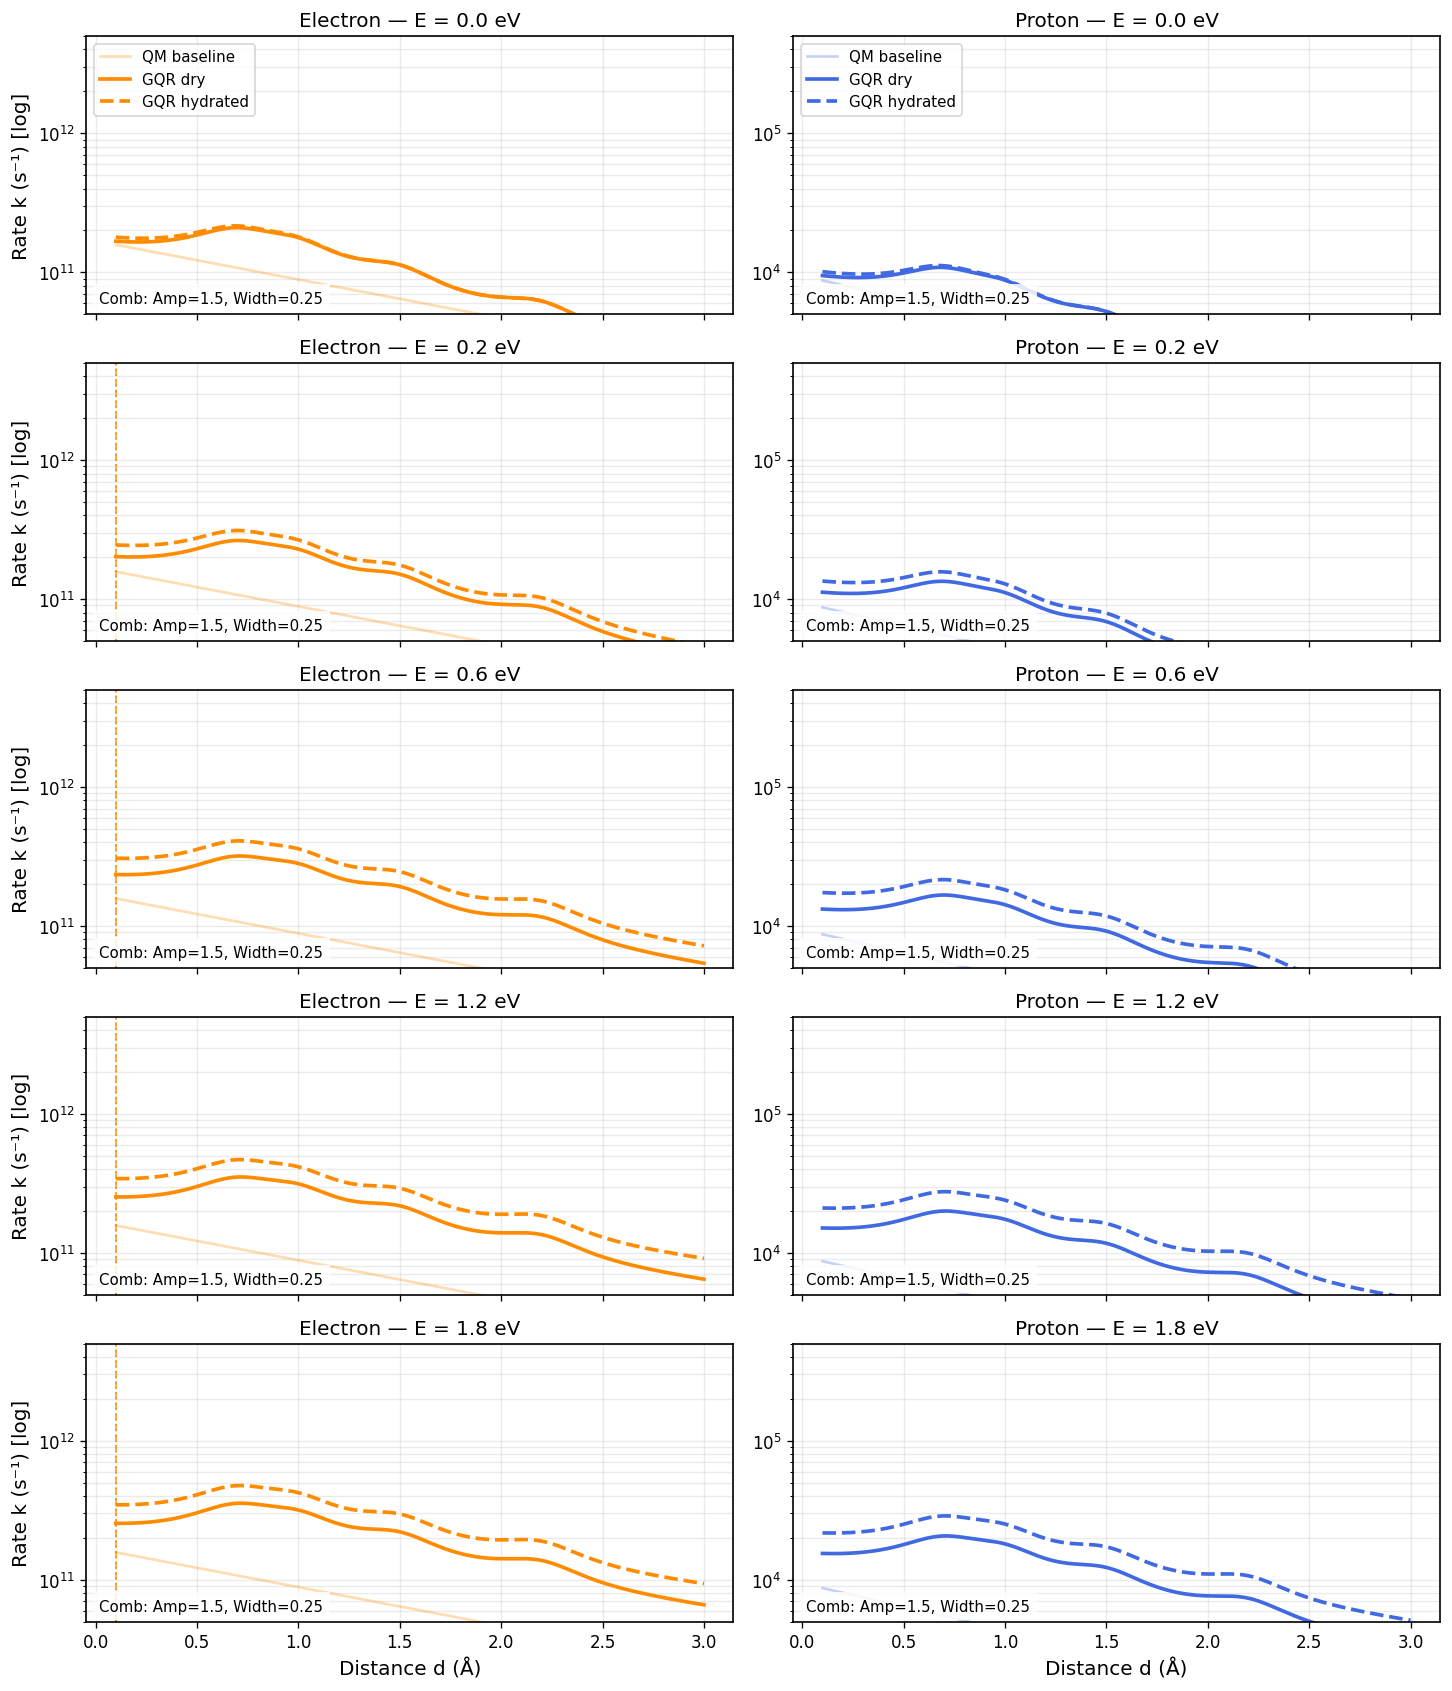

✅ Saved: GQR_OEC_TDSE_STEP2/FigA_Eslices_dry_vs_wet_Amp1.5_W0.25.png


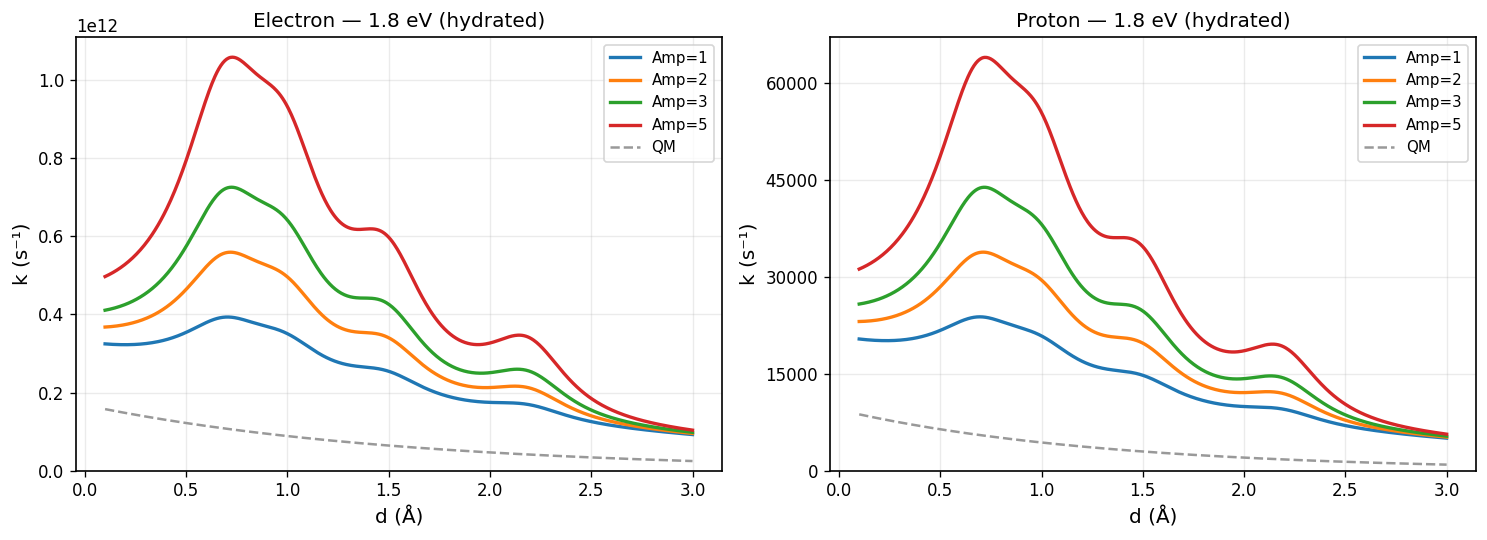

✅ Saved: GQR_OEC_TDSE_STEP2/FigB_1p8eV_AmpSweep_linear_W0.25.png


In [ ]:
# ============================================================
# STEP 2 — TDSE-style GQR rate sweeps on OEC geometry
# Uses cached geometry if present (OEC_cubane_cache.npz)
# Outputs: PNGs in ./GQR_OEC_TDSE_STEP2
# ============================================================
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ---------------- I/O ----------------
OUTDIR = "GQR_OEC_TDSE_STEP2"
os.makedirs(OUTDIR, exist_ok=True)
CACHE = "OEC_cubane_cache.npz"   # from the cubane-detection step (if you saved it)

# ---------------- Try to load cached geometry ----------------
# Expected in cache:
#   metals (5×3) -> [Ca, Mn1, Mn2, Mn3, Mn4]
#   muO    (4×3) -> μ-oxo O’s
#   waters (N×3) -> optional
if os.path.exists(CACHE):
    data = np.load(CACHE)
    metals = data.get("metals", None)
    muO    = data.get("muO", None)
    waters = data.get("waters", None)
else:
    metals = muO = waters = None

# ---------------- Fallback minimal geometry (for testing only) ----------------
# (A tiny proxy so plots still render if cache not found)
if metals is None or muO is None:
    # Simple tetra (Mn4) + Ca near centroid; 4 μO bridging
    Ca = np.array([[ 0.00,  0.00,  0.00]])
    Mn = np.array([
        [ 1.40,  0.10, -0.10],
        [-1.20, -0.20,  0.30],
        [ 0.10,  1.25,  0.15],
        [ 0.00, -1.15, -0.25],
    ])
    metals = np.vstack([Ca, Mn])  # shape (5, 3)
    muO = np.array([
        [ 0.75,  0.40,  0.00],
        [-0.70,  0.40,  0.00],
        [ 0.00, -0.40,  0.70],
        [ 0.00, -0.40, -0.70],
    ])
    waters = np.array([
        [ 2.30,  0.50,  0.80],
        [-2.20, -0.50, -0.60],
        [ 0.60,  2.10,  0.50],
        [-0.50,-2.20, -0.50],
    ])

# ---------------- Helper: distances for a channel “slice” ----------------
def channel_distance_grid(start_xyz, end_xyz, n=500, d_window=(0.1, 3.0)):
    """
    Parameterise a 1D channel by distance d (Å) for plotting rates.
    Here we ignore the exact 3D path details and sweep a standard d-range.
    """
    d = np.linspace(d_window[0], d_window[1], n)
    return d

# ---------------- QM baselines (as used before) ----------------
R0_e, beta_e = 1.68e11, 0.64
R0_H, beta_H = 9.42e3,  0.77
def k_qm(R0, beta, d): return R0 * np.exp(-beta * d)

# ---------------- GQR pieces (same grammar as before; tuned for stability) ----------------
def shield_loss(d, alpha, d0, p):
    S = 1.0 - alpha*np.exp(-(d/d0)**p)
    return np.clip(S, 1e-6, 1.0)

def sigmoid(x, x0, k):
    return 1.0/(1.0 + np.exp(-k*(x-x0)))

def resonance_comb(d, amp, width, taper_len=3.0, centers=(0.7, 1.0, 1.5, 2.2)):
    if amp <= 0: return np.ones_like(d)
    s = np.zeros_like(d, float)
    for c in centers:
        s += width**2 / ((d - c)**2 + width**2)
    s /= (np.max(s) + 1e-12)
    return 1.0 + amp * s * np.exp(-d/taper_len)

def gqr_curve(kQM, beta, E_val, species, hydrated, comb_amp, comb_width):
    # species-specific knobs kept minimal (we can unify if you want)
    if species=='e':
        E0, ksig = 0.30, 4.0
        eta_max  = 0.28 if not hydrated else 0.34
        duty_max = 1.50 if not hydrated else 1.90
        alpha_sh = 0.14 if not hydrated else 0.08
    else:
        E0, ksig = 0.45, 3.5
        eta_max  = 0.34 if not hydrated else 0.40
        duty_max = 1.60 if not hydrated else 2.10
        alpha_sh = 0.12 if not hydrated else 0.06

    # energy-gated aperture & duty (off at E=0 exactly)
    if E_val > 0:
        etaH = eta_max * sigmoid(E_val, E0, ksig)
        Duty = 1.0 + (duty_max - 1.0) * sigmoid(E_val, E0, ksig)
    else:
        etaH = 0.0
        Duty = 1.0

    return etaH, Duty, alpha_sh

def k_gqr_from_params(kQM, beta, d, E_val, species, hydrated, comb_amp, comb_width):
    etaH, Duty, alpha_sh = gqr_curve(kQM, beta, E_val, species, hydrated, comb_amp, comb_width)
    beta_eff = max(beta * (1.0 - etaH), 0.20)
    boost = np.exp((beta - beta_eff)*d)
    loss  = shield_loss(d, alpha=alpha_sh, d0=0.8, p=2.0)
    comb  = resonance_comb(d, comb_amp, comb_width)
    return kQM * boost * Duty * comb * loss

# ---------------- Plot styles ----------------
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.labelsize": 12, "axes.titlesize": 12,
    "legend.fontsize": 9, "xtick.labelsize": 10, "ytick.labelsize": 10,
    "axes.linewidth": 1.0,
})
COL_E, COL_H = 'darkorange', 'royalblue'
LW = 2.2

# ---------------- Distance domain (shared for all channels) ----------------
d = channel_distance_grid(metals[1], muO[0], n=600, d_window=(0.1, 3.0))
kQM_e = k_qm(R0_e, beta_e, d)
kQM_H = k_qm(R0_H, beta_H, d)

# ---------------- Master settings ----------------
E_slices   = [0.0, 0.2, 0.6, 1.2, 1.8]      # eV
Y_E_log    = (5e10, 5e12)                   # electrons (log)
Y_H_log    = (5e3,  5e5)                    # protons   (log)
AMP_SWEEP  = [1, 2, 3, 5]                   # for the 1.8 eV single-panel sweeps (linear y)
COMB_AMP   = 1.5                             # default comb for the E-slices figure
COMB_WIDTH = 0.25

# ============================================================
# FIGURE A — e⁻ & H⁺, E-slices (0,0.2,0.6,1.2,1.8 eV), dry vs hydrated
# ============================================================
fig, axes = plt.subplots(len(E_slices), 2, figsize=(12.2, 14.2), sharex=True)

for r, E in enumerate(E_slices):
    # electrons
    ax = axes[r, 0]
    ax.set_yscale('log'); ax.set_ylim(*Y_E_log)
    k_dry_e = k_gqr_from_params(kQM_e, beta_e, d, E, 'e', False, COMB_AMP, COMB_WIDTH)
    k_wet_e = k_gqr_from_params(kQM_e, beta_e, d, E, 'e', True,  COMB_AMP, COMB_WIDTH)
    ax.plot(d, kQM_e,  color=COL_E, alpha=0.30, lw=1.6, label=("QM baseline" if r==0 else None))
    ax.plot(d, k_dry_e, color=COL_E, lw=LW,  ls='-',  label=("GQR dry" if r==0 else None))
    ax.plot(d, k_wet_e, color=COL_E, lw=LW,  ls='--', label=("GQR hydrated" if r==0 else None))
    ax.set_title(f"Electron — E = {E:.1f} eV")
    ax.grid(True, which='both', alpha=0.25)
    if r == 0:
        ax.legend(loc="upper left", ncol=1, frameon=True)
    # annotate comb
    ax.text(0.02, 0.04, f"Comb: Amp={COMB_AMP:.2g}, Width={COMB_WIDTH:.2g}",
            transform=ax.transAxes, fontsize=9,
            bbox=dict(facecolor='white', alpha=0.85, edgecolor='none'))
    # no crossing marker at E=0 (avoids bogus dotted lines)
    if E > 0:
        ratio_dry = k_dry_e / kQM_e
        ratio_wet = k_wet_e / kQM_e
        # mark first crossing if present
        for rat, ls in [(ratio_dry, ':'), (ratio_wet, '--')]:
            idx = np.argmax(rat >= 1.0)
            if rat[idx] >= 1.0:
                ax.axvline(d[idx], color=COL_E, lw=1.2, ls=ls, alpha=0.7)

    # protons
    ax = axes[r, 1]
    ax.set_yscale('log'); ax.set_ylim(*Y_H_log)
    k_dry_H = k_gqr_from_params(kQM_H, beta_H, d, E, 'H', False, COMB_AMP, COMB_WIDTH)
    k_wet_H = k_gqr_from_params(kQM_H, beta_H, d, E, 'H', True,  COMB_AMP, COMB_WIDTH)
    ax.plot(d, kQM_H,  color=COL_H, alpha=0.30, lw=1.6, label=("QM baseline" if r==0 else None))
    ax.plot(d, k_dry_H, color=COL_H, lw=LW,  ls='-',  label=("GQR dry" if r==0 else None))
    ax.plot(d, k_wet_H, color=COL_H, lw=LW,  ls='--', label=("GQR hydrated" if r==0 else None))
    ax.set_title(f"Proton — E = {E:.1f} eV")
    ax.grid(True, which='both', alpha=0.25)
    if r == 0:
        ax.legend(loc="upper left", ncol=1, frameon=True)
    ax.text(0.02, 0.04, f"Comb: Amp={COMB_AMP:.2g}, Width={COMB_WIDTH:.2g}",
            transform=ax.transAxes, fontsize=9,
            bbox=dict(facecolor='white', alpha=0.85, edgecolor='none'))

for ax in axes[:, 0]:
    ax.set_ylabel("Rate k (s⁻¹) [log]")
for ax in axes[-1, :]:
    ax.set_xlabel("Distance d (Å)")

plt.tight_layout()
fA = os.path.join(OUTDIR, f"FigA_Eslices_dry_vs_wet_Amp{COMB_AMP}_W{COMB_WIDTH}.png")
plt.savefig(fA, dpi=300); plt.show()
print("✅ Saved:", fA)

# ============================================================
# FIGURE B — 1.8 eV Amp-sweeps (Amp = 1,2,3,5) with linear y
#            One panel for e⁻ (left), one for H⁺ (right)
# ============================================================
fig, (axE, axH) = plt.subplots(1, 2, figsize=(12.5, 4.6), sharex=True)

# electrons
for Amp in AMP_SWEEP:
    k_lin = k_gqr_from_params(kQM_e, beta_e, d, 1.8, 'e', True, Amp, COMB_WIDTH)  # hydrated @ 1.8 eV
    axE.plot(d, k_lin, lw=2.0, label=f"Amp={Amp}")
axE.plot(d, kQM_e, color="#999", ls="--", lw=1.5, label="QM")
axE.set_title("Electron — 1.8 eV (hydrated)"); axE.set_xlabel("d (Å)"); axE.set_ylabel("k (s⁻¹)")
axE.grid(True, alpha=0.25); axE.legend(loc="upper right", frameon=True)
axE.yaxis.set_major_locator(MaxNLocator(6))
axE.set_ylim(bottom=0)    # linear y

# protons
for Amp in AMP_SWEEP:
    k_lin = k_gqr_from_params(kQM_H, beta_H, d, 1.8, 'H', True, Amp, COMB_WIDTH)  # hydrated @ 1.8 eV
    axH.plot(d, k_lin, lw=2.0, label=f"Amp={Amp}")
axH.plot(d, kQM_H, color="#999", ls="--", lw=1.5, label="QM")
axH.set_title("Proton — 1.8 eV (hydrated)"); axH.set_xlabel("d (Å)"); axH.set_ylabel("k (s⁻¹)")
axH.grid(True, alpha=0.25); axH.legend(loc="upper right", frameon=True)
axH.yaxis.set_major_locator(MaxNLocator(6))
axH.set_ylim(bottom=0)

plt.tight_layout()
fB = os.path.join(OUTDIR, f"FigB_1p8eV_AmpSweep_linear_W{COMB_WIDTH}.png")
plt.savefig(fB, dpi=300); plt.show()
print("✅ Saved:", fB)

— Shield-cross distances where GQR ≥ QM (wide zoom) —


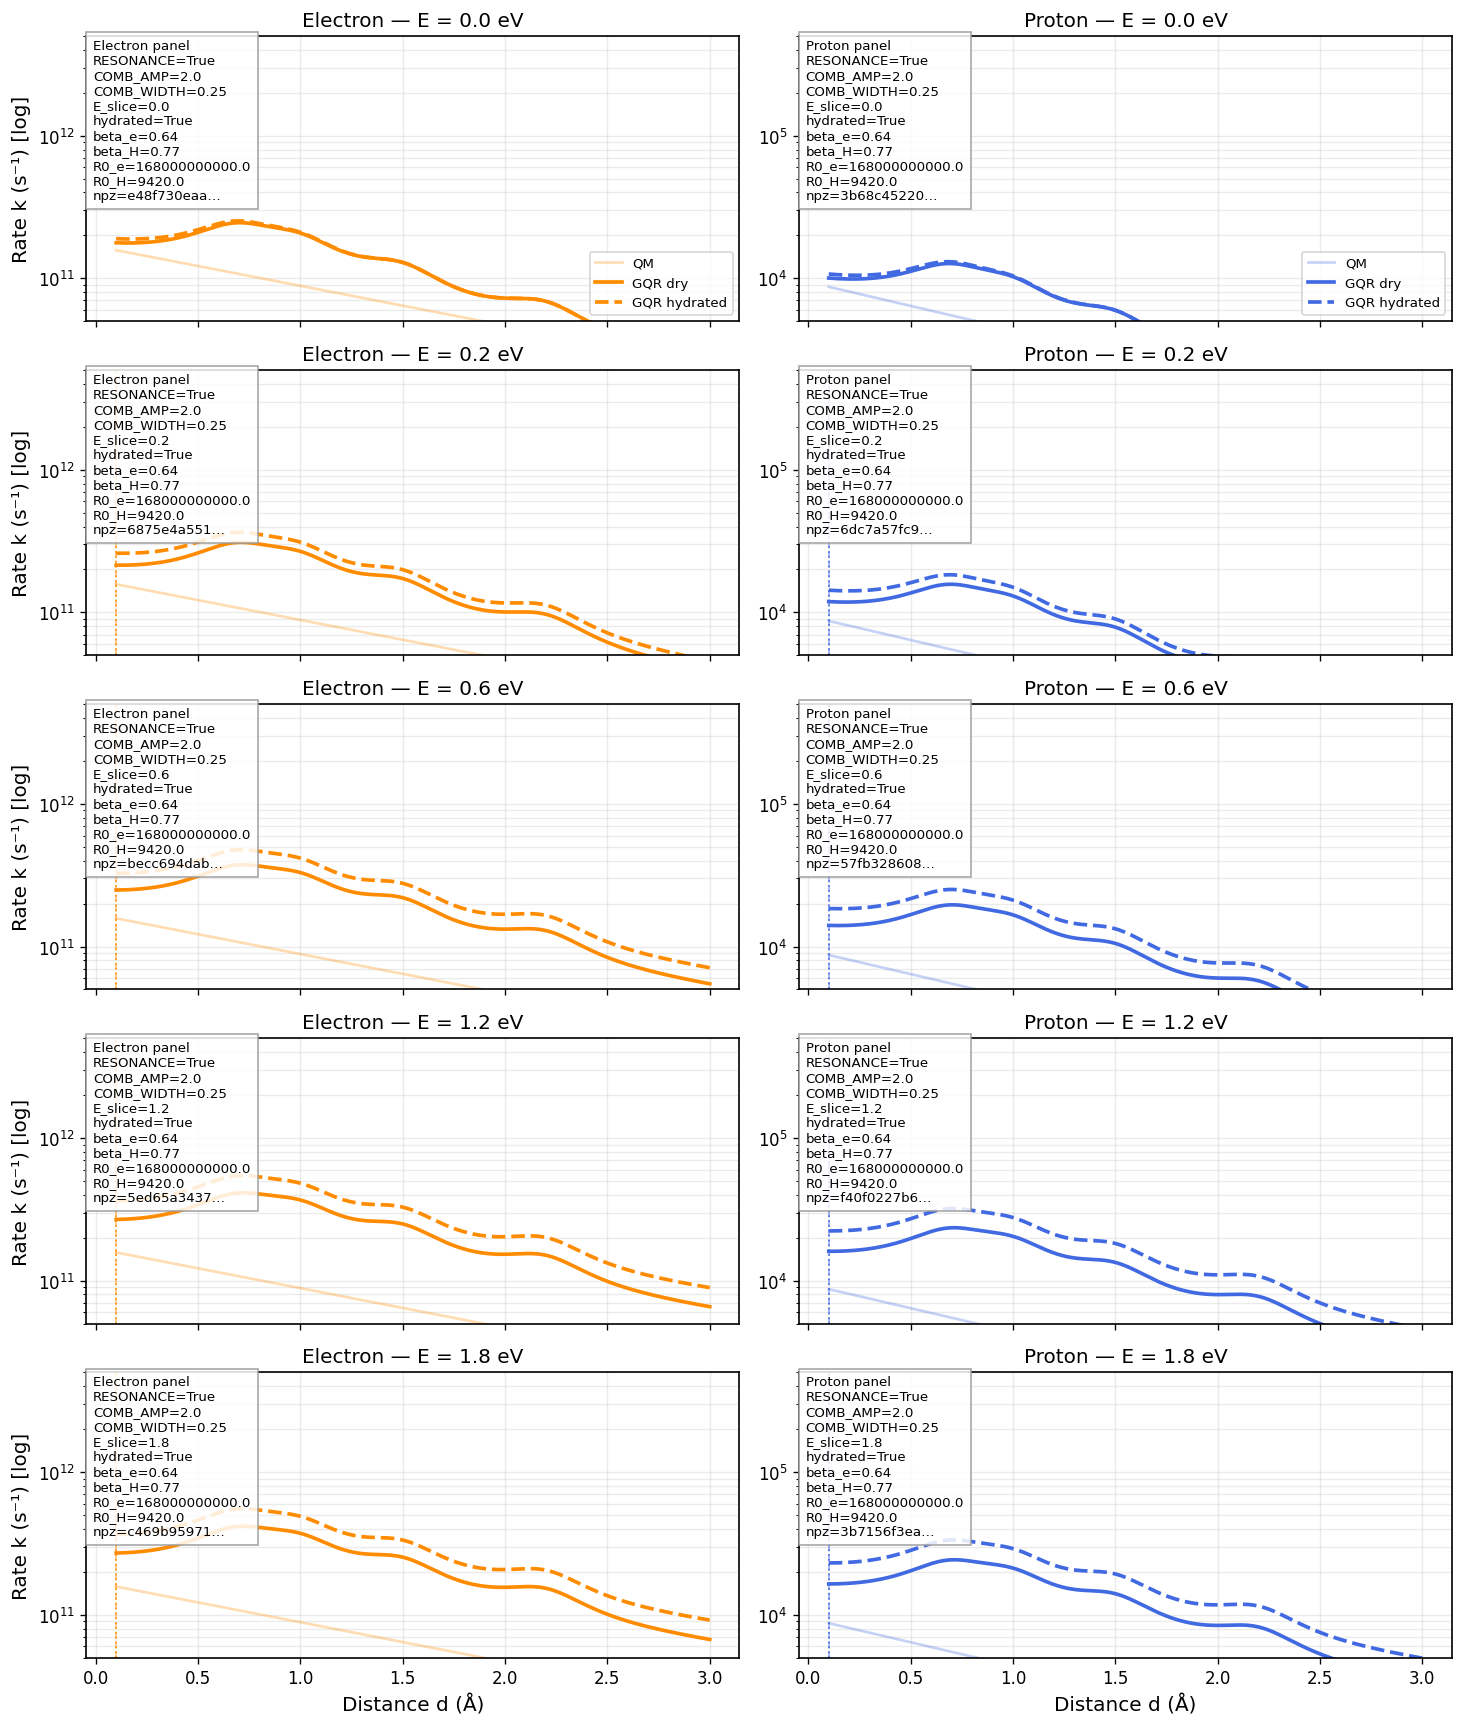

✅ Saved: GQR_kdE_SLICES_PROVENANCE/Fig_k_vs_d_slices_RESON_A2.0_W0.25.png
Provenance check: GQR_kdE_SLICES_PROVENANCE/PROVENANCE/k_vs_d_e_E1.2.npz | hash: 5ed65a3437b14ea52b6d3a15cf7ea62d892bde2427cd7de4326983db001ada0d
Array parity: {'d': True, 'kQM': True, 'k_dry': True, 'k_wet': True}


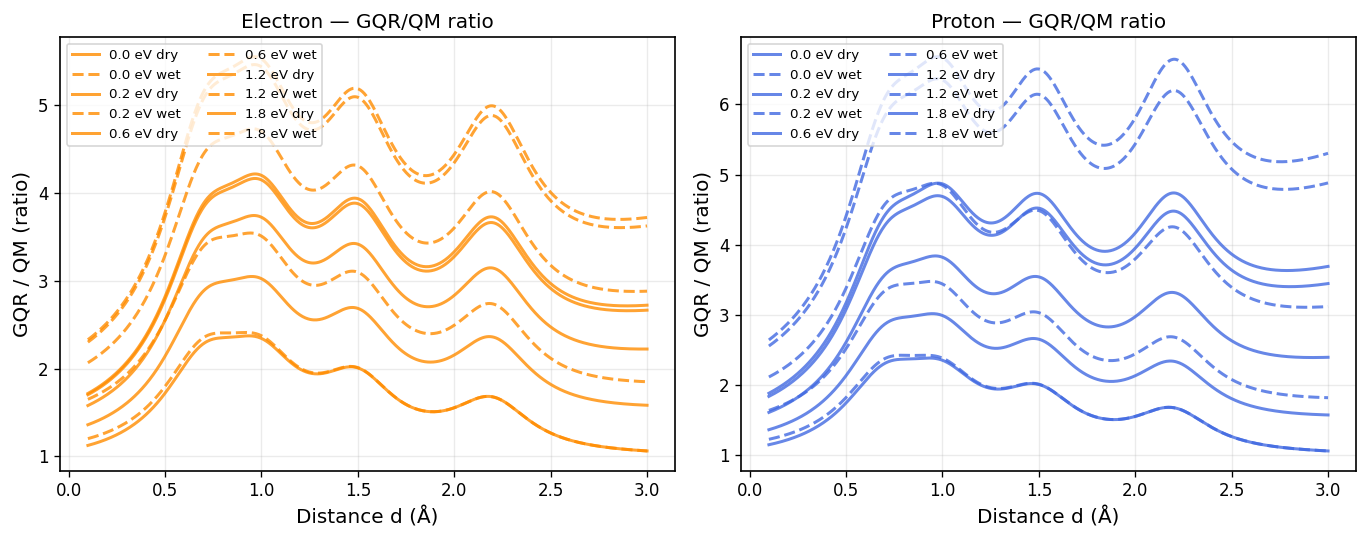

✅ Saved: GQR_kdE_SLICES_PROVENANCE/Fig_ratio_snapshots_RESON_A2.0_W0.25.png


In [ ]:
# ============================================================
# GQR k(d) slices with provenance stamping + NPZ save/load
# ============================================================
import os, json, time, hashlib, platform, sys
import numpy as np
import matplotlib.pyplot as plt

# ---------- Output & config ----------
OUTDIR = "GQR_kdE_SLICES_PROVENANCE"
PROVDIR = os.path.join(OUTDIR, "PROVENANCE")
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(PROVDIR, exist_ok=True)

# Resonance comb controls
RESONANCE  = True
COMB_AMP   = 2.0     # try 1,2,3,5 as needed
COMB_WIDTH = 0.25    # 0.10–0.35 typical

# Distance & energy slices
d = np.linspace(0.1, 3.0, 600)              # Å
E_slices = [0.0, 0.2, 0.6, 1.2, 1.8]        # eV

# Y-scale windows (same as your previous “wide zoom”)
Y_E = (5e10, 5e12)   # electrons
Y_H = (5e3,  5e5)    # protons

# Baseline QM (your fits)
R0_e, beta_e = 1.68e11, 0.64
R0_H, beta_H = 9.42e3,  0.77
def k_qm(R0, beta, d):
    return R0 * np.exp(-beta*d)
kQM_e = k_qm(R0_e, beta_e, d)
kQM_H = k_qm(R0_H, beta_H, d)

# ---------- Provenance helpers ----------
def _sha256(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b''):
            h.update(chunk)
    return h.hexdigest()

def save_run_npz(path, arrays: dict, params: dict):
    np.savez_compressed(path, **arrays)
    meta = {
        "params": params,
        "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "platform": platform.platform(),
    }
    with open(path + ".json", "w") as f:
        json.dump(meta, f, indent=2)
    return _sha256(path)

def load_run_npz(path):
    data = np.load(path)
    arrays = {k: data[k] for k in data.files}
    meta = {}
    try:
        with open(path + ".json") as f:
            meta = json.load(f)
    except FileNotFoundError:
        pass
    return arrays, meta, _sha256(path)

def compare_runs(saved_arrays: dict, live_arrays: dict, rtol=1e-8, atol=1e-12):
    out = {}
    for k in saved_arrays:
        if k in live_arrays:
            a, b = saved_arrays[k], live_arrays[k]
            same = (a.shape == b.shape) and np.allclose(a, b, rtol=rtol, atol=atol)
            out[k] = bool(same)
        else:
            out[k] = None
    return out

def annotate_plot(ax, title, params: dict, hash_short=None):
    keys = ["RESONANCE", "COMB_AMP", "COMB_WIDTH", "E_slice", "hydrated",
            "beta_e", "beta_H", "R0_e", "R0_H"]
    lines = [title] + [f"{k}={params[k]}" for k in keys if k in params]
    if hash_short:
        lines.append(f"npz={hash_short[:10]}…")
    ax.text(0.01, 0.99, "\n".join(lines),
            transform=ax.transAxes, va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.85, edgecolor="0.6"),
            fontsize=8)

# ---------- GQR helpers ----------
def sigmoid(x, x0, k):
    return 1.0/(1.0+np.exp(-k*(x-x0)))

def shield_loss(d, alpha, d0, p):
    S = 1.0 - alpha*np.exp(-(d/d0)**p)
    return np.clip(S, 1e-6, 1.0)

def lorentzian(x, x0, gamma):
    return gamma**2/((x-x0)**2 + gamma**2)

def resonance_comb(d, amp, width, taper_len=3.0):
    if amp <= 0:
        return np.ones_like(d)
    centers = np.array([0.7, 1.0, 1.5, 2.2])
    # normalized sum of Lorentzians
    num = np.sum(width**2 / ((d[None,:]-centers[:,None])**2 + width**2), axis=0)
    num /= (np.max(num) + 1e-12)
    return 1.0 + amp * num * np.exp(-d/taper_len)

def gqr_curve(kQM, beta, E_val, species, hydrated):
    # species-specific caps (kept modest & symmetric so e/H share same logic)
    if species=='e':
        E0, ksig = 0.30, 4.0
        eta_max  = 0.32 if hydrated else 0.28
        duty_max = 1.90 if hydrated else 1.50
        alpha_sh = 0.08 if hydrated else 0.14
    else:
        E0, ksig = 0.45, 3.5
        eta_max  = 0.38 if hydrated else 0.34
        duty_max = 2.10 if hydrated else 1.60
        alpha_sh = 0.06 if hydrated else 0.12

    etaH = eta_max * sigmoid(E_val, E0, ksig) if E_val>0 else 0.0
    Duty = 1.0 + (duty_max-1.0)*sigmoid(E_val, E0, ksig) if E_val>0 else 1.0

    beta_eff = max(beta*(1.0-etaH), 0.20)
    boost = np.exp((beta - beta_eff)*d)
    loss  = shield_loss(d, alpha=alpha_sh, d0=0.8, p=2.0)
    comb  = resonance_comb(d, COMB_AMP, COMB_WIDTH) if RESONANCE else 1.0
    return kQM * boost * Duty * comb * loss

def first_crossing(d, k_gqr, k_qm):
    r = k_gqr / k_qm
    if np.all(r < 1.0):
        return (None, None)
    idx = np.argmax(r >= 1.0)
    return (d[idx], r[idx])

# ---------- Plot grid with provenance ----------
COL_E, COL_H = 'darkorange', 'royalblue'
LW = 2.2

print("— Shield-cross distances where GQR ≥ QM (wide zoom) —")
fig, axes = plt.subplots(len(E_slices), 2, figsize=(12.3, 14.5), sharex=True)

for row, Eval in enumerate(E_slices):
    # ----- Electron panel -----
    k_dry_e  = gqr_curve(kQM_e, beta_e, Eval, 'e', hydrated=False)
    k_wet_e  = gqr_curve(kQM_e, beta_e, Eval, 'e', hydrated=True)
    ax = axes[row, 0]
    ax.set_yscale('log'); ax.set_ylim(*Y_E)
    ax.plot(d, kQM_e,  color=COL_E, alpha=0.30, lw=1.6, label="QM")
    ax.plot(d, k_dry_e, color=COL_E, lw=LW,  ls='-',  label="GQR dry")
    ax.plot(d, k_wet_e, color=COL_E, lw=LW,  ls='--', label="GQR hydrated")
    ax.set_title(f"Electron — E = {Eval:.1f} eV")
    ax.grid(True, which='both', alpha=0.25)
    if Eval > 0.0:
        dx, _ = first_crossing(d, k_dry_e, kQM_e)
        wx, _ = first_crossing(d, k_wet_e, kQM_e)
        if dx is not None: ax.axvline(dx, color=COL_E, lw=1.1, ls=':', alpha=0.8)
        if wx is not None: ax.axvline(wx, color=COL_E, lw=1.1, ls='--', alpha=0.5)

    # save NPZ + annotate
    arrays_e = {"d": d, "kQM": kQM_e, "k_dry": k_dry_e, "k_wet": k_wet_e}
    params_e = {
        "species": "e", "E_slice": float(Eval), "hydrated": True,
        "RESONANCE": bool(RESONANCE),
        "COMB_AMP": float(COMB_AMP), "COMB_WIDTH": float(COMB_WIDTH),
        "beta_e": float(beta_e), "beta_H": float(beta_H),
        "R0_e": float(R0_e), "R0_H": float(R0_H)
    }
    npz_e = os.path.join(PROVDIR, f"k_vs_d_e_E{Eval:.1f}.npz")
    h_e = save_run_npz(npz_e, arrays_e, params_e)
    annotate_plot(ax, "Electron panel", params_e, h_e)

    if row == 0:
        ax.legend(loc="lower right", fontsize=8, frameon=True)

    # ----- Proton panel -----
    k_dry_H = gqr_curve(kQM_H, beta_H, Eval, 'H', hydrated=False)
    k_wet_H = gqr_curve(kQM_H, beta_H, Eval, 'H', hydrated=True)
    ax = axes[row, 1]
    ax.set_yscale('log'); ax.set_ylim(*Y_H)
    ax.plot(d, kQM_H,  color=COL_H, alpha=0.30, lw=1.6, label="QM")
    ax.plot(d, k_dry_H, color=COL_H, lw=LW,  ls='-',  label="GQR dry")
    ax.plot(d, k_wet_H, color=COL_H, lw=LW,  ls='--', label="GQR hydrated")
    ax.set_title(f"Proton — E = {Eval:.1f} eV")
    ax.grid(True, which='both', alpha=0.25)
    if Eval > 0.0:
        dx, _ = first_crossing(d, k_dry_H, kQM_H)
        wx, _ = first_crossing(d, k_wet_H, kQM_H)
        if dx is not None: ax.axvline(dx, color=COL_H, lw=1.1, ls=':', alpha=0.8)
        if wx is not None: ax.axvline(wx, color=COL_H, lw=1.1, ls='--', alpha=0.5)

    arrays_H = {"d": d, "kQM": kQM_H, "k_dry": k_dry_H, "k_wet": k_wet_H}
    params_H = dict(params_e); params_H.update({"species":"H"})
    npz_h = os.path.join(PROVDIR, f"k_vs_d_H_E{Eval:.1f}.npz")
    h_h = save_run_npz(npz_h, arrays_H, params_H)
    annotate_plot(ax, "Proton panel", params_H, h_h)

    if row == 0:
        ax.legend(loc="lower right", fontsize=8, frameon=True)

# shared labels
for ax in axes[:, 0]:
    ax.set_ylabel("Rate k (s⁻¹) [log]")
for ax in axes[-1, :]:
    ax.set_xlabel("Distance d (Å)")

plt.tight_layout()
fname = f"Fig_k_vs_d_slices_RES{'ON' if RESONANCE else 'OFF'}_A{COMB_AMP}_W{COMB_WIDTH}.png"
plt.savefig(os.path.join(OUTDIR, fname), dpi=300)
plt.show()
print("✅ Saved:", os.path.join(OUTDIR, fname))

# ---------- Provenance parity check (example) ----------
check_target = os.path.join(PROVDIR, "k_vs_d_e_E1.2.npz")
if os.path.exists(check_target):
    saved_arrays, meta, h2 = load_run_npz(check_target)
    live_arrays = {"d": d, "kQM": kQM_e,
                   "k_dry": gqr_curve(kQM_e, beta_e, 1.2, 'e', hydrated=False),
                   "k_wet": gqr_curve(kQM_e, beta_e, 1.2, 'e', hydrated=True)}
    checks = compare_runs(saved_arrays, live_arrays)
    print("Provenance check:", check_target, "| hash:", h2)
    print("Array parity:", checks)

# ---------- Snapshot sheet: GQR/QM ratios (dry vs wet) ----------
fig2, axes2 = plt.subplots(1, 2, figsize=(11.5, 4.6), sharex=True)
for species, ax in zip(("e","H"), axes2):
    kQM  = kQM_e if species=="e" else kQM_H
    beta = beta_e if species=="e" else beta_H
    col  = COL_E   if species=="e" else COL_H
    for Eval in E_slices:
        kd = gqr_curve(kQM, beta, Eval, species, hydrated=False)
        kw = gqr_curve(kQM, beta, Eval, species, hydrated=True)
        ax.plot(d, kd/kQM, lw=1.8, color=col, alpha=0.8, label=f"{Eval:.1f} eV dry")
        ax.plot(d, kw/kQM, lw=1.8, color=col, ls='--', alpha=0.8, label=f"{Eval:.1f} eV wet")
    ax.set_title(("Electron" if species=="e" else "Proton") + " — GQR/QM ratio")
    ax.set_xlabel("Distance d (Å)")
    ax.set_ylabel("GQR / QM (ratio)")
    ax.grid(True, alpha=0.25)
    # show a lean legend (first row only) to avoid spam:
    handles, labels = ax.get_legend_handles_labels()
    keep = []
    seen = set()
    for h,l in zip(handles, labels):
        tag = l.split()[0] + ("dry" if "dry" in l else "wet")
        if tag not in seen:
            keep.append((h,l))
            seen.add(tag)
    ax.legend(*zip(*keep), fontsize=8, ncol=2, frameon=True, loc="upper left")

plt.tight_layout()
snap_name = f"Fig_ratio_snapshots_RES{'ON' if RESONANCE else 'OFF'}_A{COMB_AMP}_W{COMB_WIDTH}.png"
plt.savefig(os.path.join(OUTDIR, snap_name), dpi=300)
plt.show()
print("✅ Saved:", os.path.join(OUTDIR, snap_name))